# MRSAA-c
## Macro-Roughness Saltation-Abrasion-Alluviation model

### Implements 2017 corrected model formulation as described in Zhang et al (to be submitted)


Macro-roughness model framework for treating erosion, bed cover, and sediment transport in bedrock river channels.

Conceived and developed by Zhang Li and Gary Parker, with help from C. P. Stark, T. Inoue, E. Viparelli, X. Fu, N. Izumi, R. Schumer, J. Kwang, T. Li, and G. Wang.


### Python code written by Zhang Li, 2017
Adapted to Jupyter notebook by C. P. Stark

Copyright (C) 2017 L. Zhang, C. P. Stark, and G. Parker.

Developer can be contacted by email: lizhangpig@gmail.com.

This program is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation; either version 2 of the License, or any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.
You should have received a copy of the GNU General Public License along with this program; if not, write to the Free Software Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA.

## References

1. [Zhang, Parker, Stark, Inoue, Viparelli, Fu, and Izumi, 2015, "Macro-roughness model of bedrock–alluvial river morphodynamics", Earth Surface Dynamics, 3, 113–138.](http://www.earth-surf-dynam.net/3/113/2015/)
2. Zhang, Stark, Schumer, Kwang,  Li,  Fu,  Wang and Parker, 2017, "The advective-diffusive morphodynamics of mixed bedrock-alluvial rivers subjected to spatiotemporally varying sediment supply" (to be submitted)

# Parameters


### Notebook setup

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('pdf', 'png')
import matplotlib as mpl

mpl.rc( 'savefig', dpi=75)
mpl.rc( 'figure', autolayout=False,figsize=(18,14),titlesize=30)
mpl.rc( 'axes', labelsize=14,titlesize=20)
mpl.rc( 'lines', linewidth=2.0, markersize=8)
# mpl.rc( 'font', size=14,family='Times New Roman', serif='cm')
# mpl.rc( 'font', size=14,family='DejaVu Sans', serif='cm')
mpl.rc( 'legend', fontsize=14)
# mpl.rc( 'text', usetex=True)

mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{amsmath}',
    r'\usepackage{helvet}',
    r'\usepackage{sansmath}',
    r'\sansmath',
    r'\renewcommand{\familydefault}{\sfdefault}',
    r'\usepackage[T1]{fontenc}',
    r'\usepackage{graphicx}',
    r'\usepackage{relsize}',
    r'\newcommand{\bigpi}{\scalebox{5}{\ensuremath{\pi}}}'
]

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9640\1569972413.py:15: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  mpl.rcParams['text.latex.preamble'] = [


In [3]:
import numpy as np

### Simulation dimensions, steps

In [126]:
L=2000
dt=0.001
dx=200
M=np.int(L/dx)
print('Streamwise spatial resolution (number of resolved points): M='+str(np.int(L/dx)))
print('Temporal resolution (model time step): $\Delta{t}$=%g days' % (dt*365.25))

au=1

Streamwise spatial resolution (number of resolved points): M=10
Temporal resolution (model time step): $\Delta{t}$=0.36525 days


C:\Users\Sergio\AppData\Local\Temp\ipykernel_9640\2096456066.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  M=np.int(L/dx)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9640\2096456066.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional 

### Model variables

In [127]:
qbfeed0=0.000834             # Bedload feed  [m^2/s]
Tc=40                        # Reference duration   [y]
high_year=2.5                # Duration of high feed rate  [y]
rt=high_year/Tc              # Fraction of time at high feed rate  [-]
upl=0.000                    # Uplift rate  [m/y] 0.005
Lr=1                         # Length of reach  [m]
pcr=0.05                     # p_l in paper
pclr=1-pcr                   # p_h in paper
peta=(1-pcr)/(pclr-pcr)      # p in paper
alt=4                        # ?
nt=1.5                       # ?
tausc=0.0495                 # Critical Shields number  [-]
fis=1                        # ?
Rr=1.65                      # Submerged specific gravity of sediment  [-]
beta=0.00005                 # Bedrock abrasion coefficient  [L^-1]
g=9.81                       # Acceleration due to gravity  [m/s^2]
Cz=10                        # Chezy resistance coefficient  [-]
Qf=300                       # Flood discharge  [m^3/s]
B=100                        # Channel width  [m]
intermittency=0.05           # Flood intermittency  [-]
lambda_a=0.35                # Porosity of alluvium  [-]
D=0.02                       # Gravel grain size  [m]
eta_a_initial=0.5            # Initial alluvial thickness  [m]
slope_initial=0.004          # Initial slope (bedrock and bed)  [-]

### Randomize or not

In [128]:
do_random = False
random_seed = 2

### Set ratio of high-to-mean feed rate, $r_{qh}$

In [129]:
rqh=9

### Plotting options

In [130]:
# total time is Ntoprint*Nprint*dt in years. e.g. 1500*4000*0.001=6000y
Ntoprint=1000 # how often to record /dt. e.g. 4000 = 4y 
Nprint=10  # how many times to record. 
            # e.g.. 1500=1500 records of 4 years for total 6000y
N_subset_print_step = 1  # more grouping. e.g. plot every 10 = 10*4y 

# Sediment feed (sedimentograph)

##   Prepare

In [131]:
qbfeed=np.zeros(np.int(Tc/dt+1))

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9640\1059818772.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  qbfeed=np.zeros(np.int(Tc/dt+1))


##   Alternative 1: Non-random feed

In [132]:
if not do_random:
    h_Yr=Tc*rt
    Yr=np.arange(0,Ntoprint*Nprint*dt+dt,dt)
    h_Yr_step=np.int(h_Yr/dt)
    Yr_step=np.int(Tc/dt)

    qbfeed=np.zeros((Yr.size))

    for i in range(0,np.int(Ntoprint*Nprint*dt/Tc),1):
        qbfeed[0]=rqh*qbfeed0

        h_Yr_index=np.arange(i*Tc/dt+1,i*Tc/dt+h_Yr_step+1,1)
        h_Yr_index=h_Yr_index.astype(int)
        qbfeed[h_Yr_index]=rqh*qbfeed0*np.ones(h_Yr_index.size)

        l_Yr_index=np.arange(i*Tc/dt+h_Yr_step+1,i*Tc/dt+Yr_step+1,1)
        l_Yr_index=l_Yr_index.astype(int)
        qbfeed[l_Yr_index]=(1-rt*rqh)/(1-rt)*qbfeed0*np.ones(l_Yr_index.size)

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9640\1404504492.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  h_Yr_step=np.int(h_Yr/dt)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_9640\1404504492.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for 

C:\Users\Sergio\AppData\Local\Temp\ipykernel_9640\2670864587.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _ = plt.xlim(0,np.int(Ntoprint*Nprint*dt));


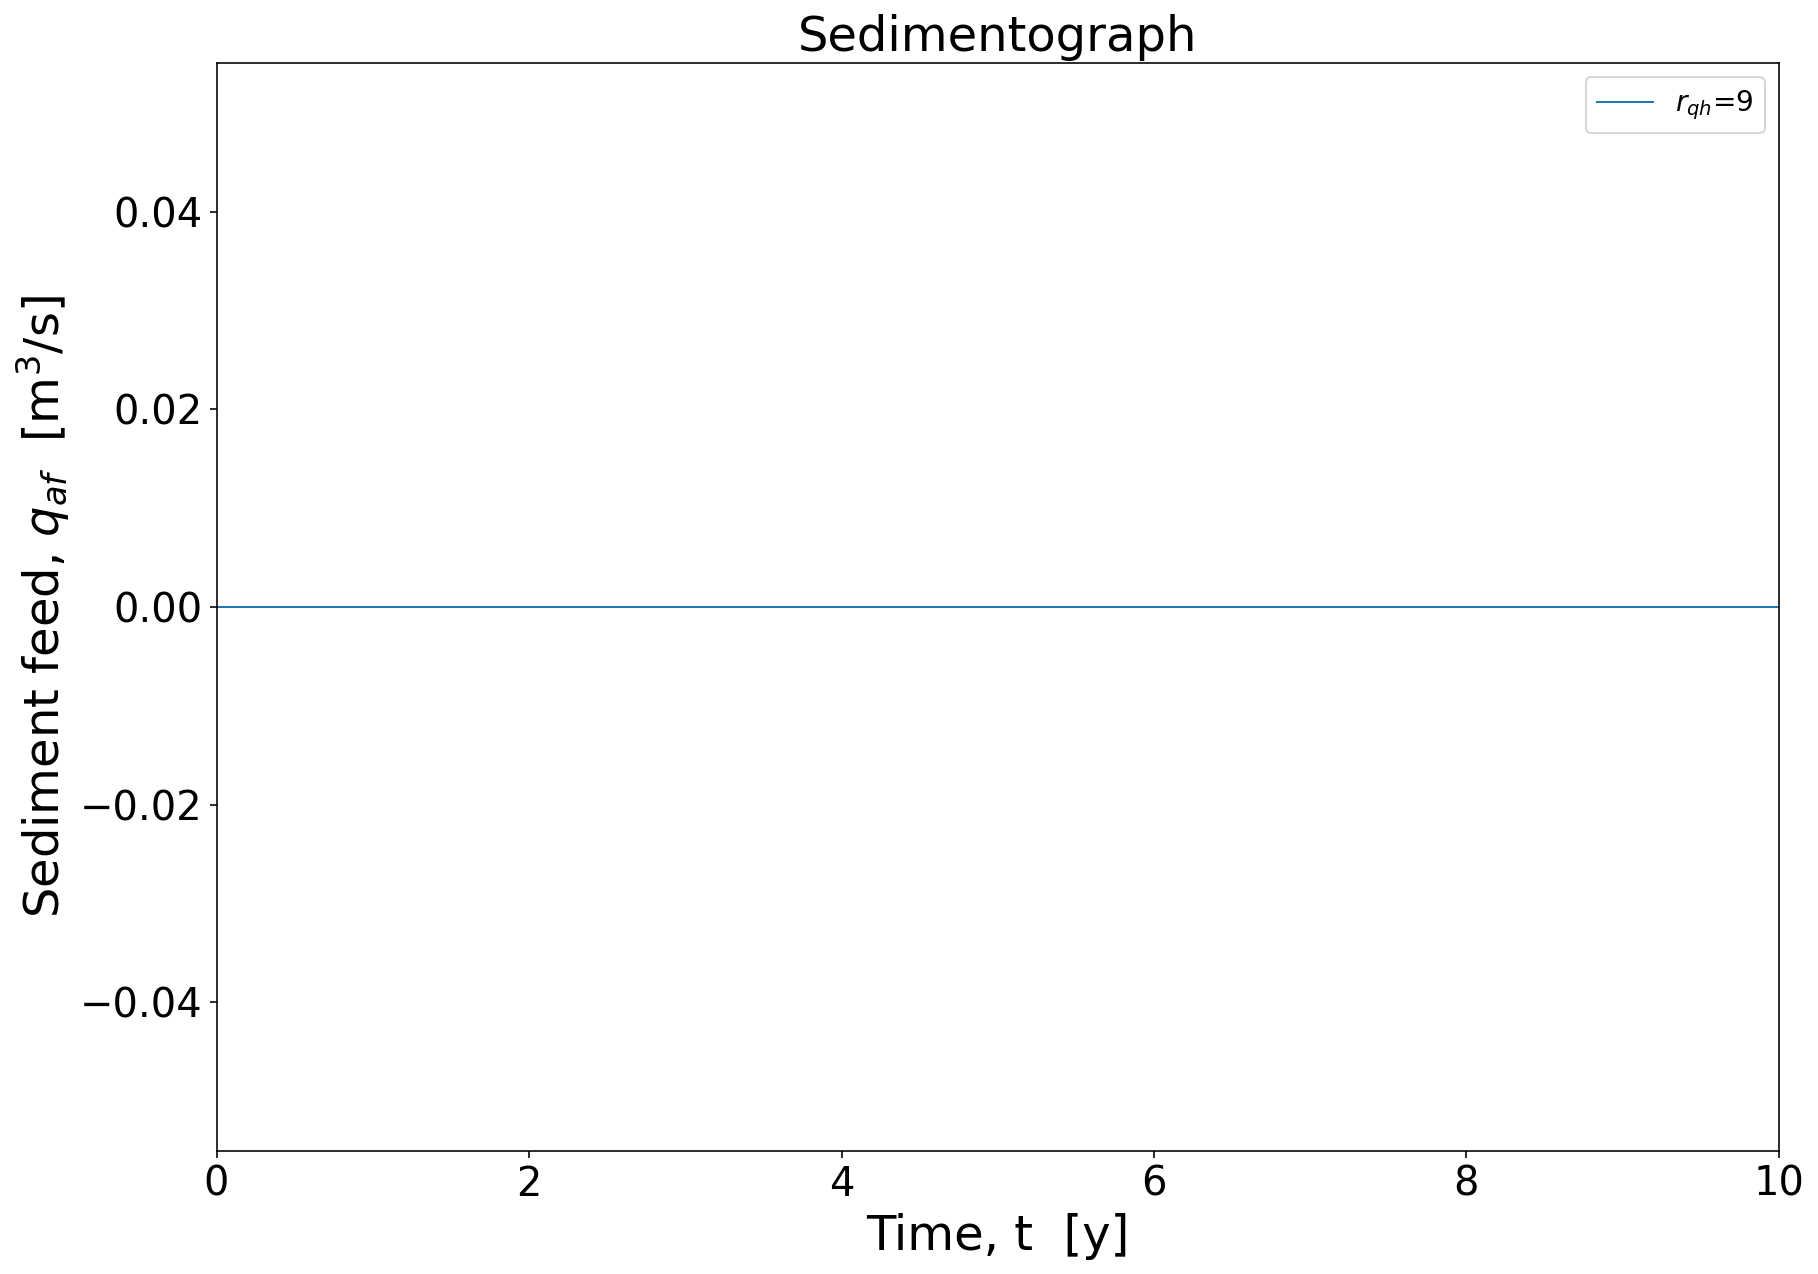

In [133]:
if not do_random:
    fh = plt.figure(figsize=(14,10))
    ax = plt.gca()

    _ = plt.plot(Yr,qbfeed,'-',label='$r_{qh}$='+str(rqh),lw=1 );
    _ = plt.title('Sedimentograph', fontsize=24);
    _ = plt.xlabel('Time, t  [y]',fontsize=24);
    _ = plt.ylabel('Sediment feed, $q_{af}$  [m$^3$/s]', fontsize=24);
    ax.tick_params(labelsize=20);
    _ = plt.xlim(0,np.int(Ntoprint*Nprint*dt));
    # plt.xticks(np.arange(0,np.int(Ntoprint*Nprint*dt)+10,10*100));
    _ = plt.legend(loc='upper right');

    plt.show();
    #plt.savefig('sedimentograph.png');
    #np.savetxt('qbfeed.csv',qbfeed);

## Alternative 2: Randomized feed

In [134]:
if do_random:
    np.random.seed(random_seed)
    h_Yr=Tc*rt
    Yr=np.arange(0,np.int(Ntoprint*Nprint*dt)+dt,dt)
    h_Yr_step=np.int(h_Yr/dt)
    Yr_step=np.int(Tc/dt)
    rqh_random=np.zeros(np.int(Ntoprint*Nprint*dt/Tc))
    begin_random=6
    stop_random=12
    step_random=0.5
    range_random=np.arange(begin_random,stop_random+step_random,step_random)
    range_random_mean=np.mean(range_random)

    qbfeed=np.zeros((Yr.size))

    for i in range(0,np.int(Ntoprint*Nprint*dt/Tc),1):

       rqh=np.random.choice(range_random)
       rqh_random[i]=rqh

       qbfeed[0]=rqh*qbfeed0

       h_Yr_index=np.arange(i*Tc/dt+1,i*Tc/dt+h_Yr_step+1,1)
       h_Yr_index=h_Yr_index.astype(int)
       qbfeed[h_Yr_index]=rqh*qbfeed0*np.ones(h_Yr_index.size)

       l_Yr_index=np.arange(i*Tc/dt+h_Yr_step+1,i*Tc/dt+Yr_step+1,1)
       l_Yr_index=l_Yr_index.astype(int)
       qbfeed[l_Yr_index]=(1-rt*rqh)/(1-rt)*qbfeed0*np.ones(l_Yr_index.size)

In [114]:
if do_random:
    fh = plt.figure(figsize=(14,10))
    ax = plt.gca() 
    
    _ = plt.plot(Yr,qbfeed,'-',label='$r_{qh}$='+str(rqh),lw=1 );
    _ = plt.title('Sedimentograph', fontsize=24);
    _ = plt.xlabel('Time, t  [y]',fontsize=24);
    _ = plt.ylabel('Sediment feed, $q_{af}$ [m$^3$/s]', fontsize=24);
    ax.tick_params(labelsize=20)
    _ = plt.xlim(0,np.int(Ntoprint*Nprint*dt));
    # plt.xticks(np.arange(0,np.int(Ntoprint*Nprint*dt)+40,40))
    _ = plt.legend(loc='upper right');

    #plt.savefig('sedimentograph.png');
    plt.show();
    #np.savetxt('qbfeed.csv',qbfeed);
    #np.savetxt('rqhrandom.csv',rqh_random)  ;

#  Calculate $\eta_a$, $\eta_b$, $p_c$, slope $S$

## Prepare

In [115]:
slope_vary=np.zeros(M+1)
etaa=np.zeros(M+1)
etab=np.zeros(M+1)

eta_a=np.zeros([M+1,Ntoprint+1])
eta_b=np.zeros([M+1,Ntoprint+1])
slope=np.zeros([M+1,Ntoprint+1])
slope_b=np.zeros([M+1,Ntoprint+1])

eta_a_1=np.zeros([M+1,Nprint])
eta_b_1=np.zeros([M+1,Nprint])
eta_ab_1=np.zeros([M+1,Nprint])
slope_b_1=np.zeros([M+1,Nprint])
slope_1=np.zeros([M+1,Nprint])
Qtt=np.zeros([M+1,Nprint])
PC=np.zeros([M+1,Nprint])
PA=np.zeros([M+1,Nprint])

xx=np.arange(0,L+dx,dx)
s_i=slope_initial*np.ones(M+1)
eta_a[:,0]=eta_a_initial*np.ones(M+1)
eta_b[:,0]=L*slope_initial-xx*slope_initial
slope[:,0]=s_i
slope_b[:,0]=s_i
#print(eta_a[:,0],eta_b[:,0],slope[:,0],slope_b[:,0])

qstarx0=np.zeros(M+1)
qstarx=np.zeros(M+1)
qtt=np.zeros(M+1)
pc=np.zeros(M+1)
qttst=np.zeros(M+1)
qqtf=np.zeros(Ntoprint+1)
qtstar=np.zeros(M+2)

In [116]:
A=np.zeros([M+1,M+1])
A[0,0]=1
A[M,M]=-1
A[0,1]=-1
A[M,M-1]=1
for i in range(1,M,1):
    A[i,i+1]=-0.5
    A[i,i-1]=0.5
print(A,A.size,np.size(A,axis=1))

[[ 1.  -1.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.5  0.  -0.5  0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.5  0.  -0.5  0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.5  0.  -0.5  0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.5  0.  -0.5  0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.5  0.  -0.5  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.5  0.  -0.5  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.5  0.  -0.5  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.5  0.  -0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.5  0.  -0.5]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   1.  -1. ]] 121 11


In [117]:
Bm=np.zeros([M+1,M+2])
Bm[M,M]=-1
Bm[M,M+1]=1
for i in range(0,M,1):
    Bm[i,i]=-au
    Bm[i,i+1]=2*au-1
    Bm[i,i+2]=1-au
print(Bm,Bm.size,np.size(Bm,axis=0))

[[-1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.]] 132 11


## Integrate

In [118]:
def integrate():
    seconds_per_year = (365.25)*24*60*60
    for w in range(0,Nprint,1):         # Nprint  =  1500
        print(w,end=' ',flush=True)
        for j in range(0,Ntoprint,1):   # Ntoprint = 4000
            slope_vary=np.dot(A,(eta_a[:,j]+eta_b[:,j])/dx)
            slope_vary[slope_vary<0]=0
            taux=(((Qf/B)**2)/(Cz**2)/g)**(1/3)*(slope_vary**(2/3))/Rr/D
            qstarx0=(fis*taux-tausc)
            qstarx0[qstarx0<0]=0
            qstarx=alt*(qstarx0)**nt

            qtt=((Rr*g*D)**0.5)*D*qstarx

            pc = pcr+(pclr-pcr)*eta_a[:,j]/Lr
            pc[eta_a[:,j]>=(Lr*peta)]=1
            pc[eta_a[:,j]<0]=0

            pa = (pc-pcr)/(1-pcr)
            qttst = pa*qtt
    #         qttst=(pc-pcr)/(1-pcr)*qtt

            qqtf[j]=qbfeed[j+w*Ntoprint]
            qtstar=np.append(qqtf[j],qttst)
            #==============================================================================
            # Calculate alluvial height
            #==============================================================================
            #        etaa=eta_a[:,j].copy()
            etaa=eta_a[:,j]
            etaa -= ( (dt*seconds_per_year*intermittency/(1-lambda_a)/dx)
                         *np.dot(Bm,qtstar)/pc )
            etaa[etaa<0]=0
            if etaa[M]>(Lr*peta):
                etaa[M]=Lr*peta

            #        eta_a[:,j+1]=etaa.copy()
            eta_a[:,j+1]=etaa
            #==============================================================================
            # Calculate bed height
            #==============================================================================
            #        etab=eta_b[:,j].copy()
            etab=eta_b[:,j]
            if upl!=0:
                etab += dt*(upl-beta*seconds_per_year*intermittency*(1-pa)*qttst)
            etab[etab<0]=0
            etab[M]=0
            #        eta_b[:,j+1]=etab.copy()
            eta_b[:,j+1]=etab

        eta_a[:,0]=eta_a[:,Ntoprint].copy()
        eta_b[:,0]=eta_b[:,Ntoprint].copy()

        eta_a_1[:,w]=eta_a[:,Ntoprint].copy()
        eta_b_1[:,w]=eta_b[:,Ntoprint].copy()
        eta_ab_1[:,w]=eta_a[:,Ntoprint]+eta_b[:,Ntoprint]
        slope_b_1[:,w]=np.dot(A,eta_b_1[:,w]/dx)
        slope_1[:,w]=np.dot(A,(eta_a_1[:,w]+eta_b_1[:,w])/dx)
        Qtt[:,w]=qtt
        PC[:,w]=pc
        PA[:,w]=pa

In [119]:
print('Integrating over %d steps:' % Nprint)
%time integrate()
print('\nDone')

Integrating over 4 steps:
0 1 2 3 CPU times: total: 1.47 s
Wall time: 1.55 s

Done


# Plot and export results

## Prepare

In [120]:
xx=np.arange(0,L+dx,dx)
ini_a=eta_a_initial*np.ones(M+1)
ini_b=L*slope_initial-xx*slope_initial
ini_ab=ini_a+ini_b
ini_sb=slope_initial*np.ones(M+1)
ini_qtt=np.zeros([M+1])
ini_PC=peta*np.ones(M+1)
ini_PA=(peta-pcr)/(1-pcr)*np.ones(M+1)
dist=np.append(0, np.arange(0,(M+1)*dx,dx))
time=np.append(0,np.arange(0,int((Nprint+1)*dt*Ntoprint),dt*Ntoprint))

list_data=[eta_a_1, eta_b_1,eta_ab_1,slope_b_1,slope_1,Qtt,PC,PA]
ini_data=[ini_a,ini_b,ini_ab,ini_sb,ini_sb,ini_qtt,ini_PC,ini_PA]
list_data1=[[]]*8
list_data2=[[]]*8

In [121]:
name=(['eta',
       'etab',
       'bedd',
       'slope_bed',
       'slope',
       'Qtt',
       'PC',
       'PA'])
name1=(['Alluvial bed thickness, $\eta_a$  [m]',
        'Bedrock elevation, $\eta_b$  [m]',
        'Bed elevation, $\eta_b+\eta_b$  [m]',
        'Bedrock bed slope, $S_b$  [-]',
        'Alluvial bed slope, $S$  [-]',
        'Capacity bedload transport/unit channel width $q_{ac}$  [m$^2$/s]',
        'Alluvial cover factor, $p$  [-]',
        'Adjusted alluvial cover factor, $p_a$  [-]'])

## Write results

In [122]:
Nwant0=Ntoprint*dt*100
Nwant00=np.arange(Nwant0,Nprint*Ntoprint*dt+Nwant0,Nwant0)
Nwant00=Nwant00[Nwant00<=Nprint*Ntoprint*dt]
position=np.zeros(Nwant00.size)

for i in range(0,int(Nwant00.size),1):
    position[i]=int(np.where(time==Nwant00[i])[0])
position=position.astype(np.int32)

for i in range(0,8,1):
    list_data1[i]=np.zeros([M+2,Nprint+2])
    list_data1[i][0,:]=time
    list_data1[i][:,0]=dist
    list_data1[i][1:(M+2),1]=ini_data[i]
    list_data1[i][1:(M+2),2:(Nprint+2)]=list_data[i]
    #np.savetxt(name[i]+'.csv',list_data1[i],delimiter=',')
    
    list_data2[i]=np.zeros([M+2,Nwant00.size+2])
    list_data2[i][:,0]=list_data1[i][:,0]
    list_data2[i][:,1]=list_data1[i][:,1]
    list_data2[i][:,2:(position.size+2)]=list_data1[i][:,position]
    #np.savetxt(name[i]+'_'+str(int(Nwant0))+'.csv',list_data2[i],delimiter=',')

## Plot figures

In [123]:
# every record is at Ntoprint*dt so Nwant is how often
# to pick a record to plot. e.g. assuming default
# Ntoprint*dt*100 = 4000*0.001*100 = 400y
Nwant=Ntoprint*dt*1
N_figures = 8

print('Plotting %d graphs over range 1:%d with steps %d, %d' % (N_figures, 
                               Nprint,
                               int(Ntoprint//N_subset_print_step),
                               int(Nwant/(Ntoprint*dt))) )

Plotting 8 graphs over range 1:4 with steps 10000, 1


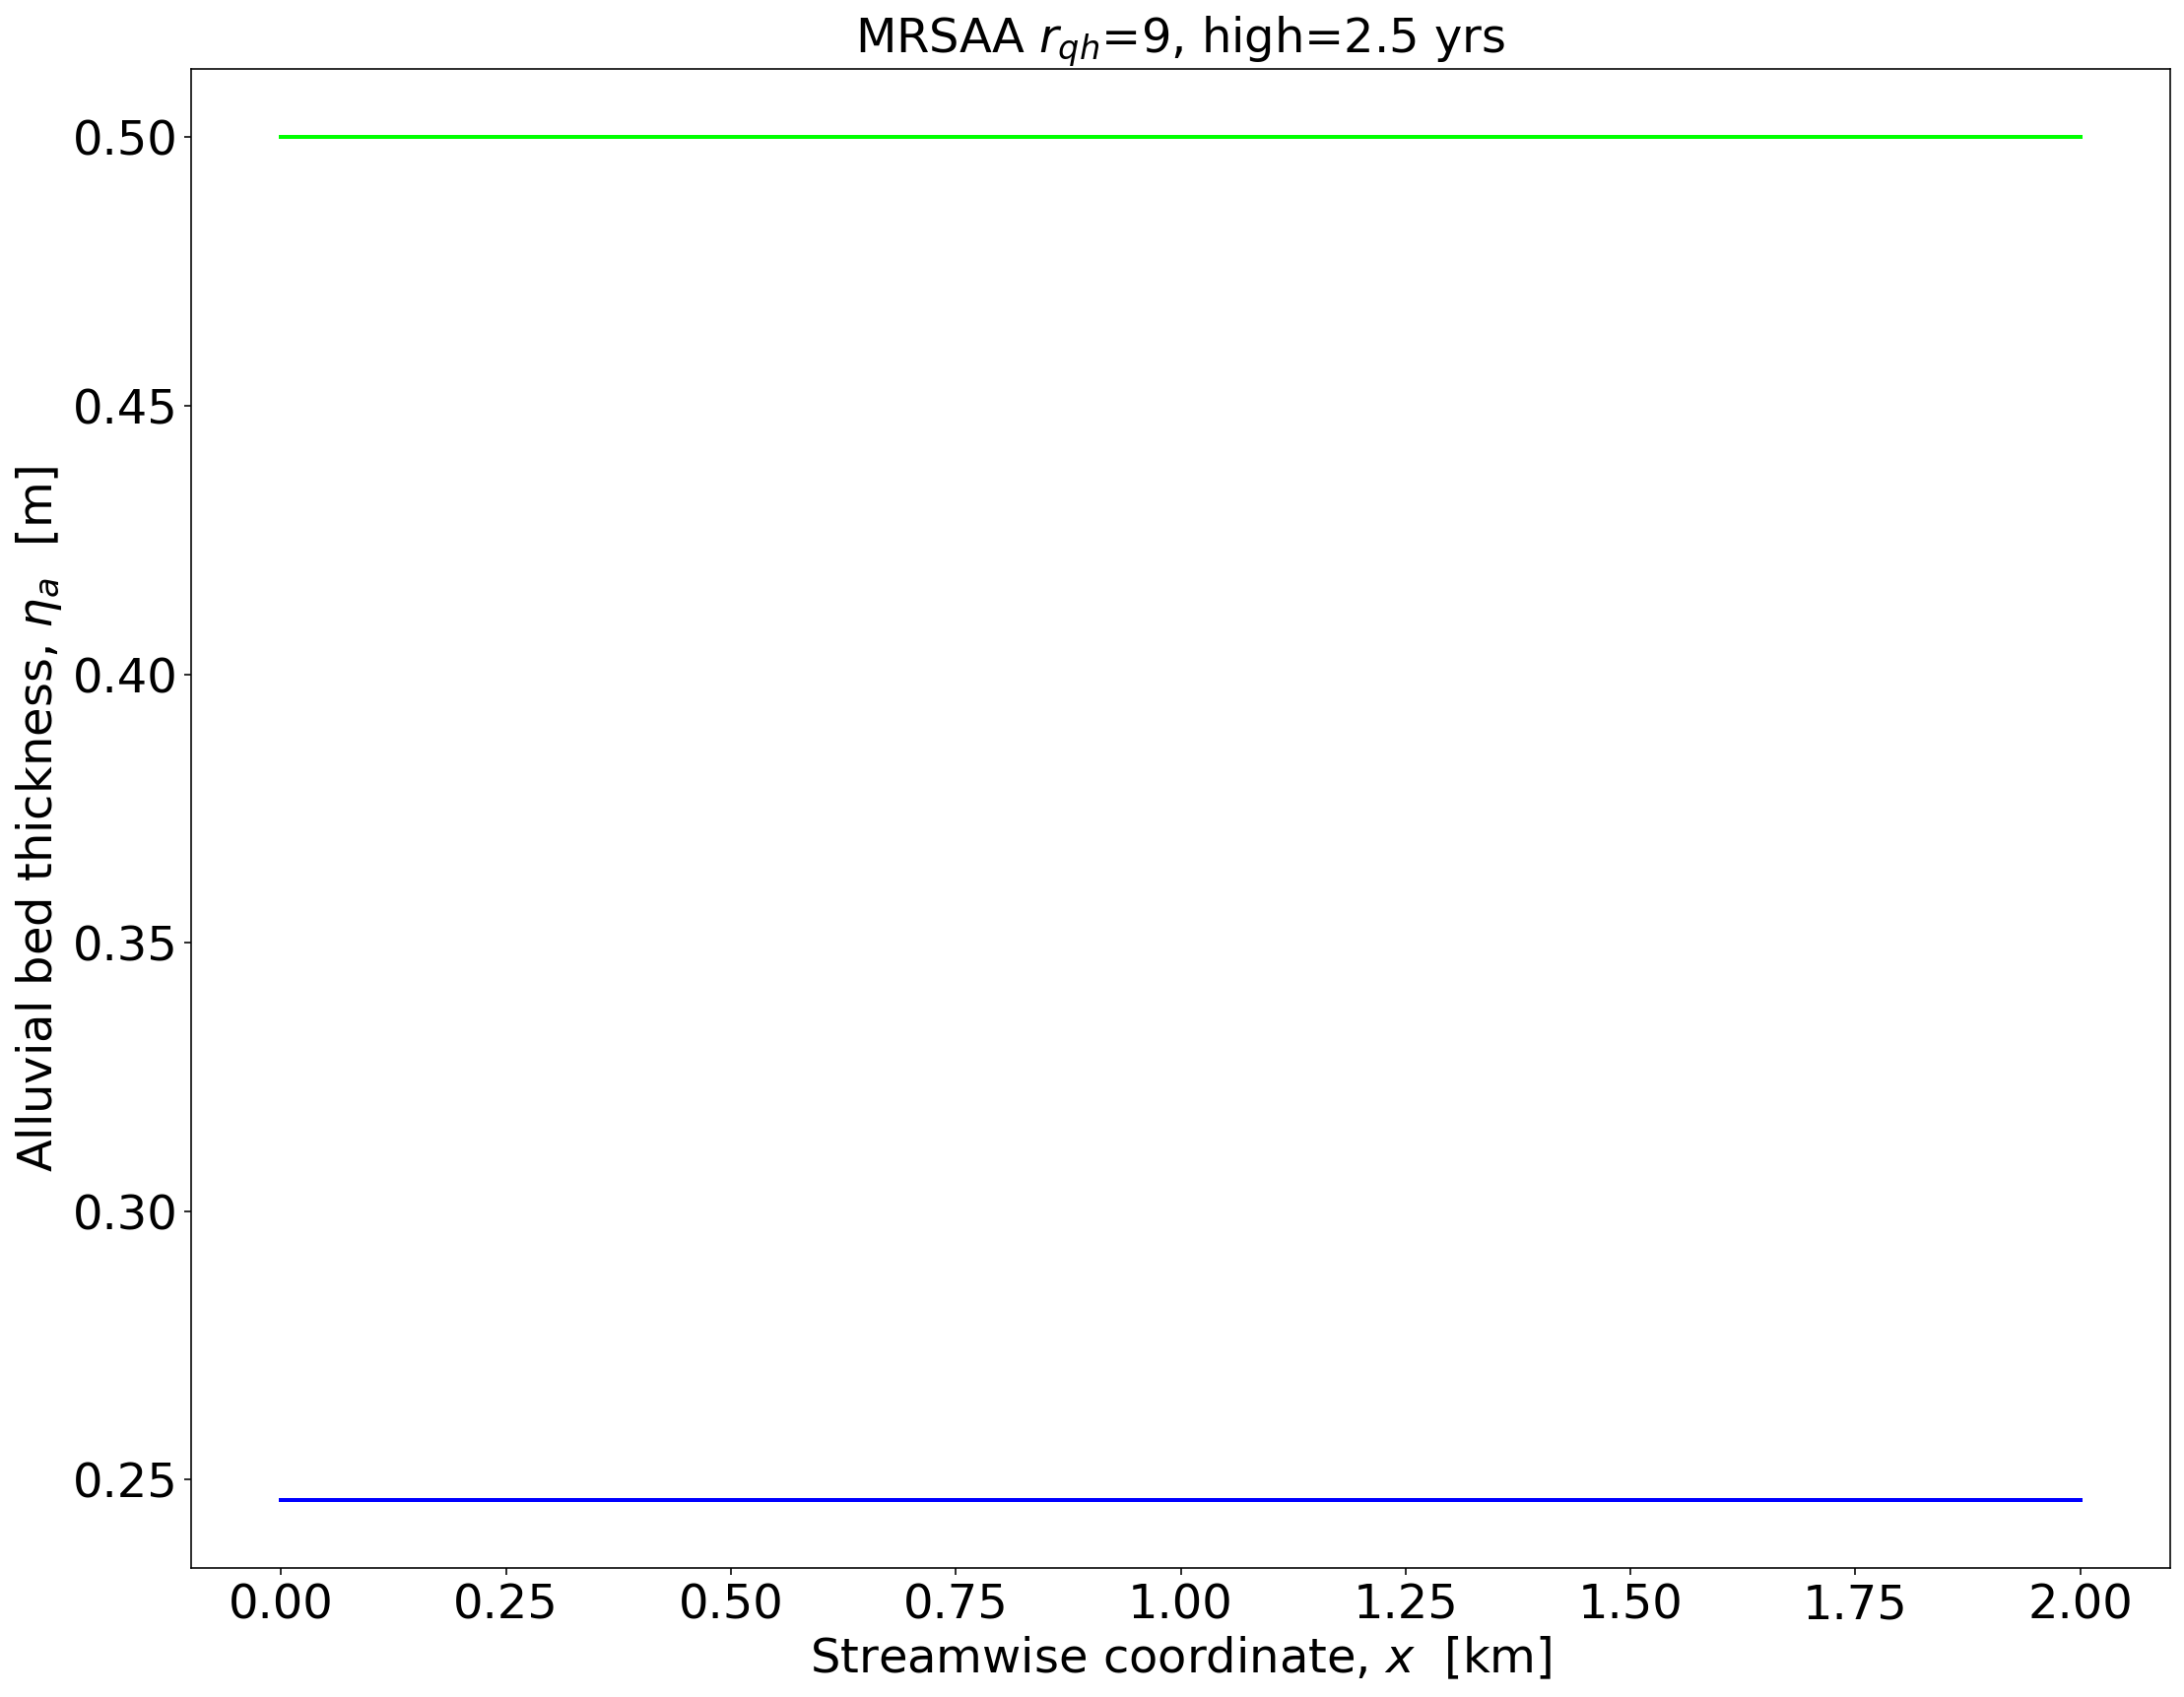

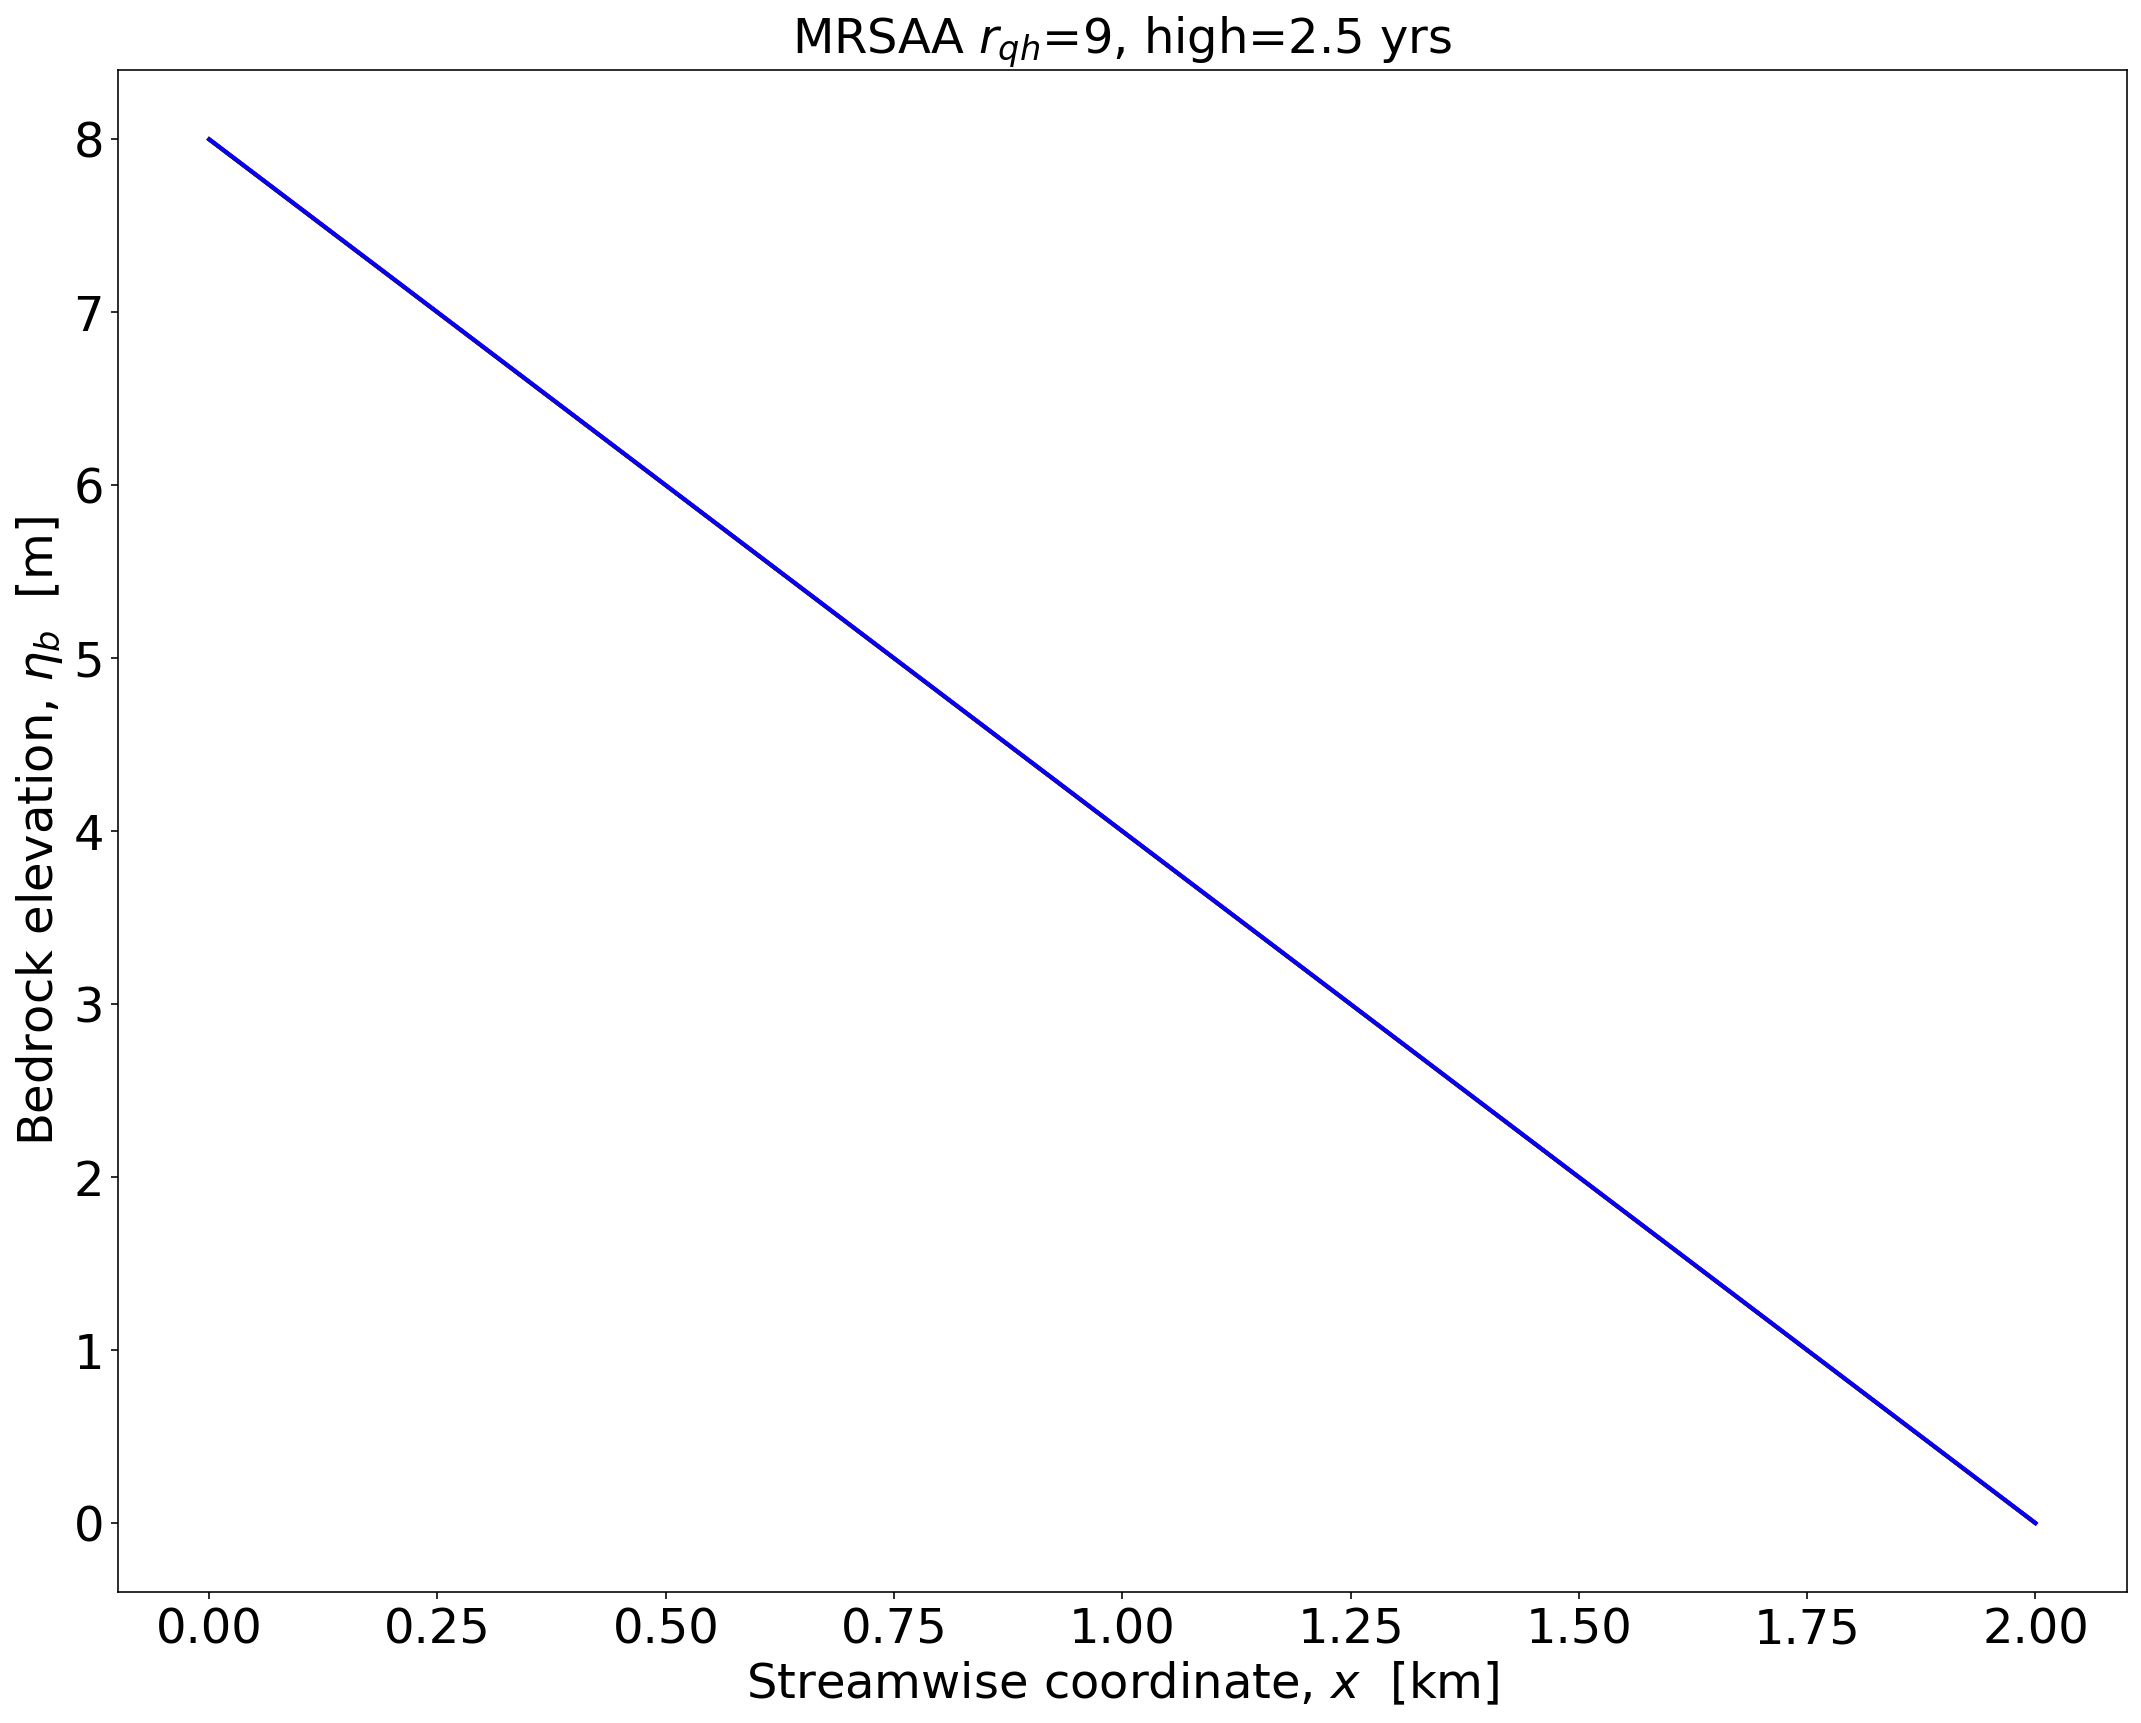

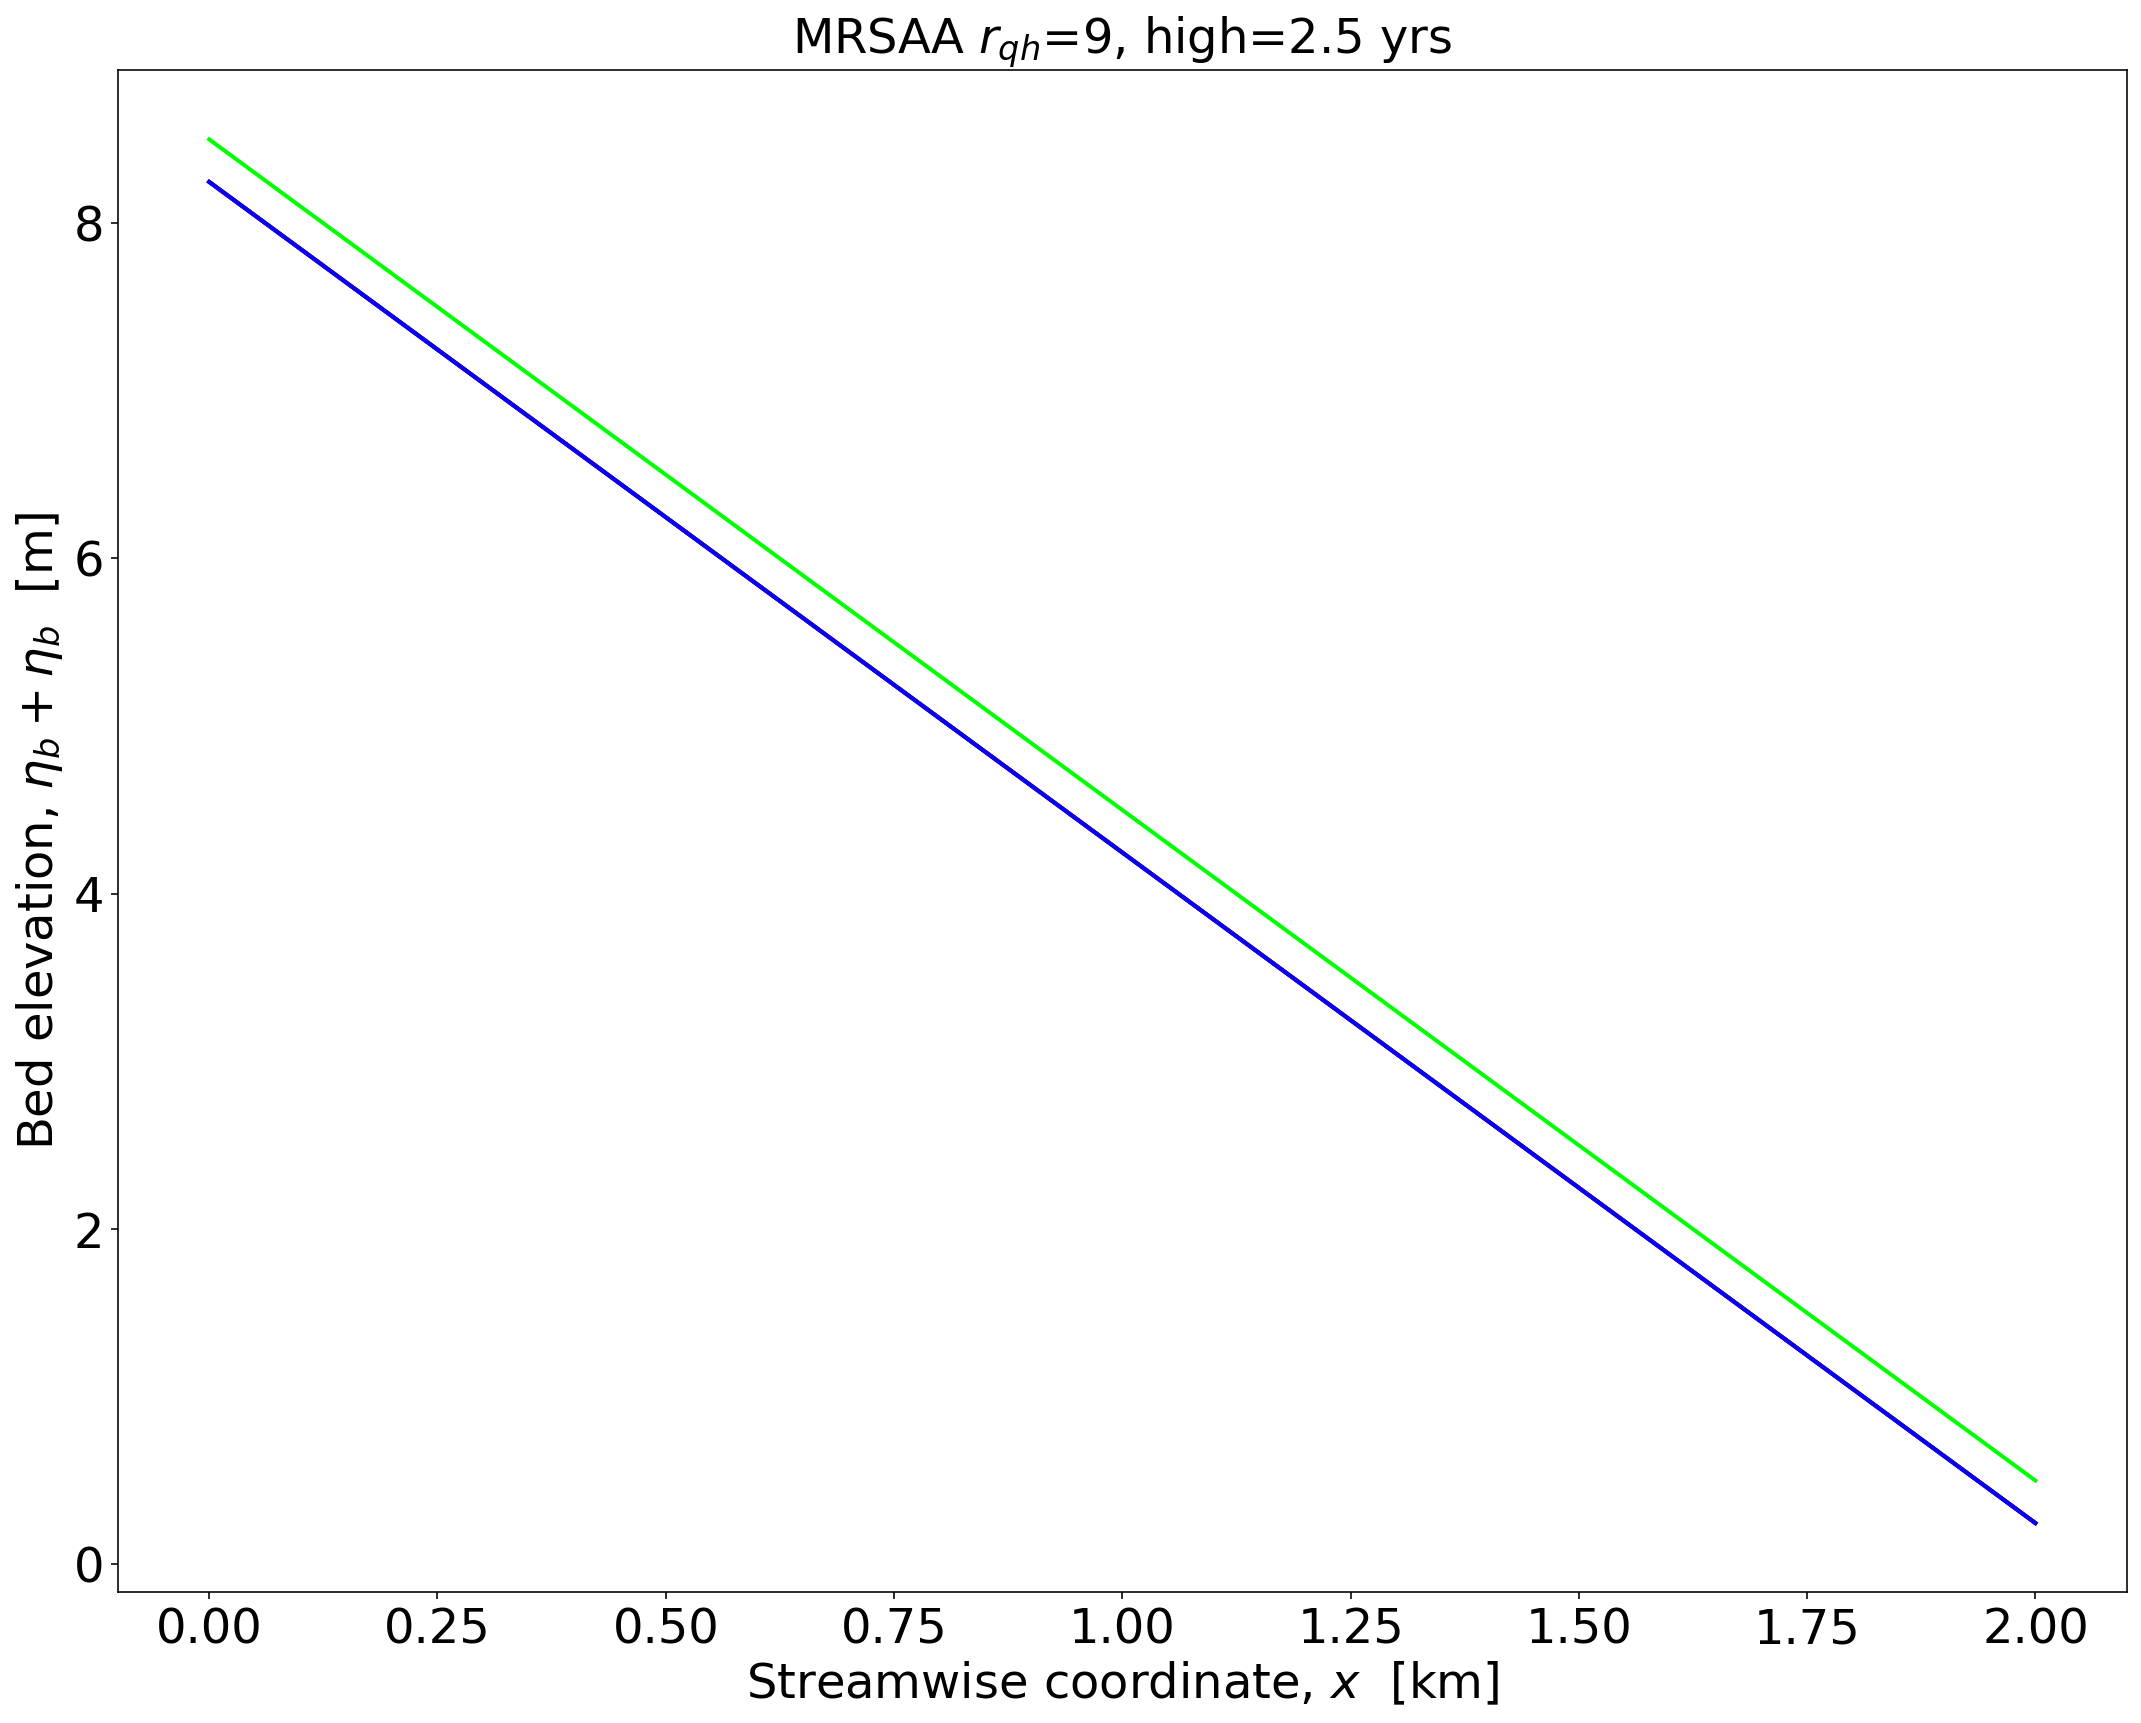

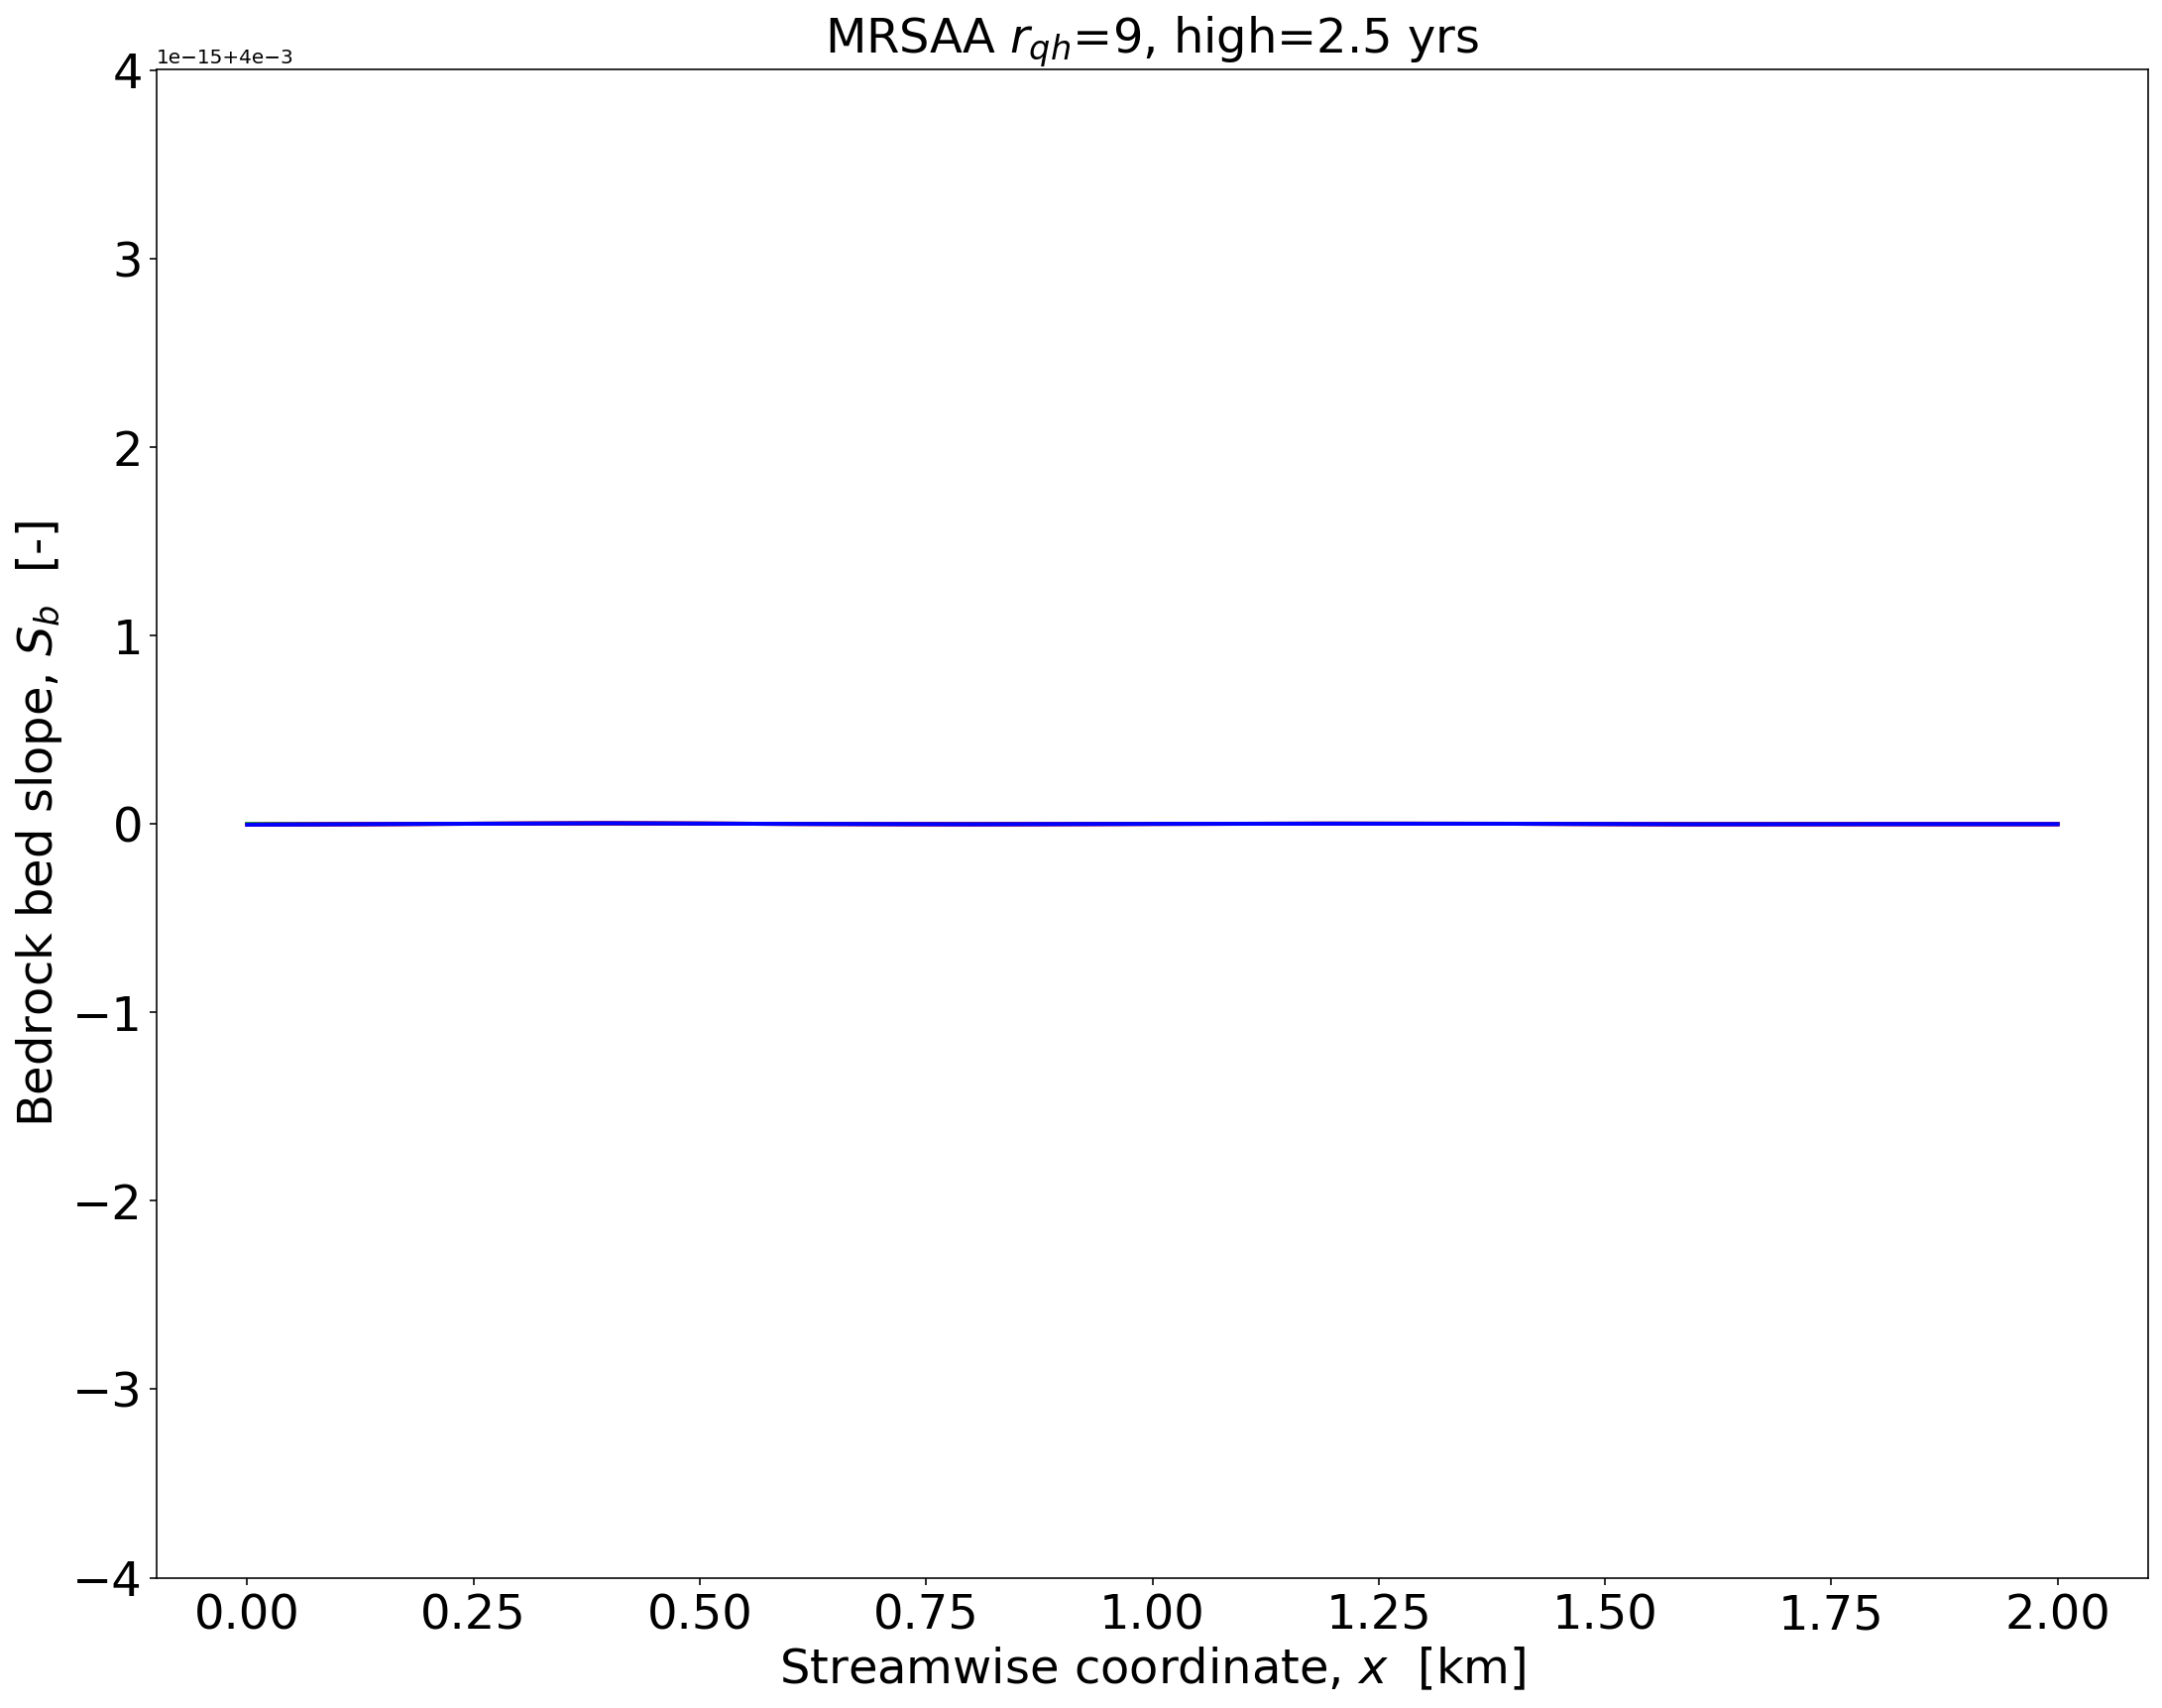

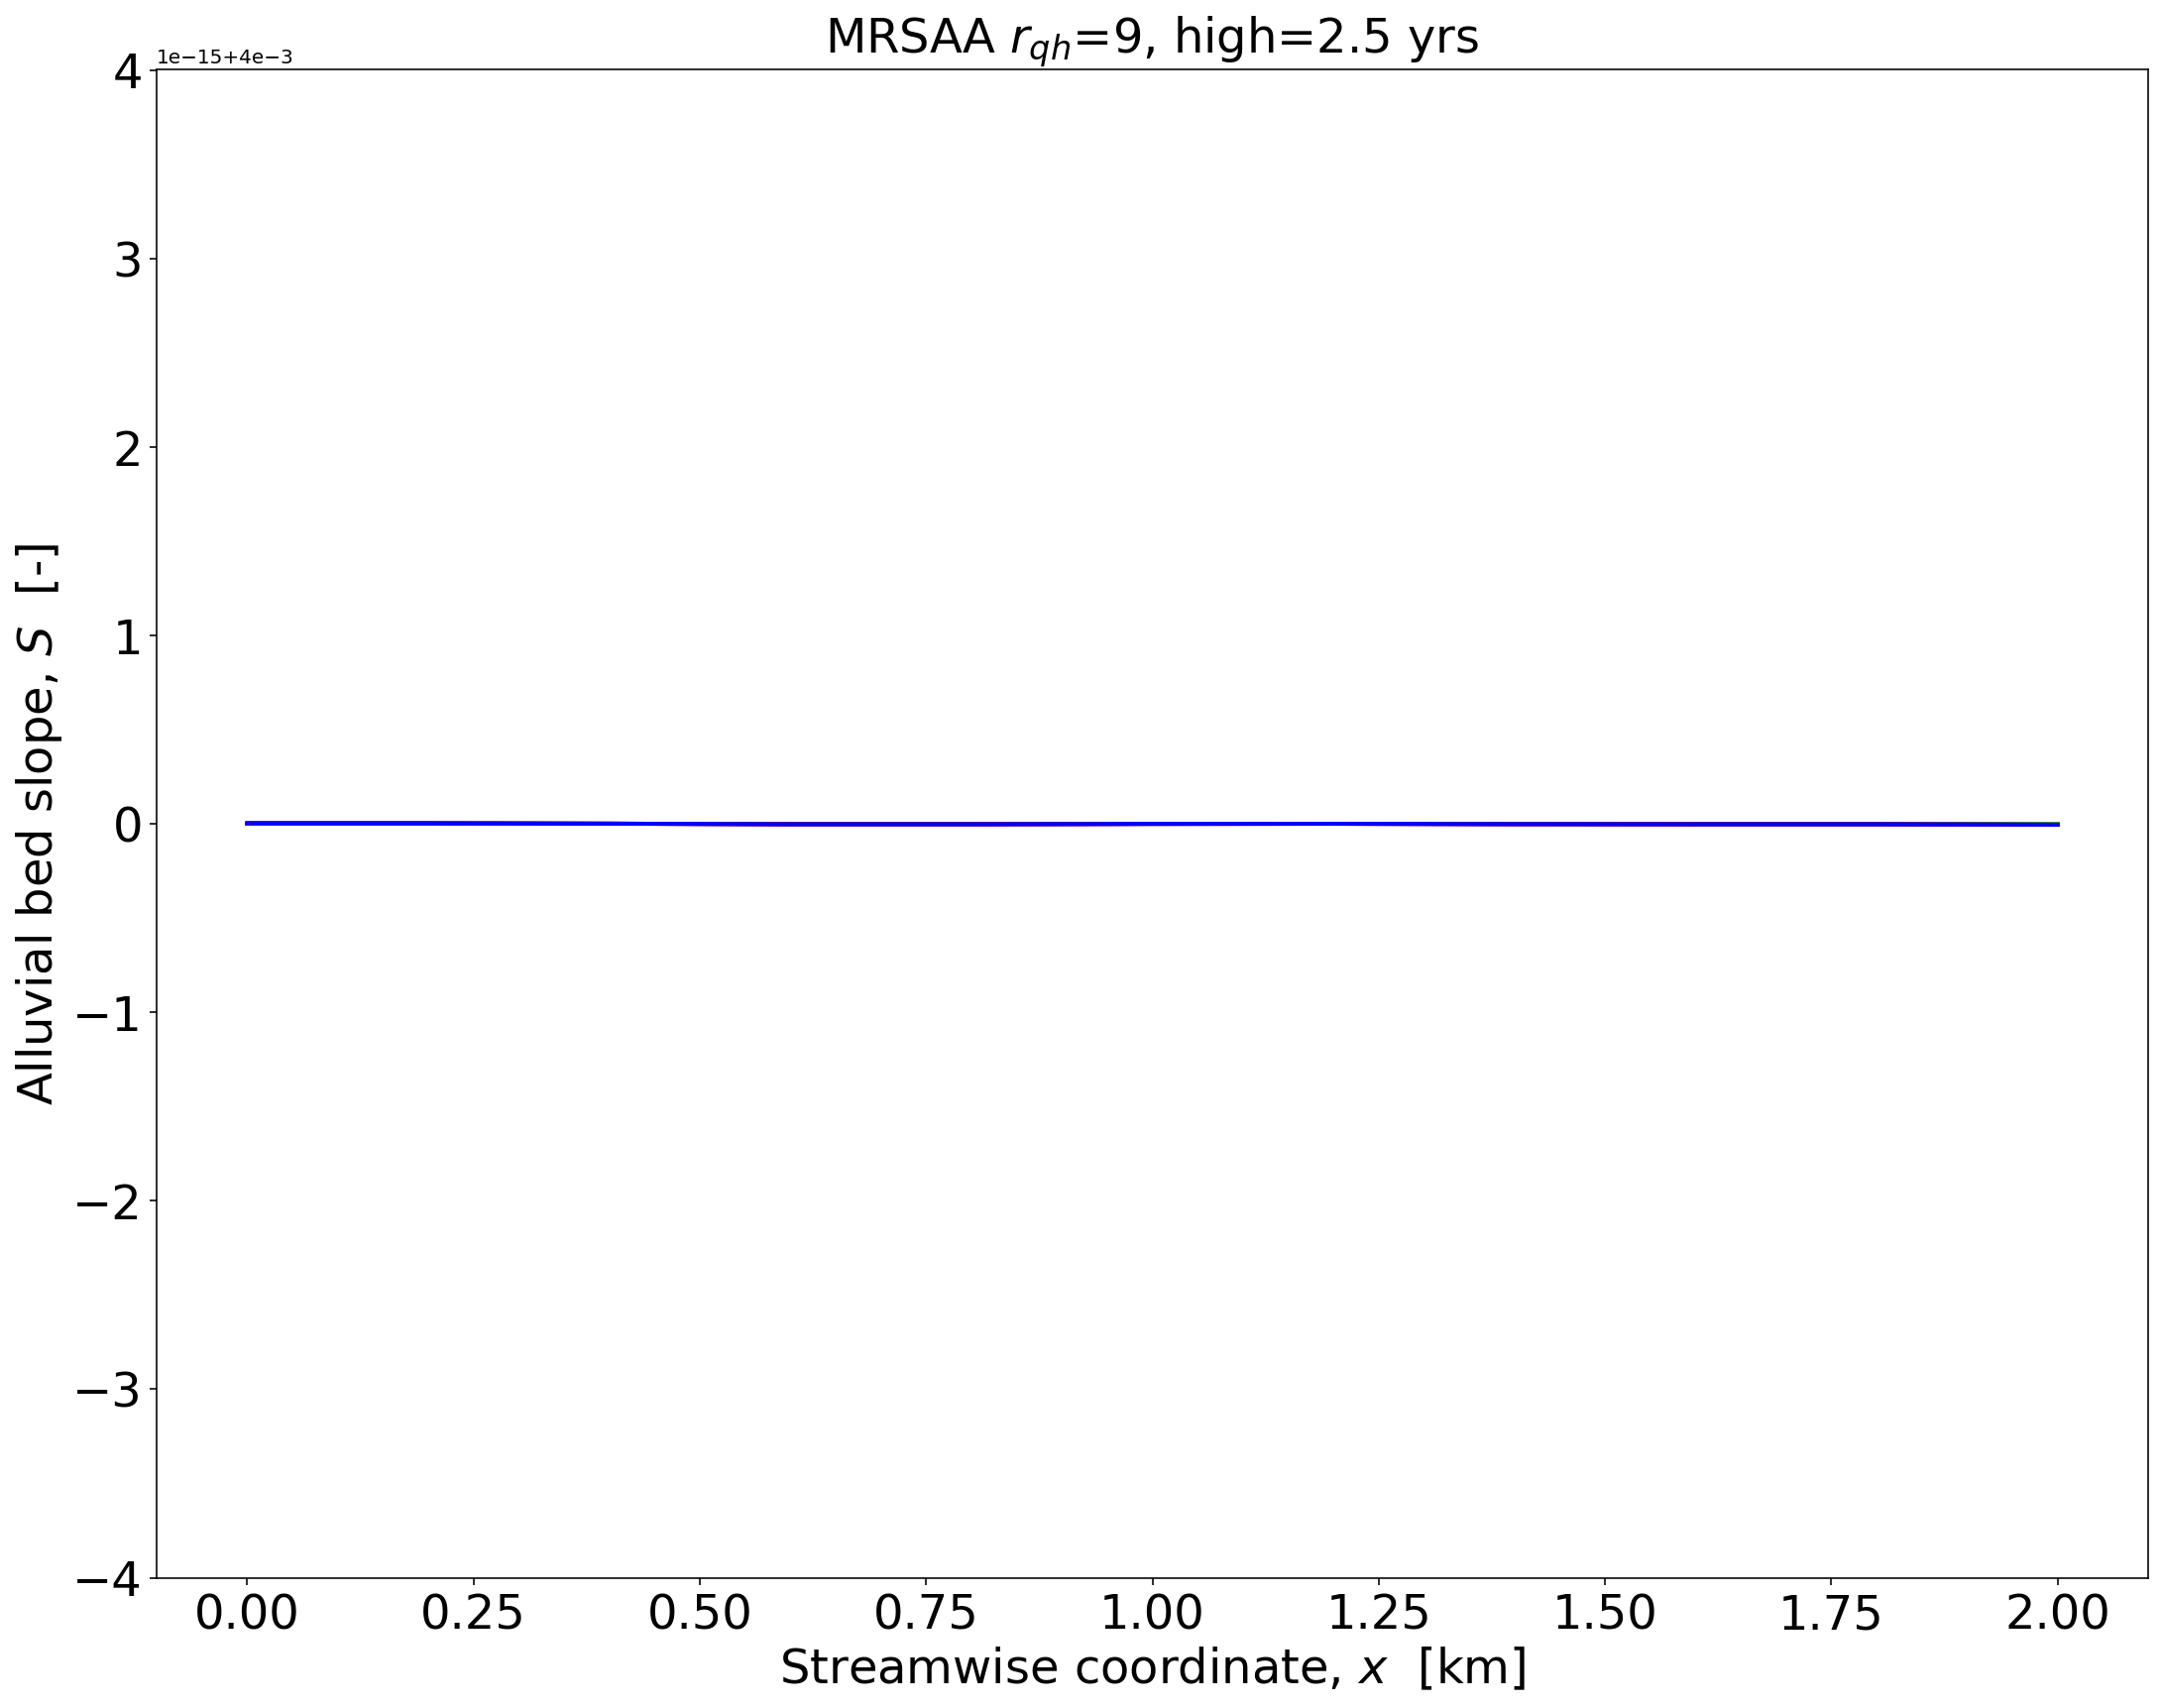

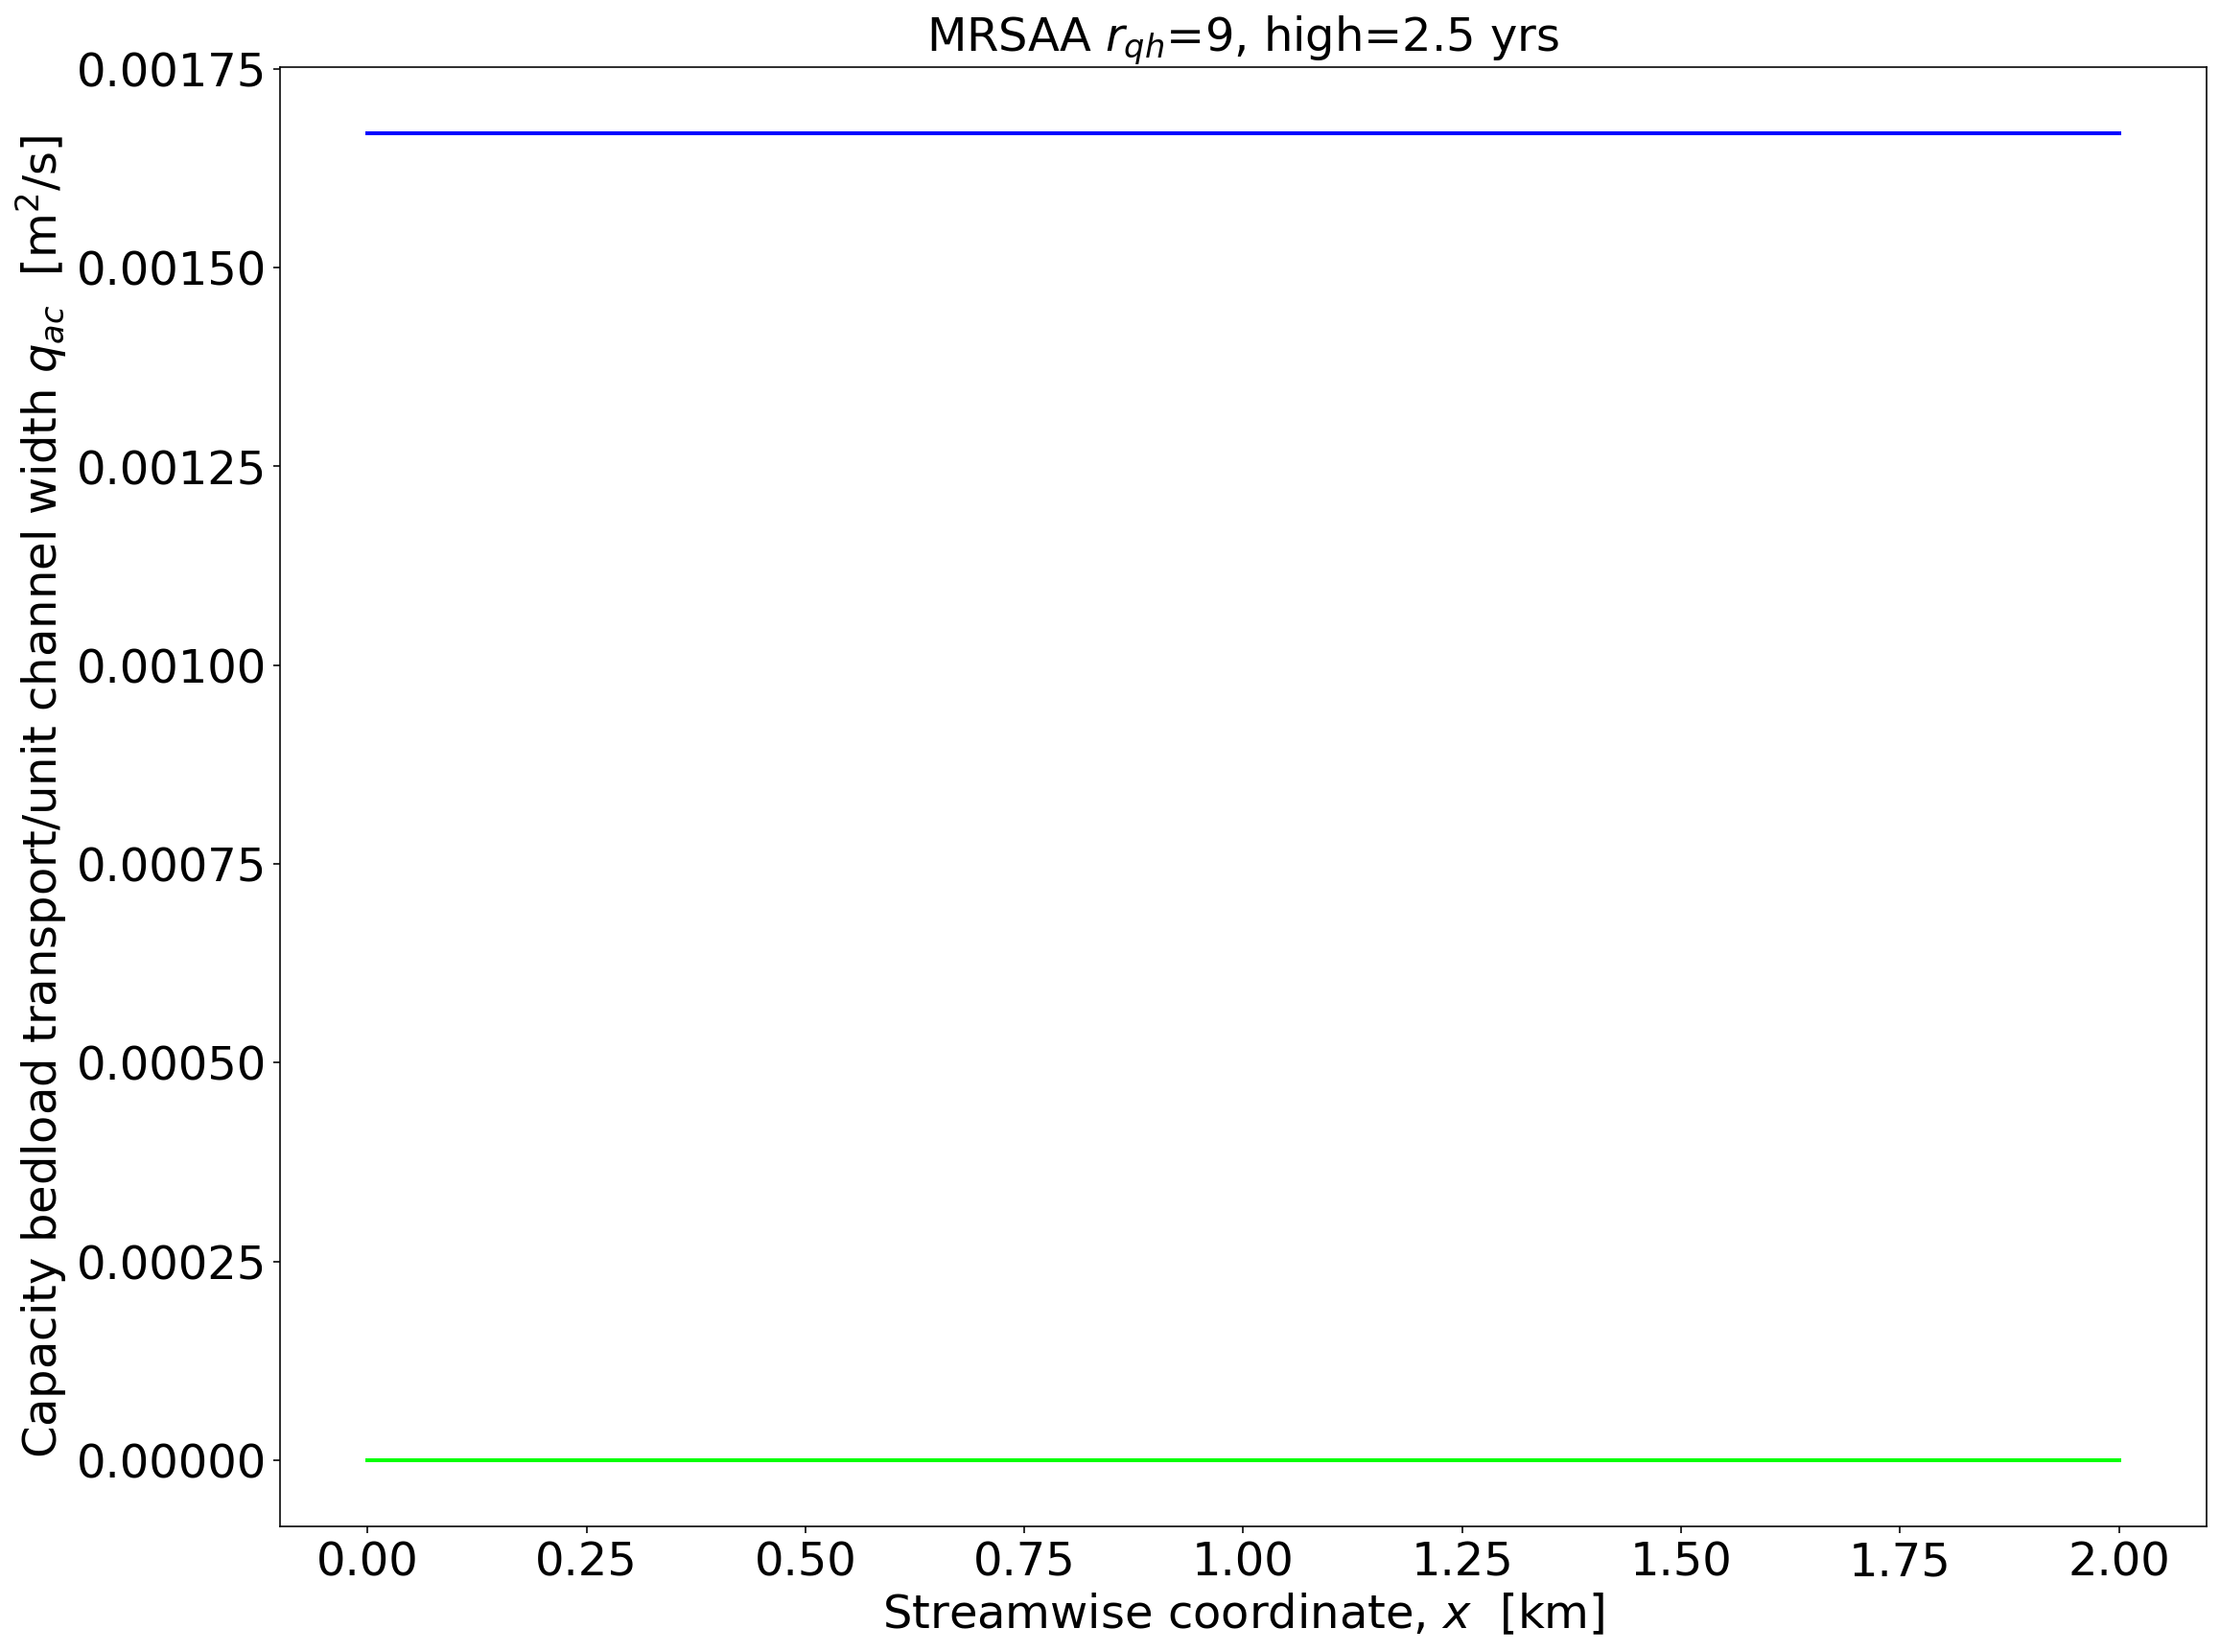

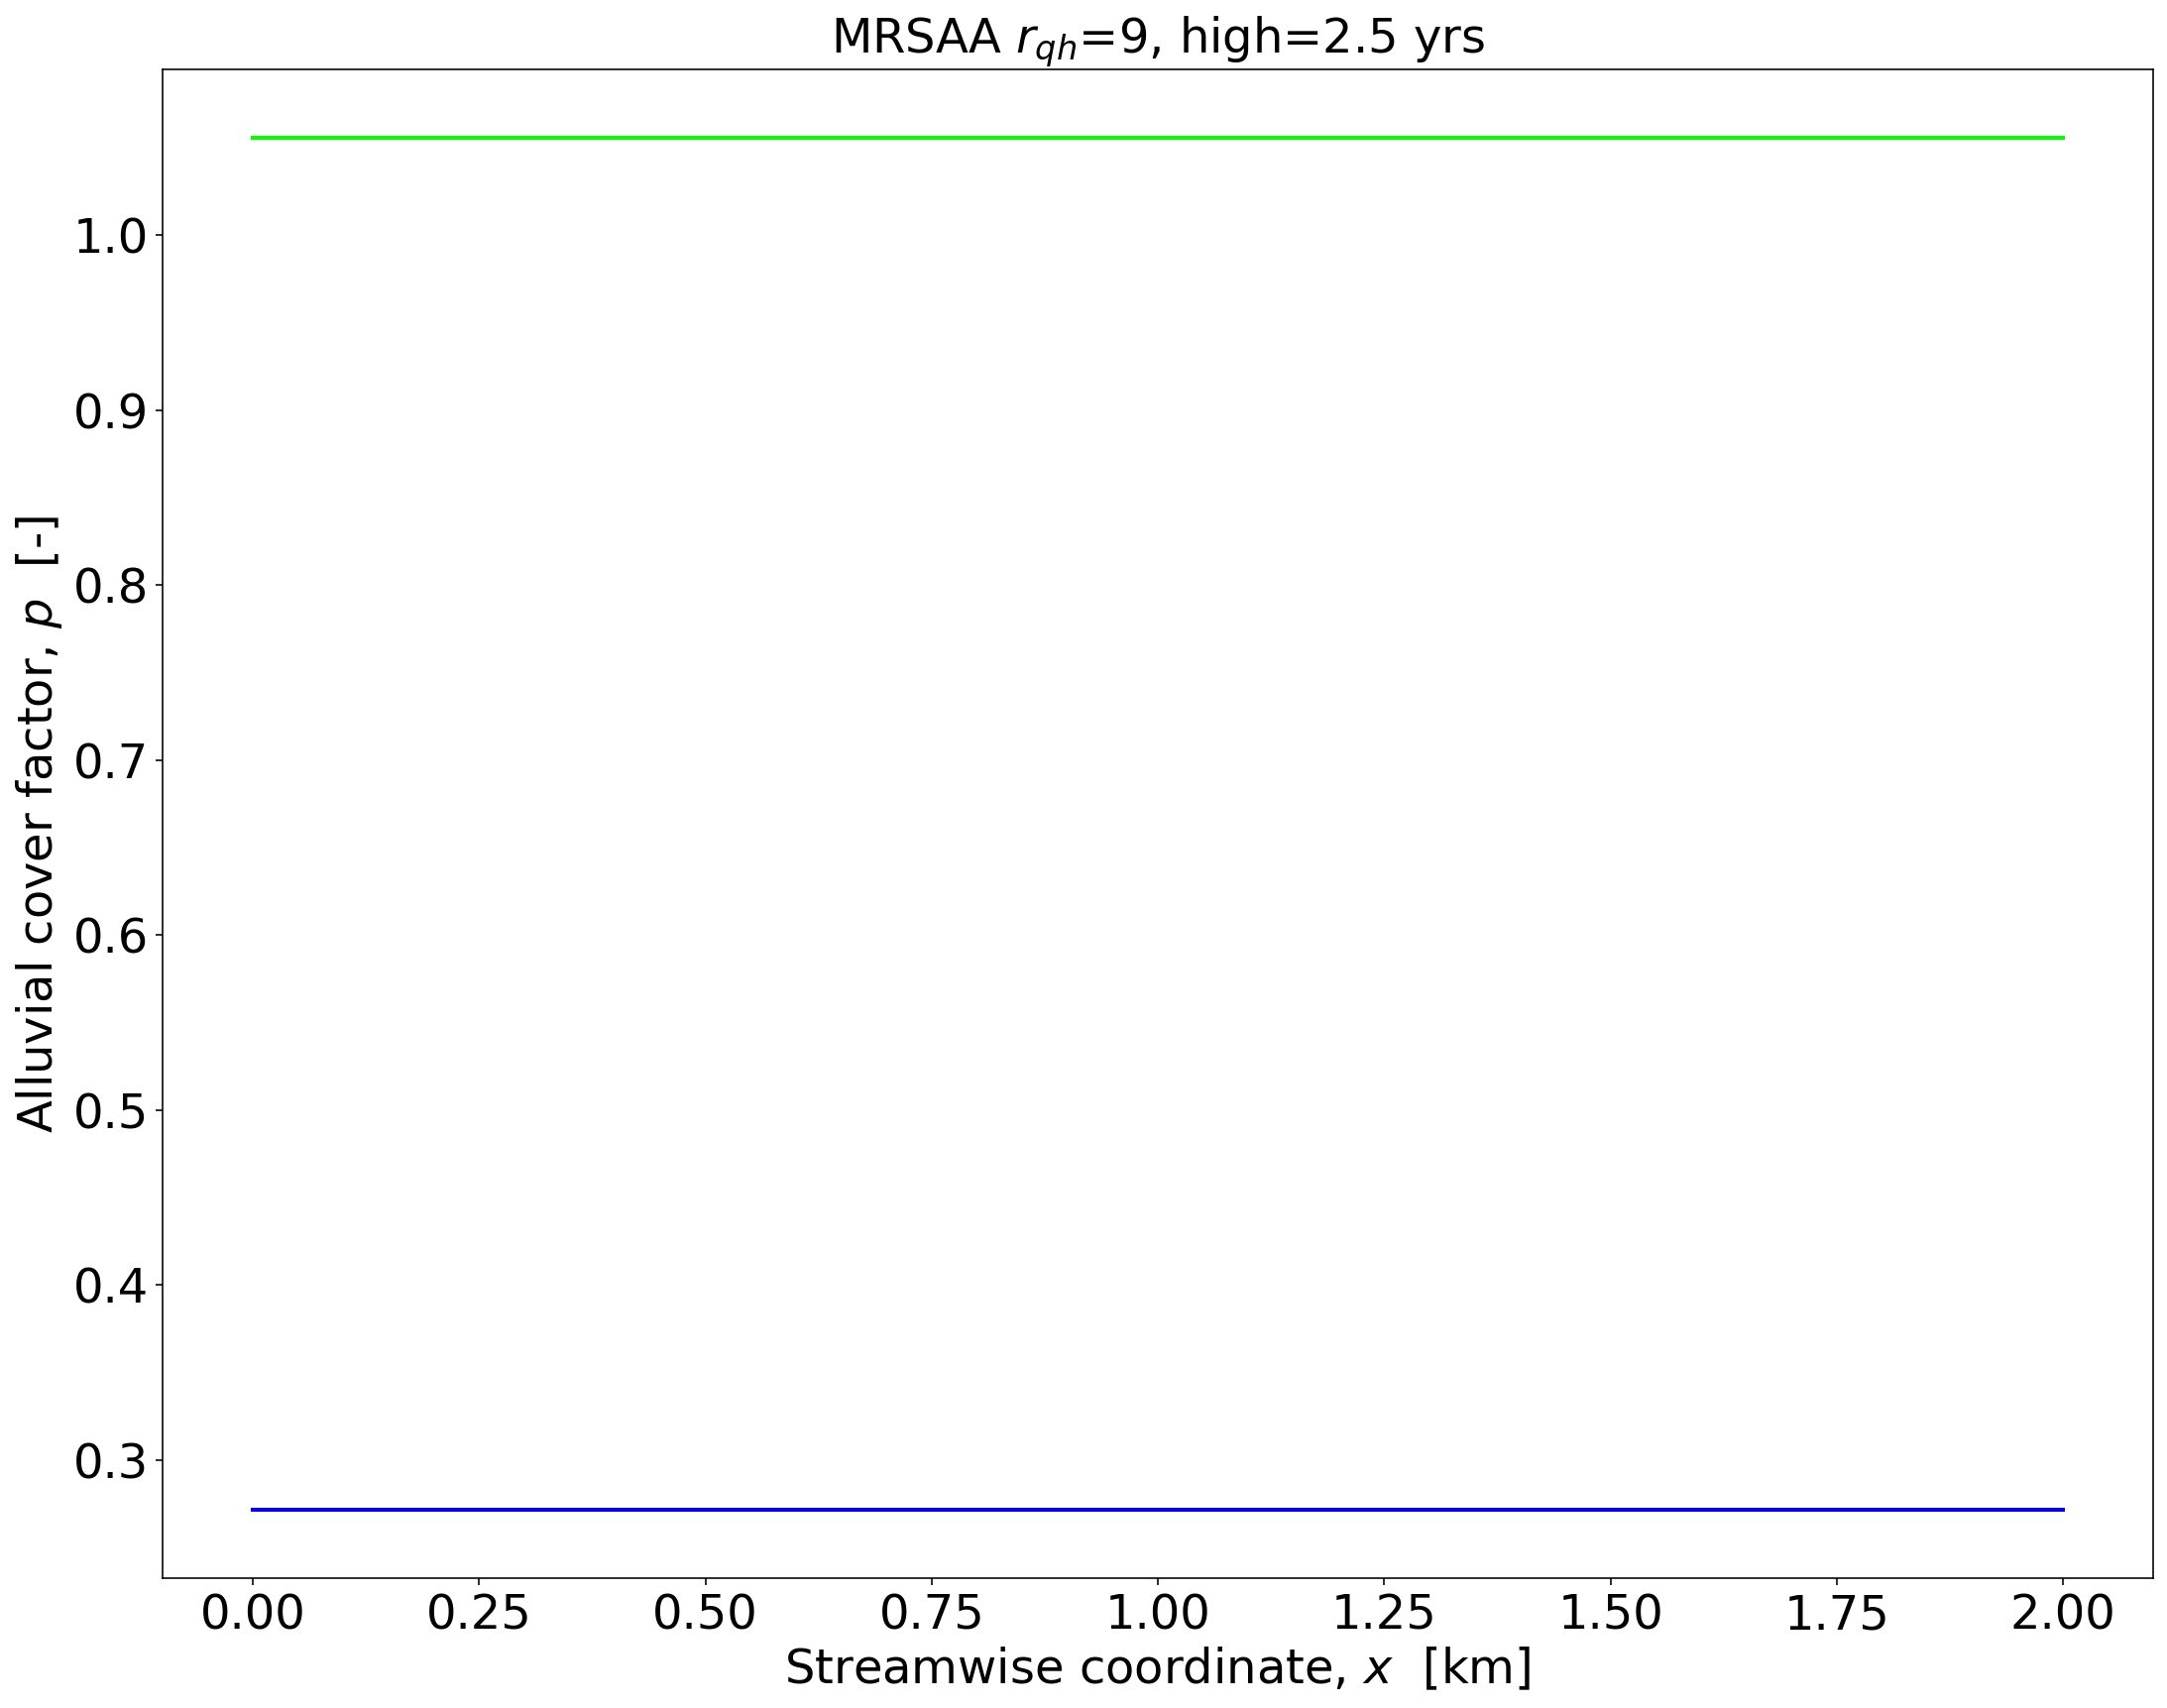

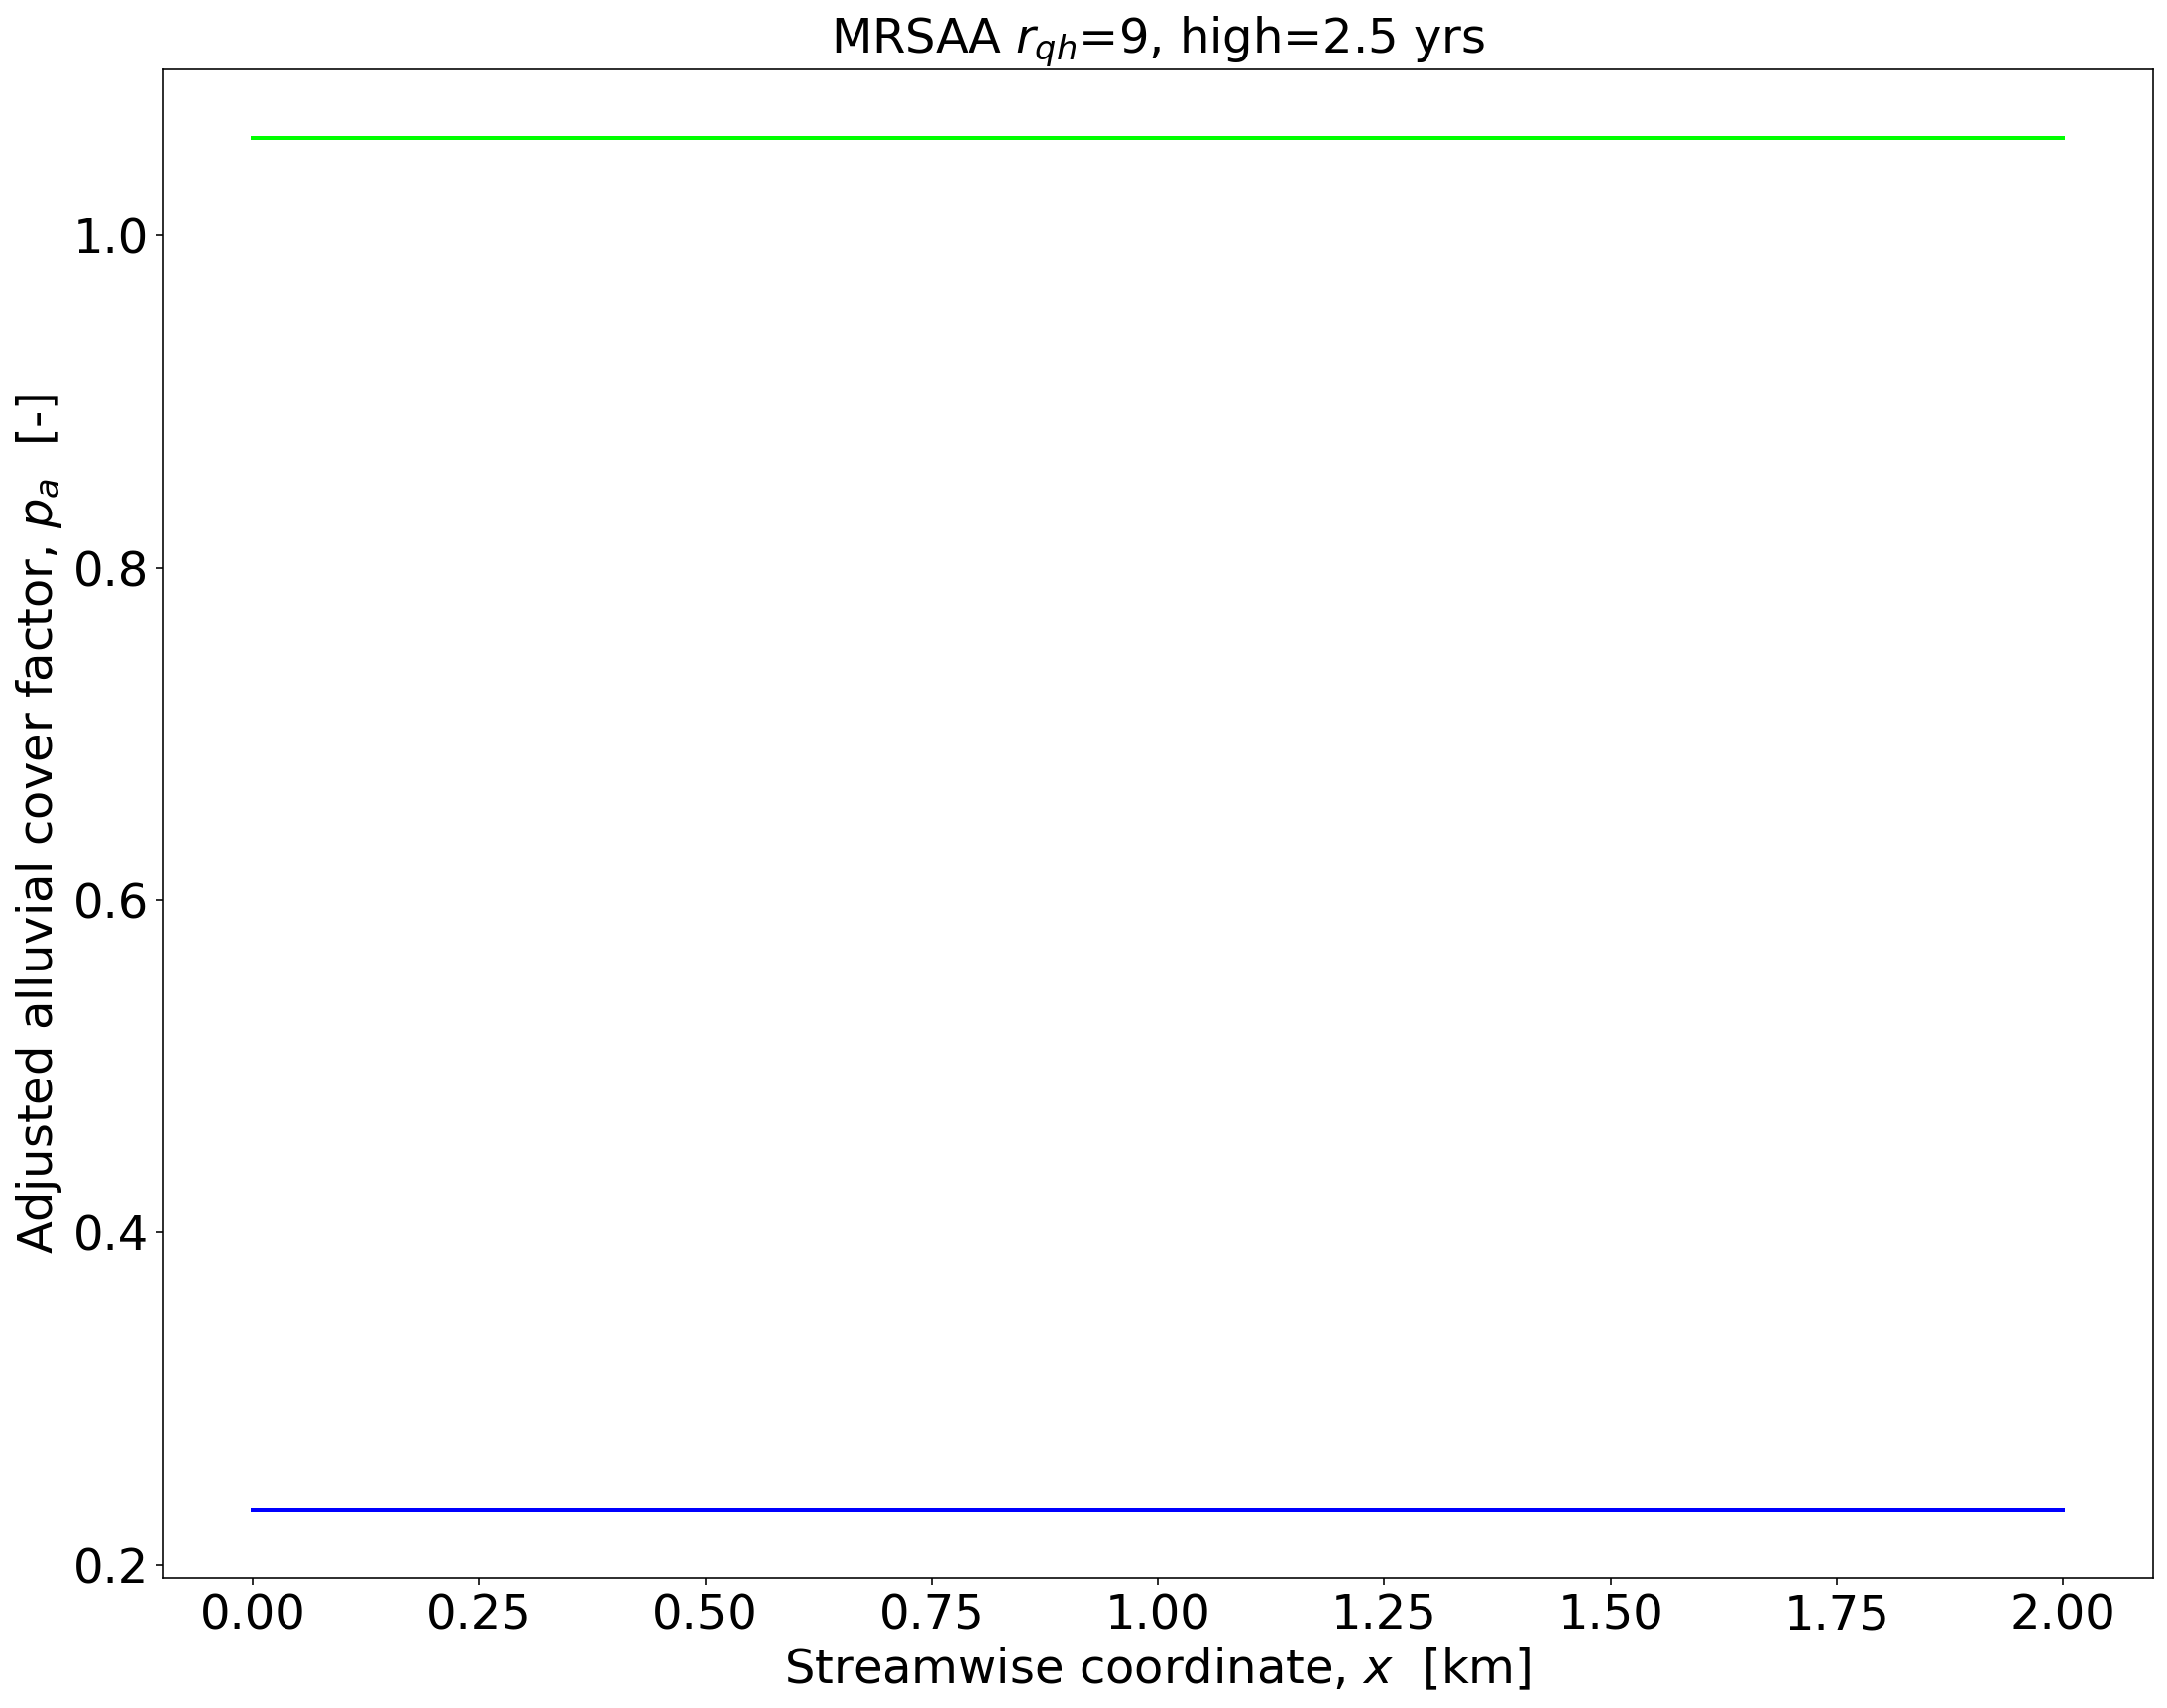

In [124]:
x_label = 'Streamwise coordinate, $x$  [km]'

for i in range(0,N_figures,1):
    # Choose data to plot
    list_data1[i]=np.zeros([M+2,Nprint+2])
    list_data1[i][0,:]=time
    list_data1[i][:,0]=dist
    list_data1[i][1:(M+2),1]=ini_data[i]
    list_data1[i][1:(M+2),2:(Nprint+2)]=list_data[i]
    
    # Create figure
    fh=plt.figure()
    ax=plt.gca()
    
    # Plot selected time slices
    for j in range (1,Nprint+2,N_subset_print_step):
        _ = plt.plot(xx/1000,list_data1[i][1:,j], lw=2)
        
    # Colorize lines in a meaningful, progressive fashion
#     colormap = plt.cm.viridis   
    colormap = plt.cm.brg   
    # Forward
#     colors = [colormap(idx) for idx in np.linspace(0,1,len(ax.lines))]
    # Reversed
    colors = [colormap(idx) for idx in np.linspace(1,0,len(ax.lines))]
    for idx,line in enumerate(ax.lines):
        line.set_color(colors[idx])
        
    # Label axes etc
    _ = plt.xlabel(x_label,fontsize=24)
    _ = plt.ylabel(name1[i],fontsize=24)
    if not do_random:
        _= plt.title('MRSAA $r_{qh}$='+str(rqh)
                     +', high='+str(high_year)+' yrs',fontsize=24)
    else:
        _ = plt.title('MRSAA $r_{qh}$='+str(begin_random)+'-'+str(stop_random)
                 +', high='+str(high_year)+' yrs',fontsize=24)
    _ = ax.tick_params(labelsize=24)
    
    # Export graphs
    #_ = plt.savefig(name[i]+'_'+str(int(Nwant))+'.png')
    #_ = plt.savefig(name[i]+'_'+str(int(Nwant))+'.pdf')
    _ = plt.show()
    

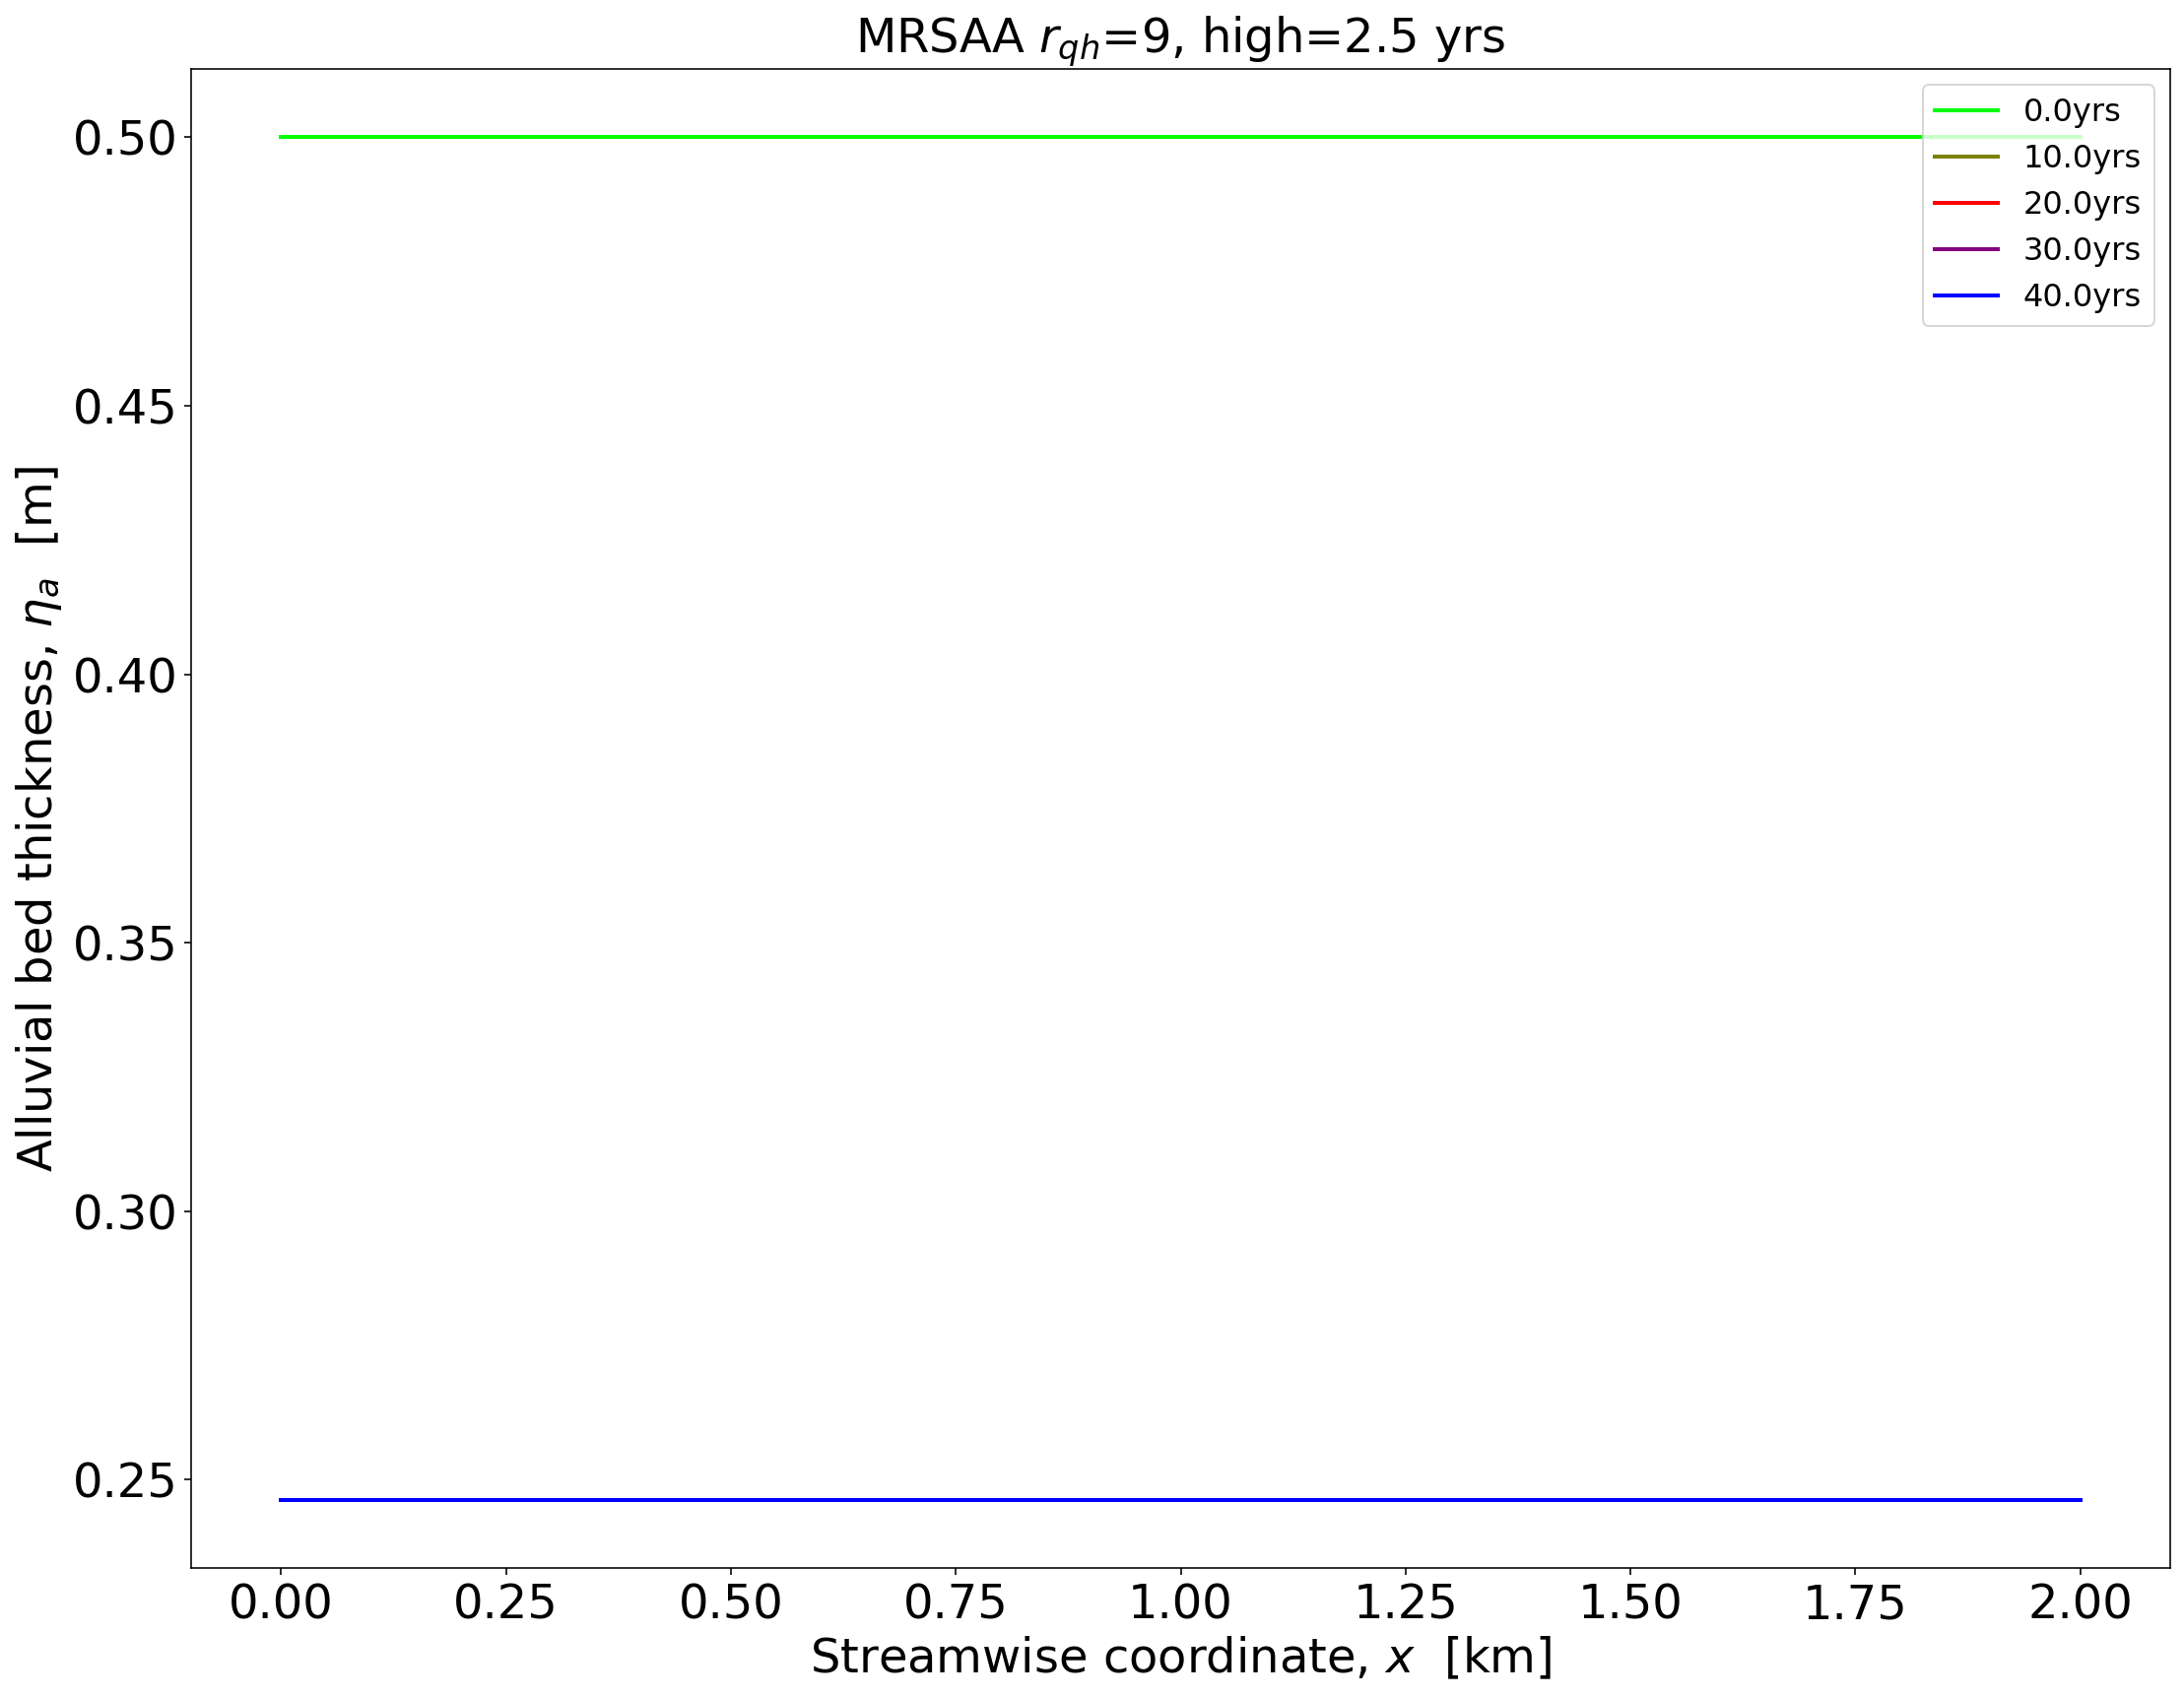

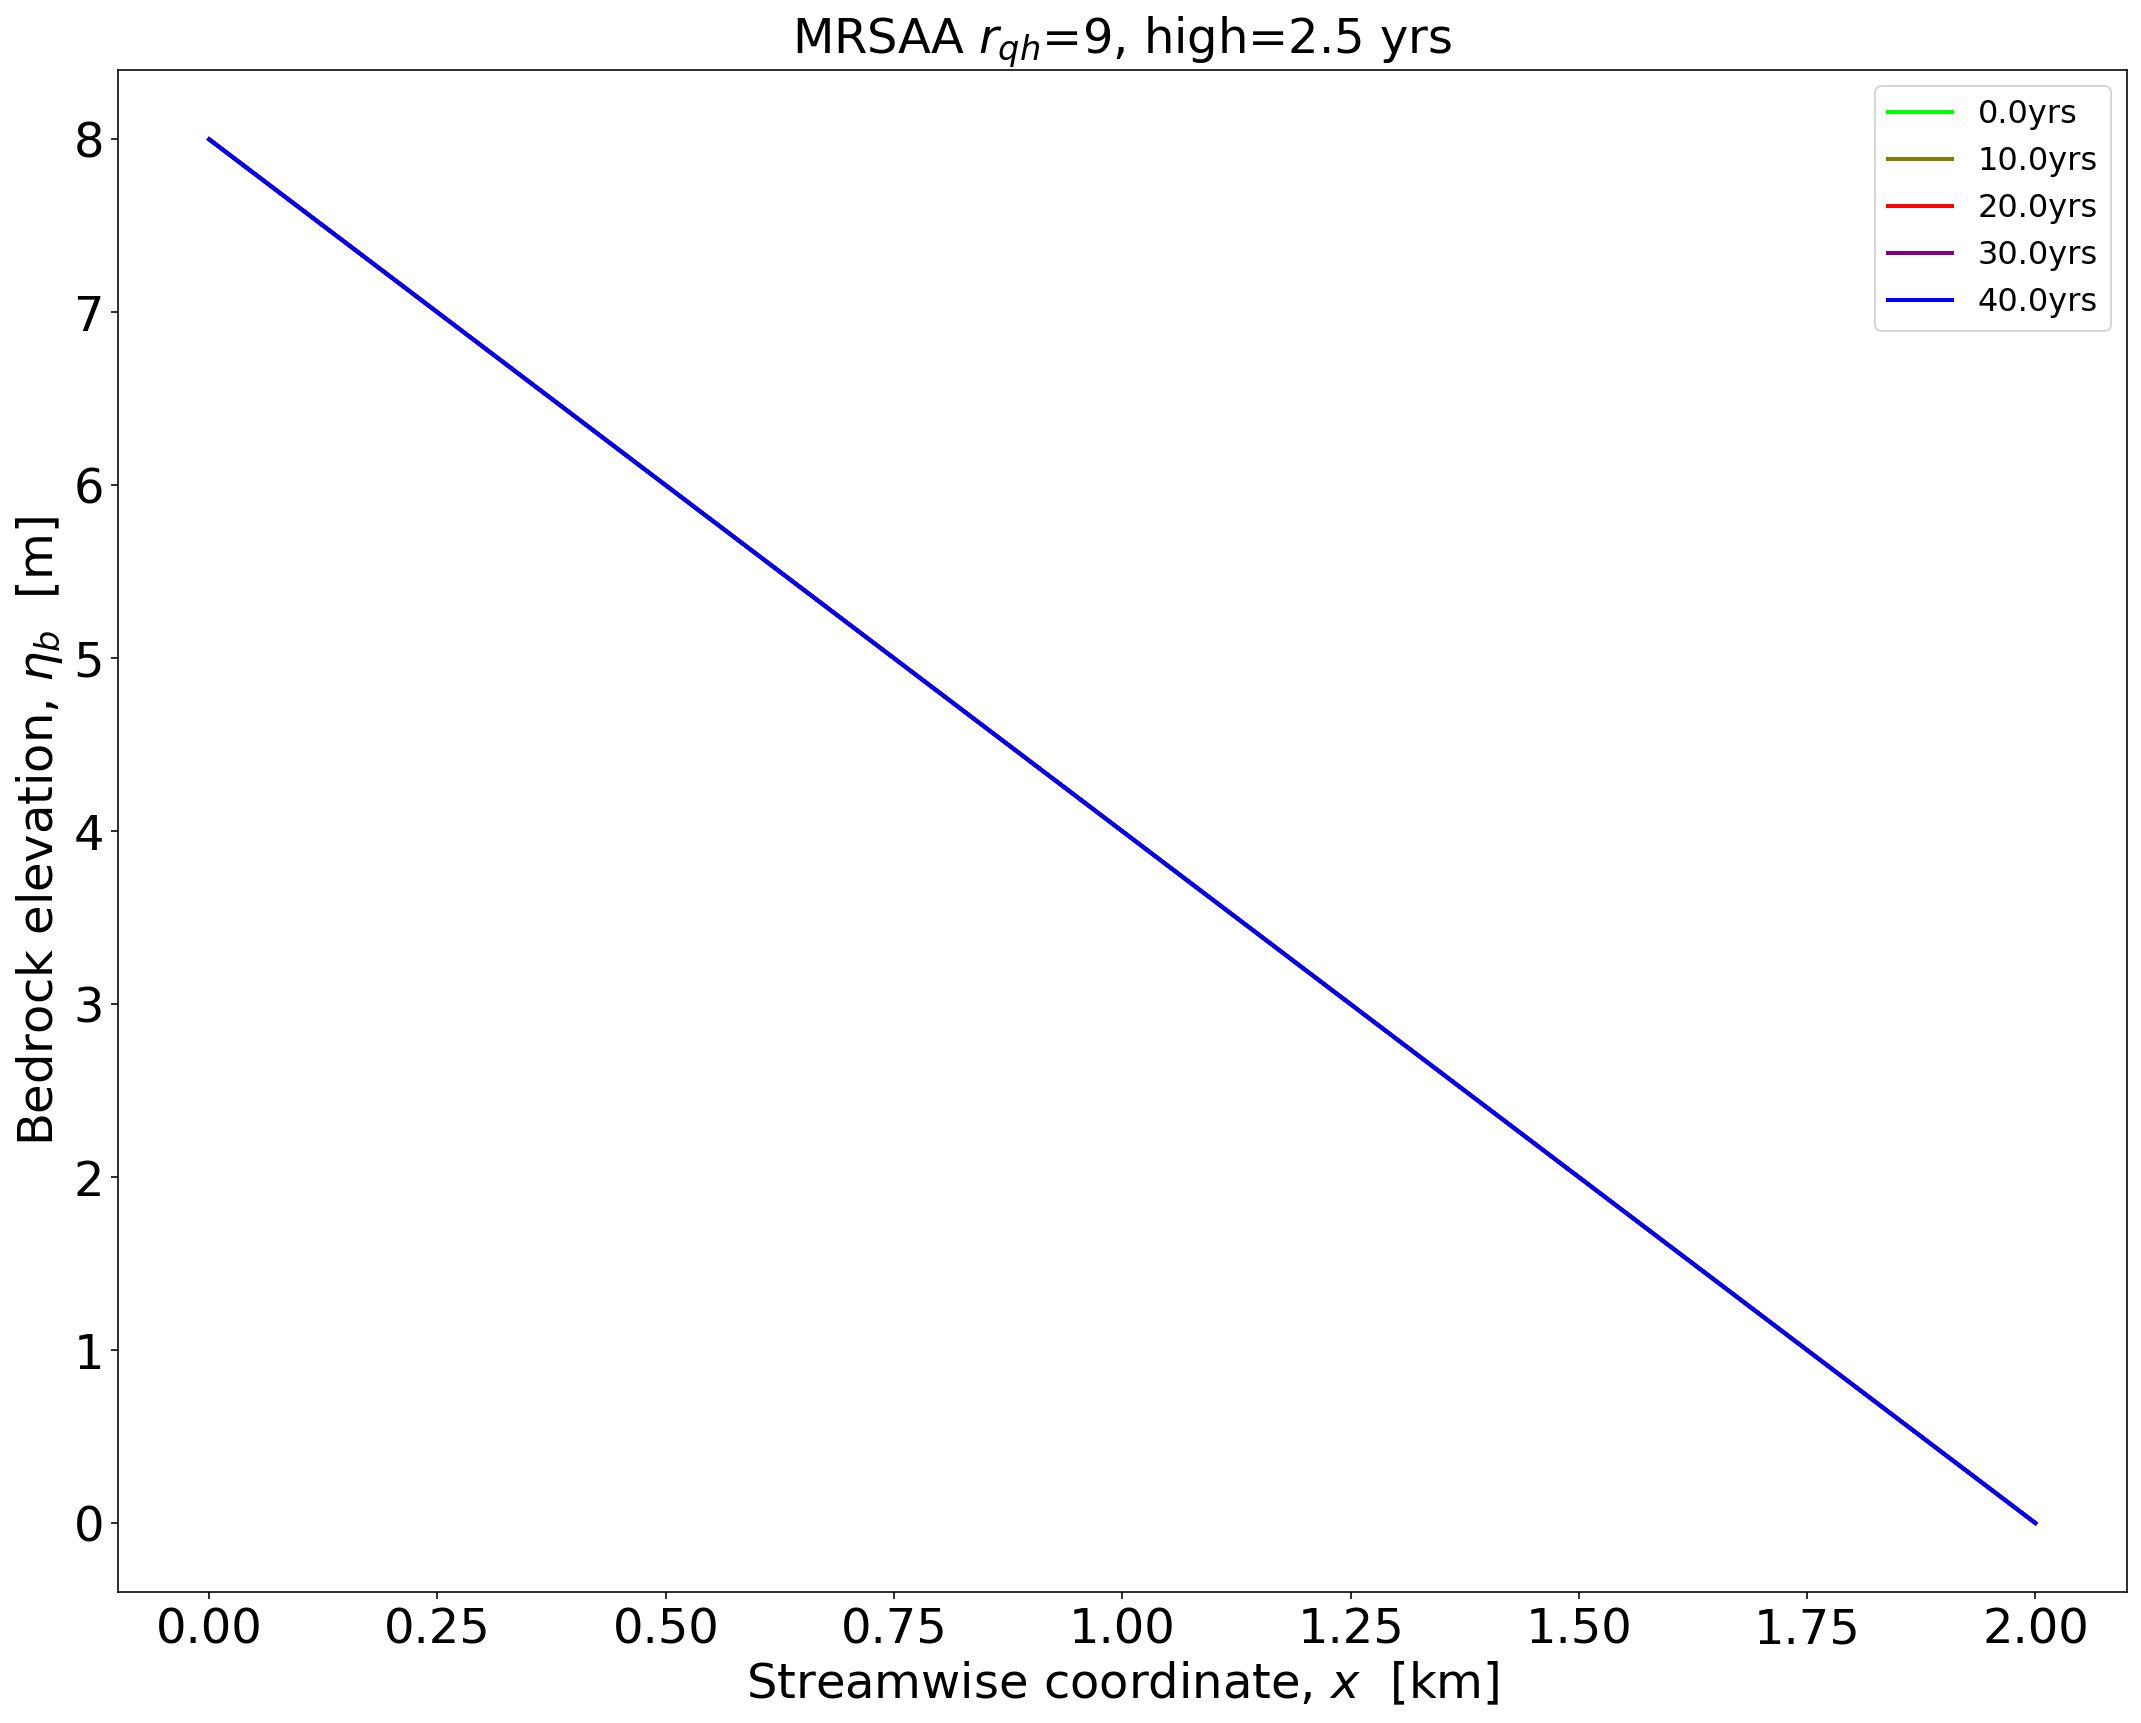

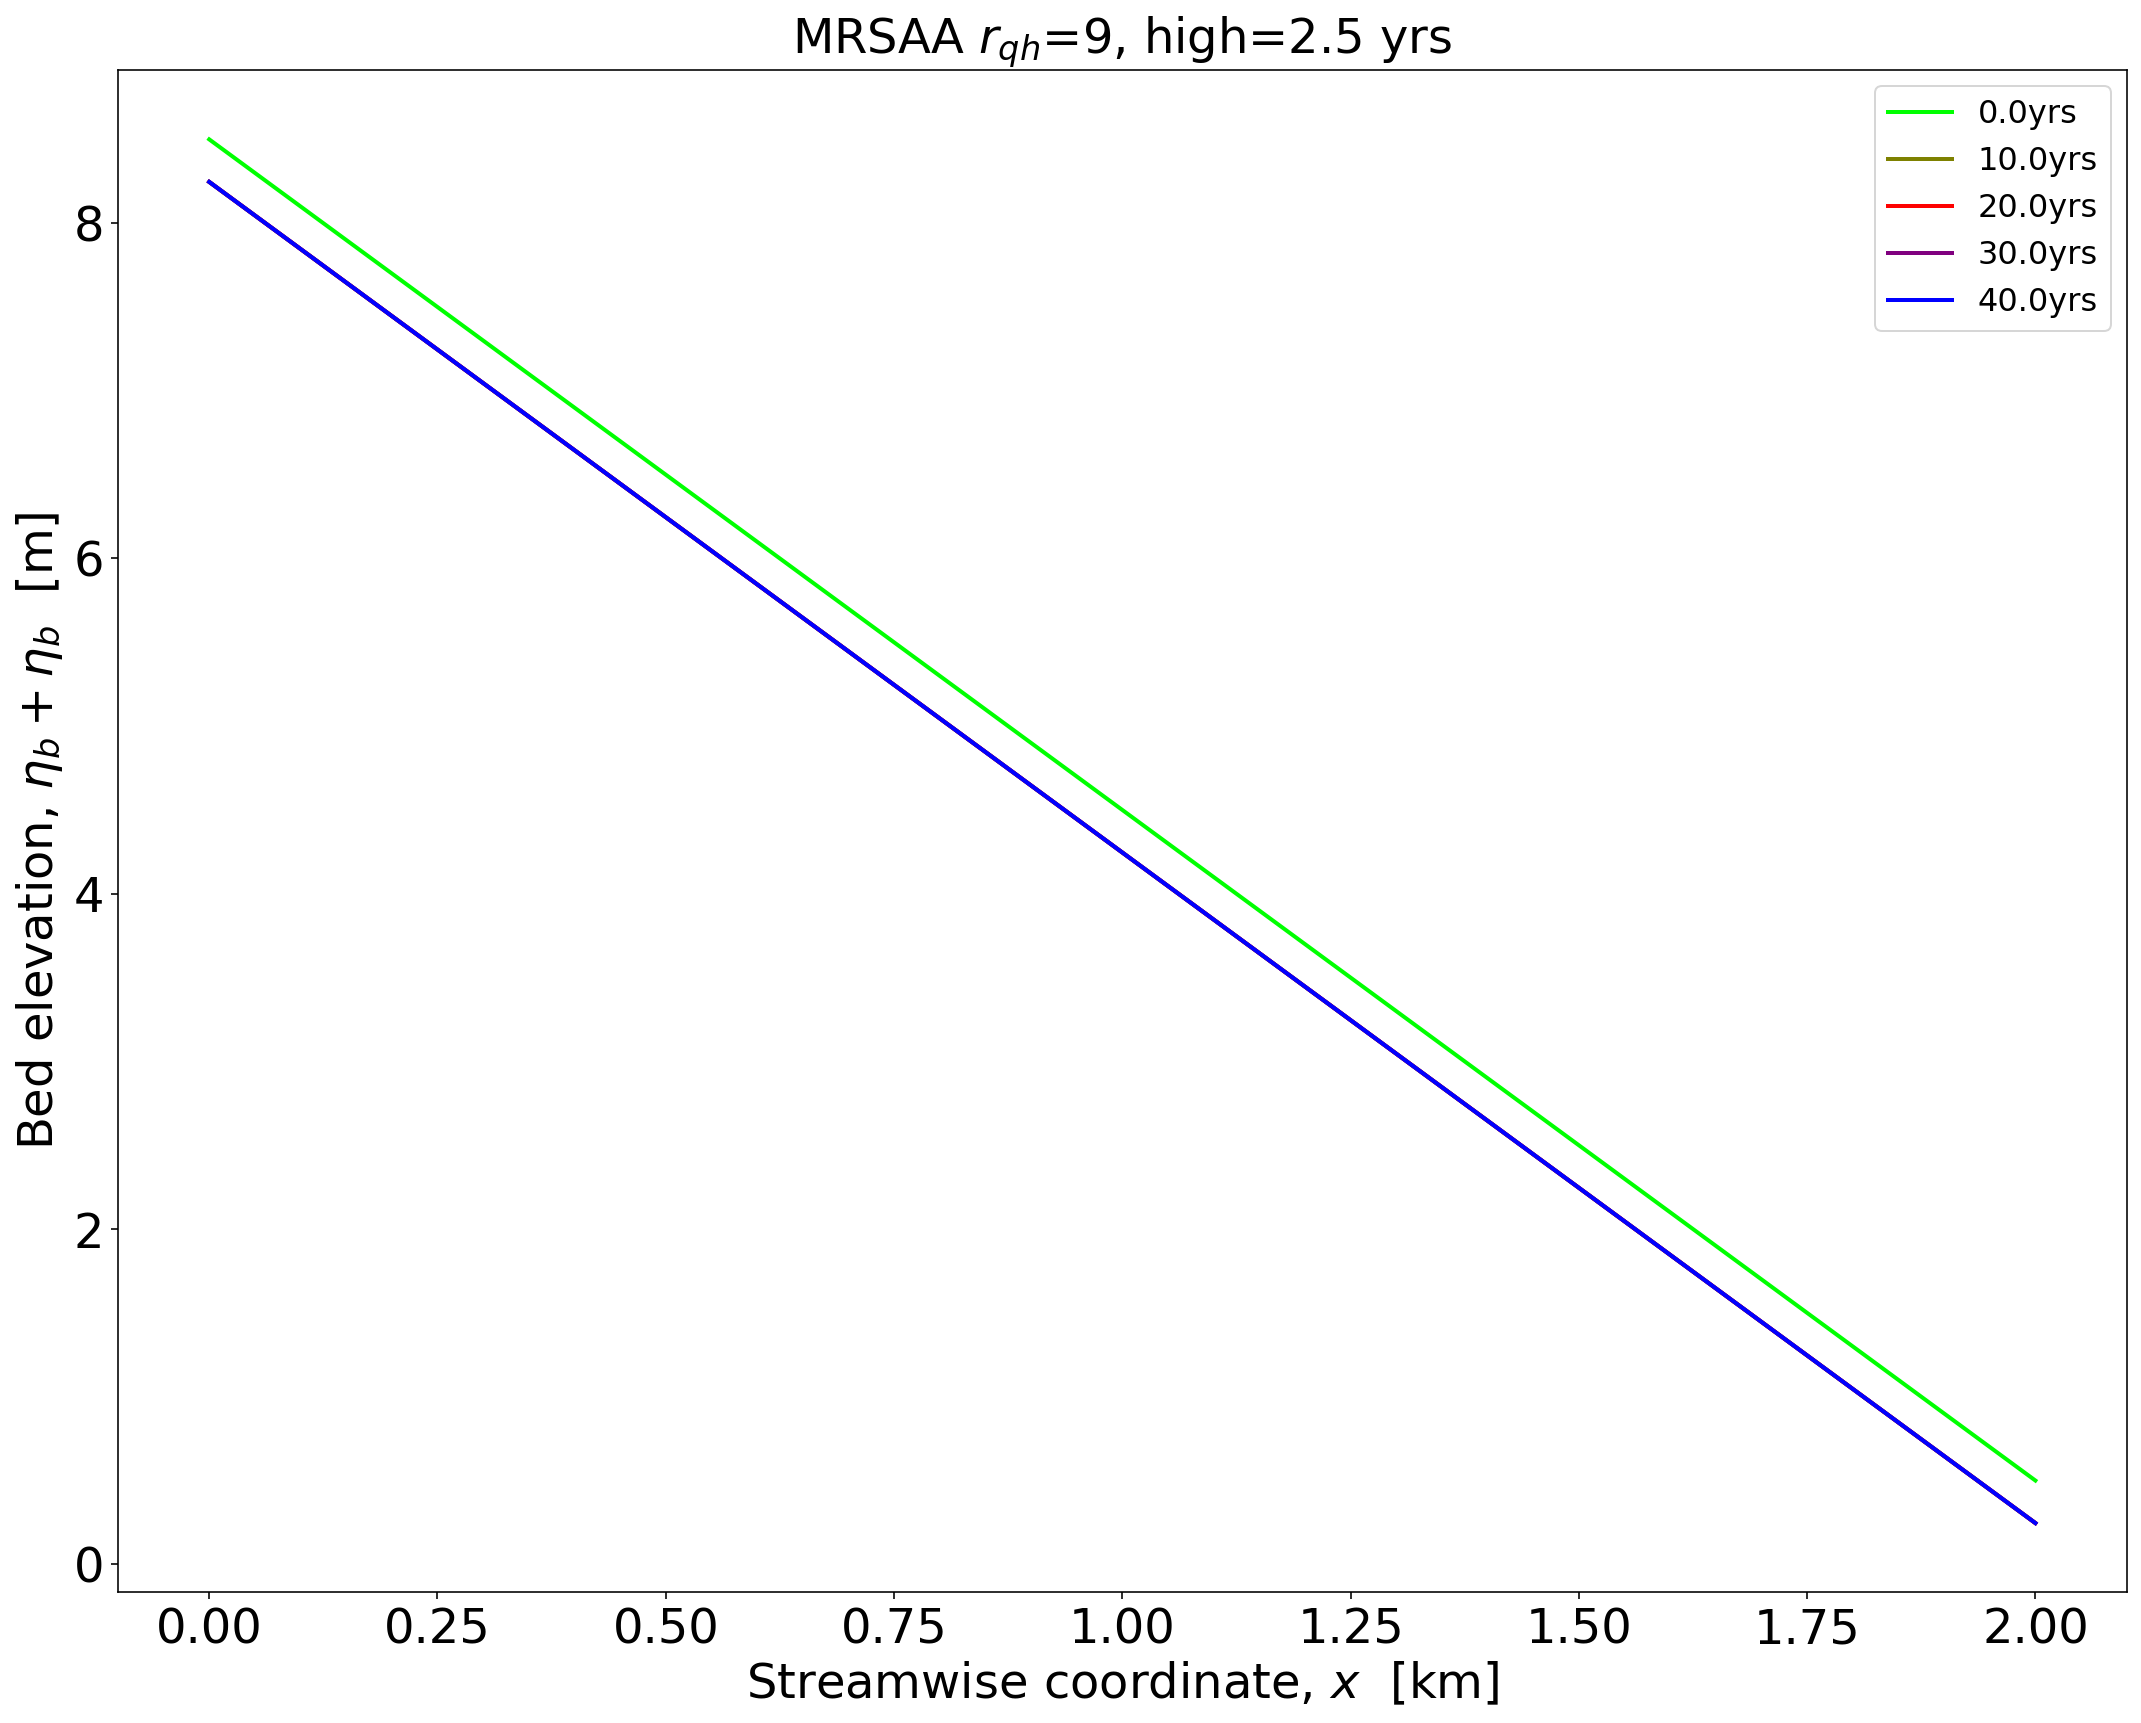

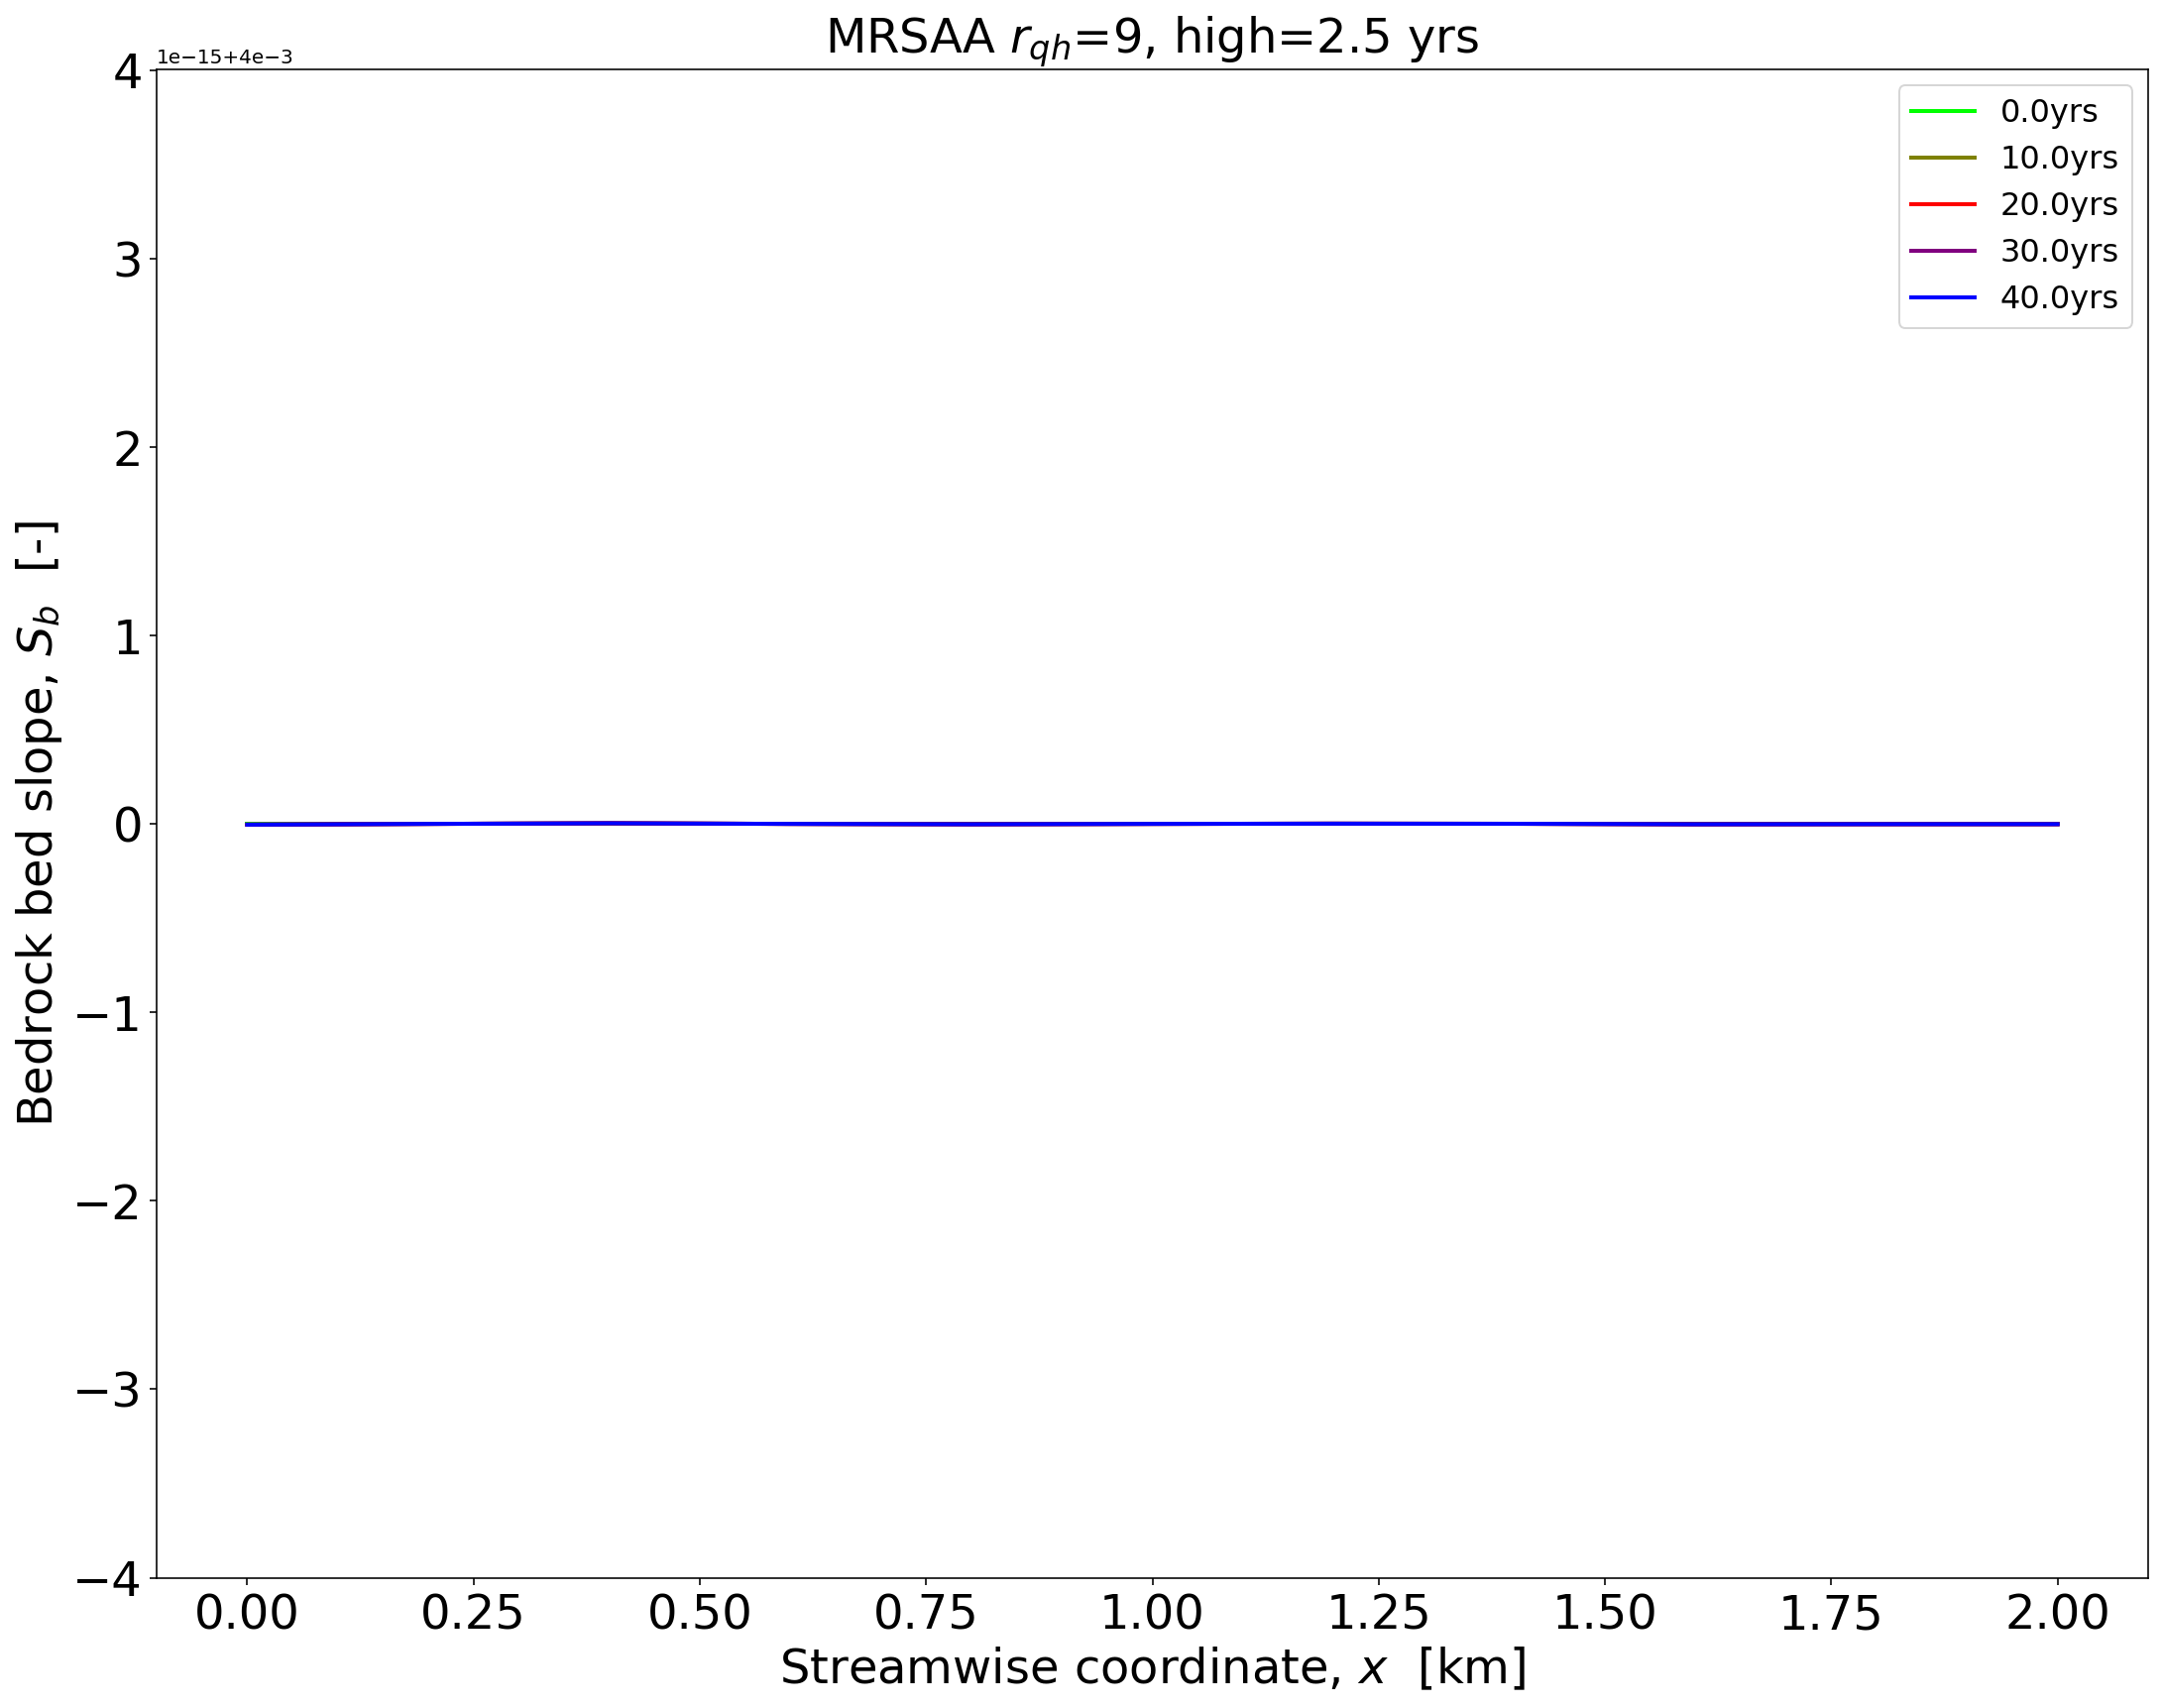

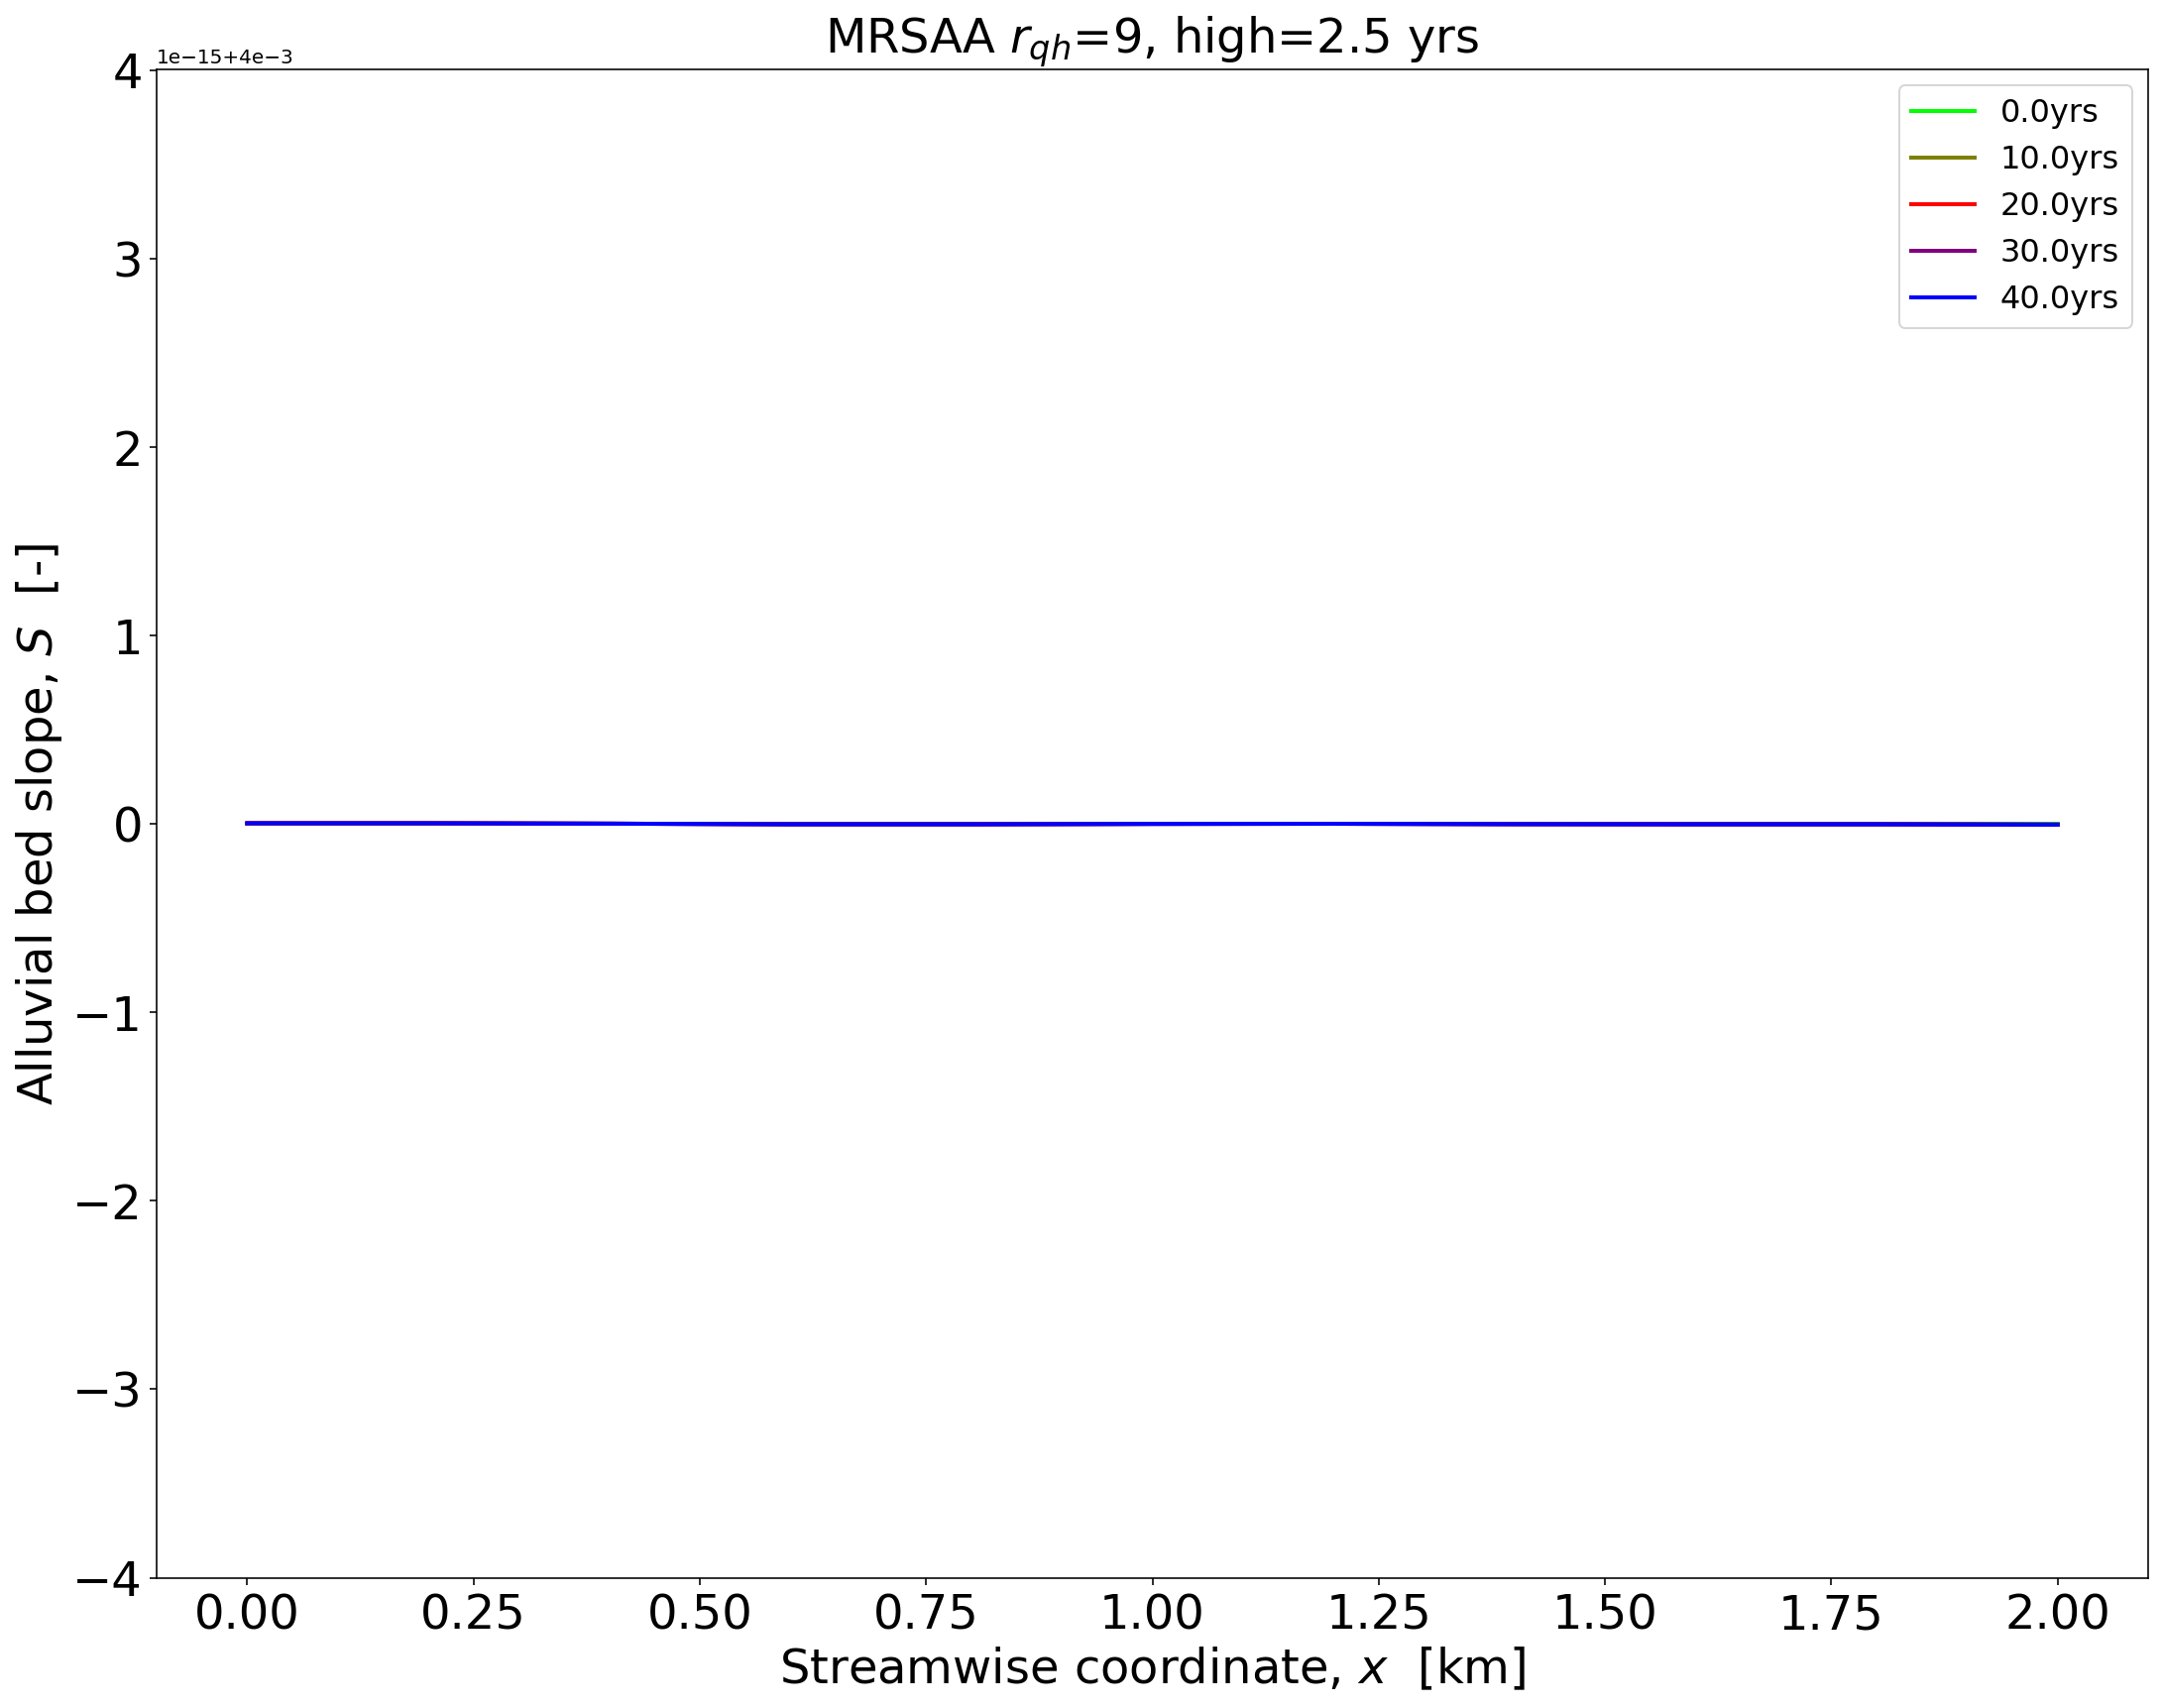

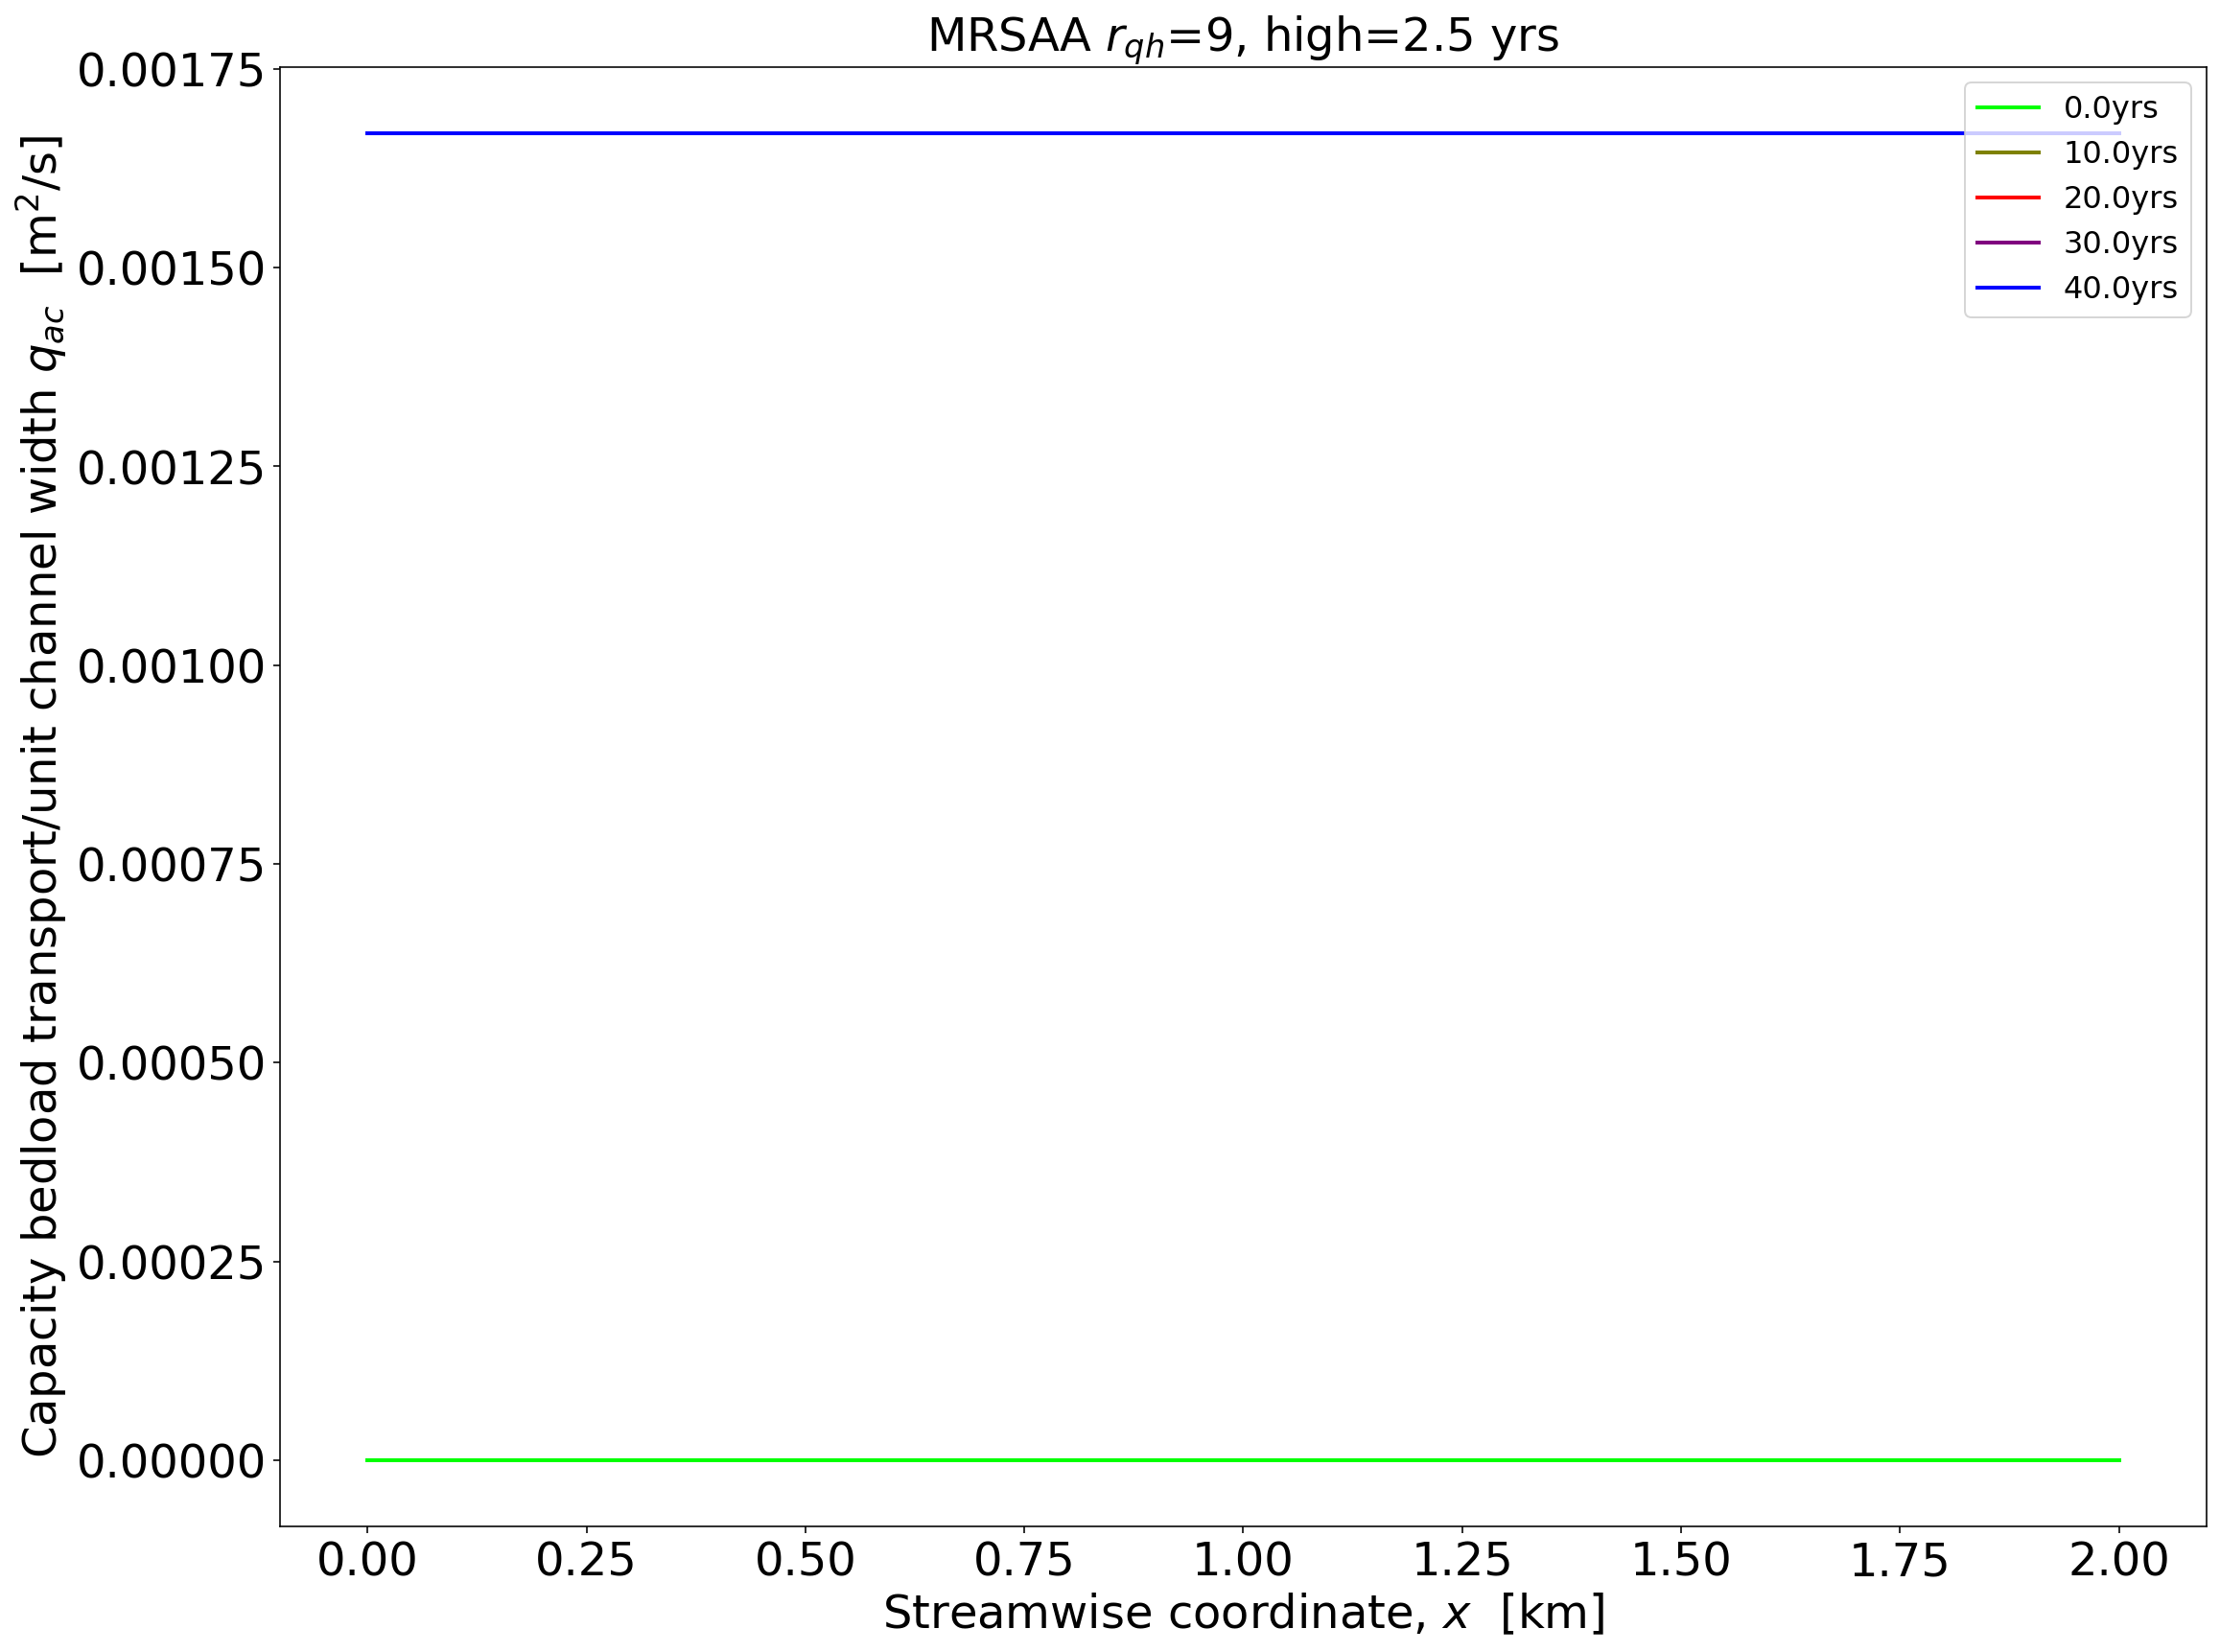

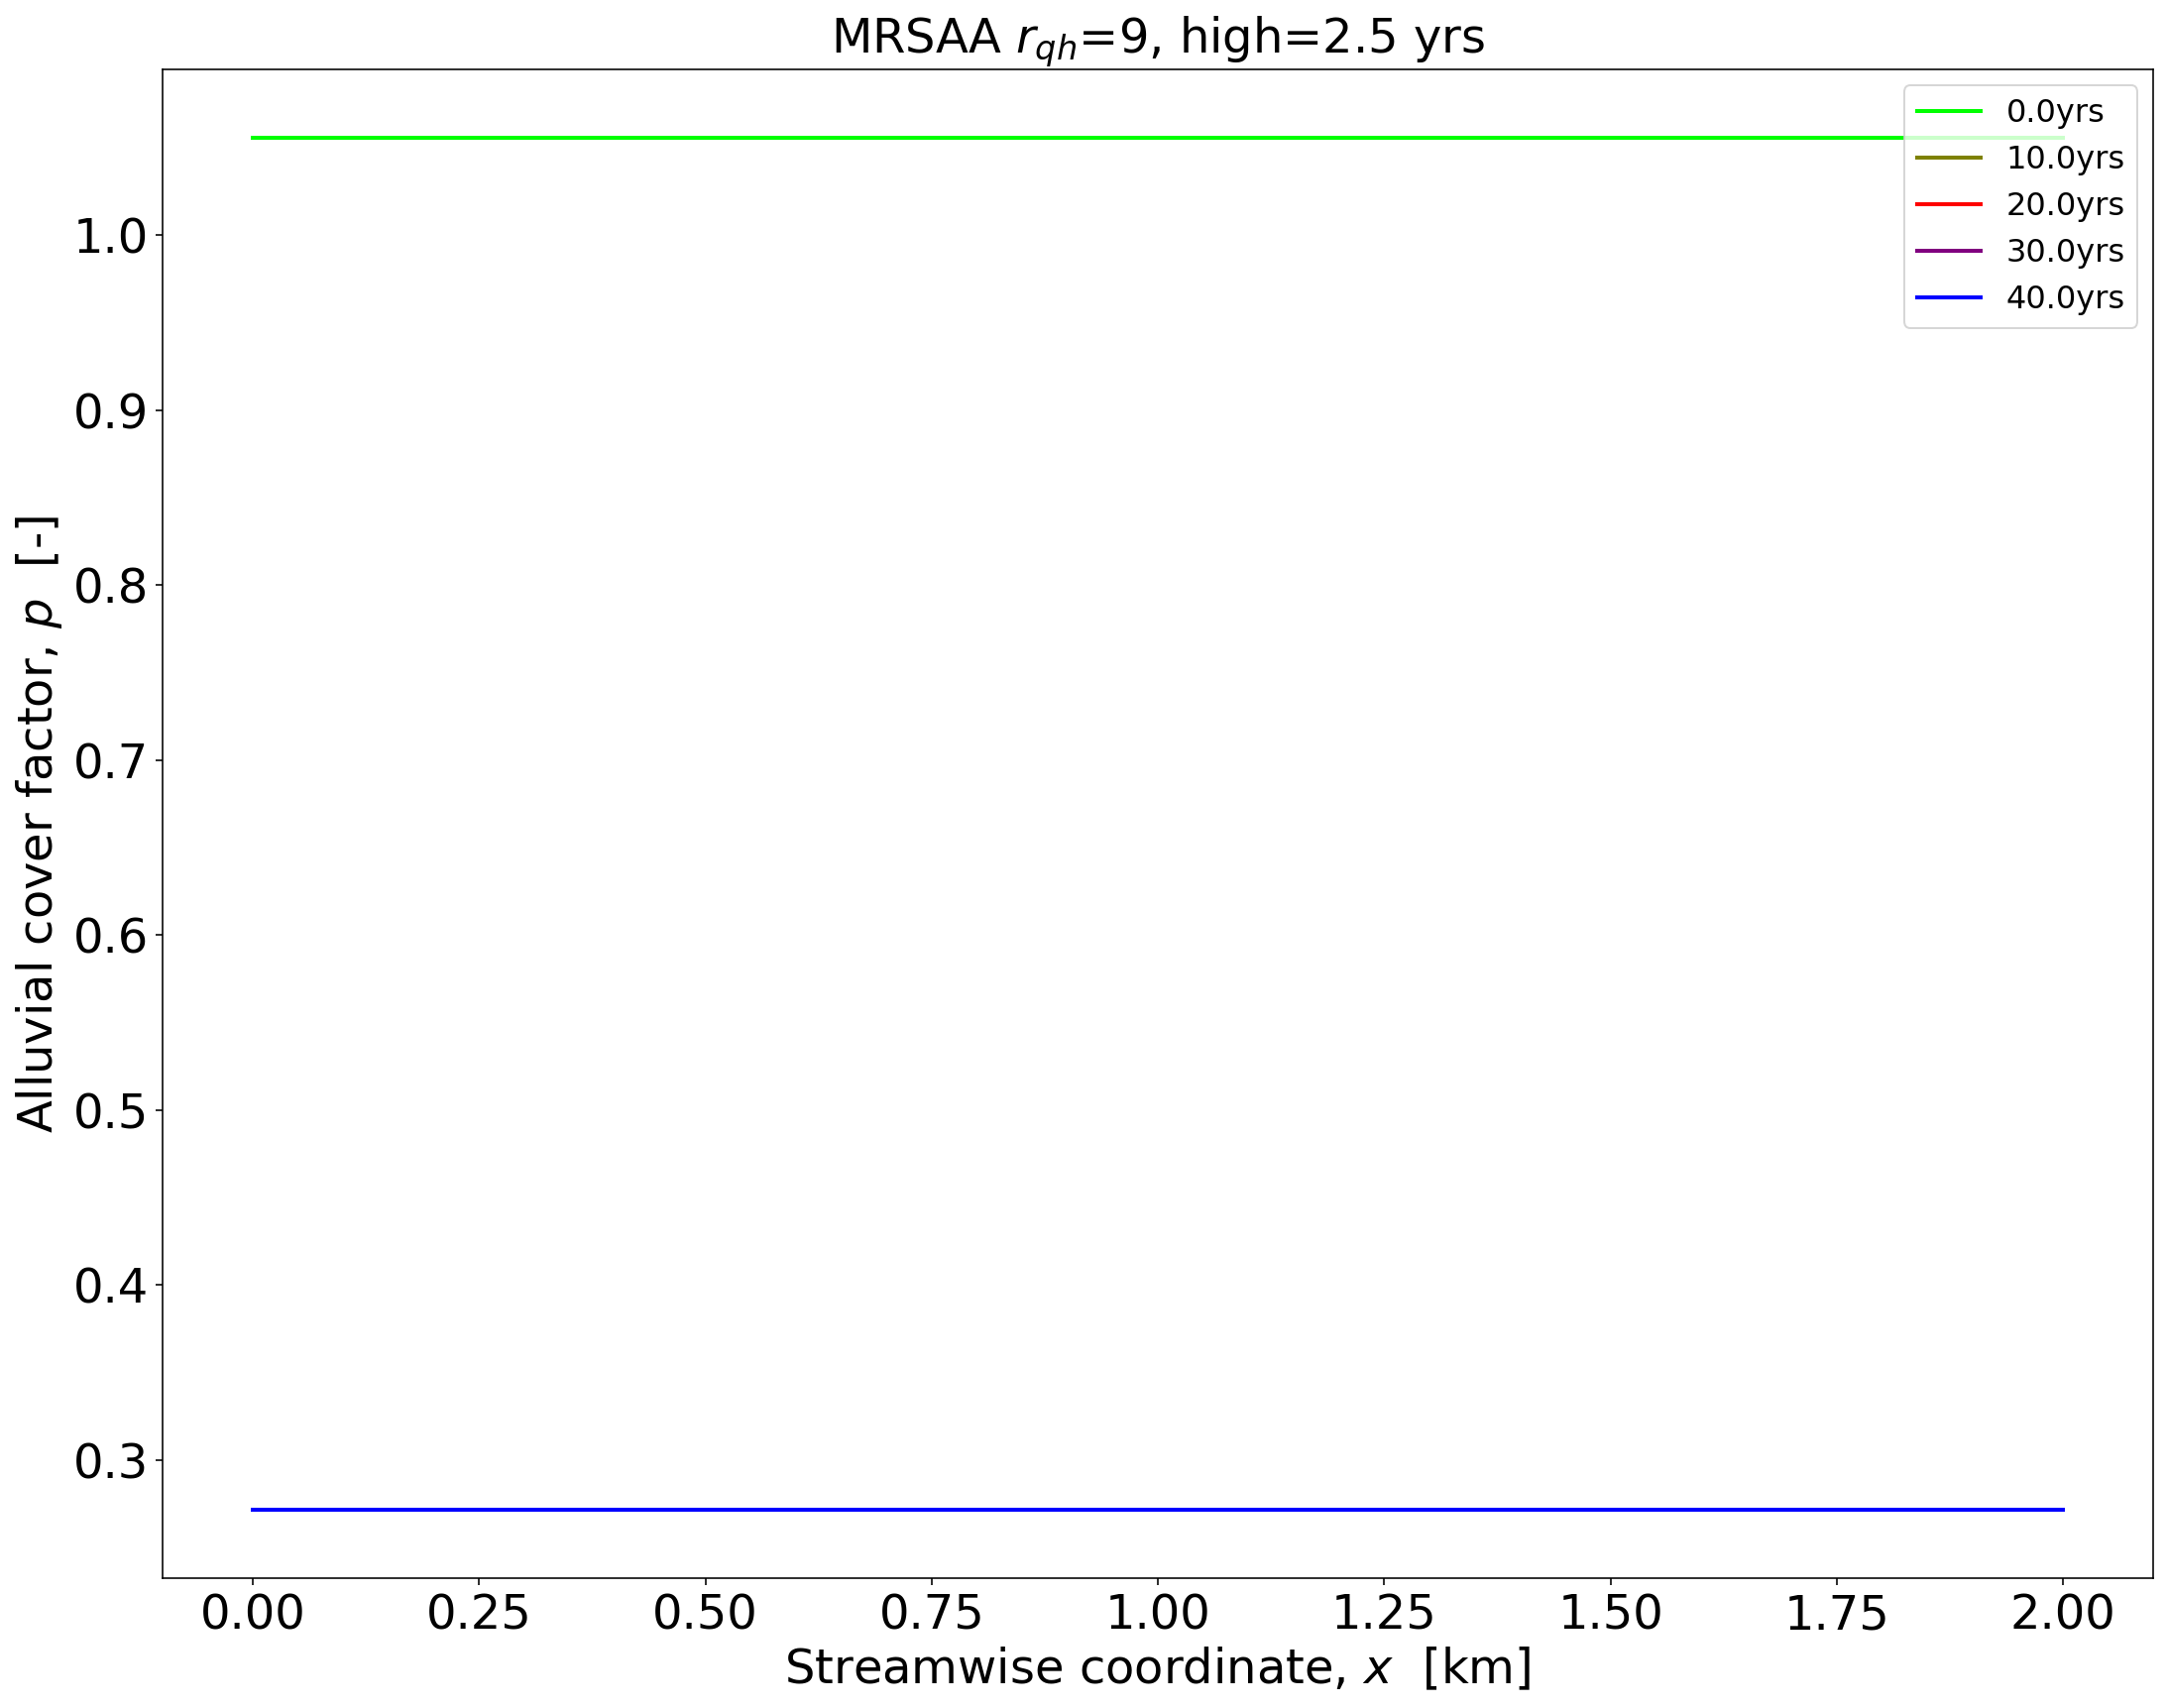

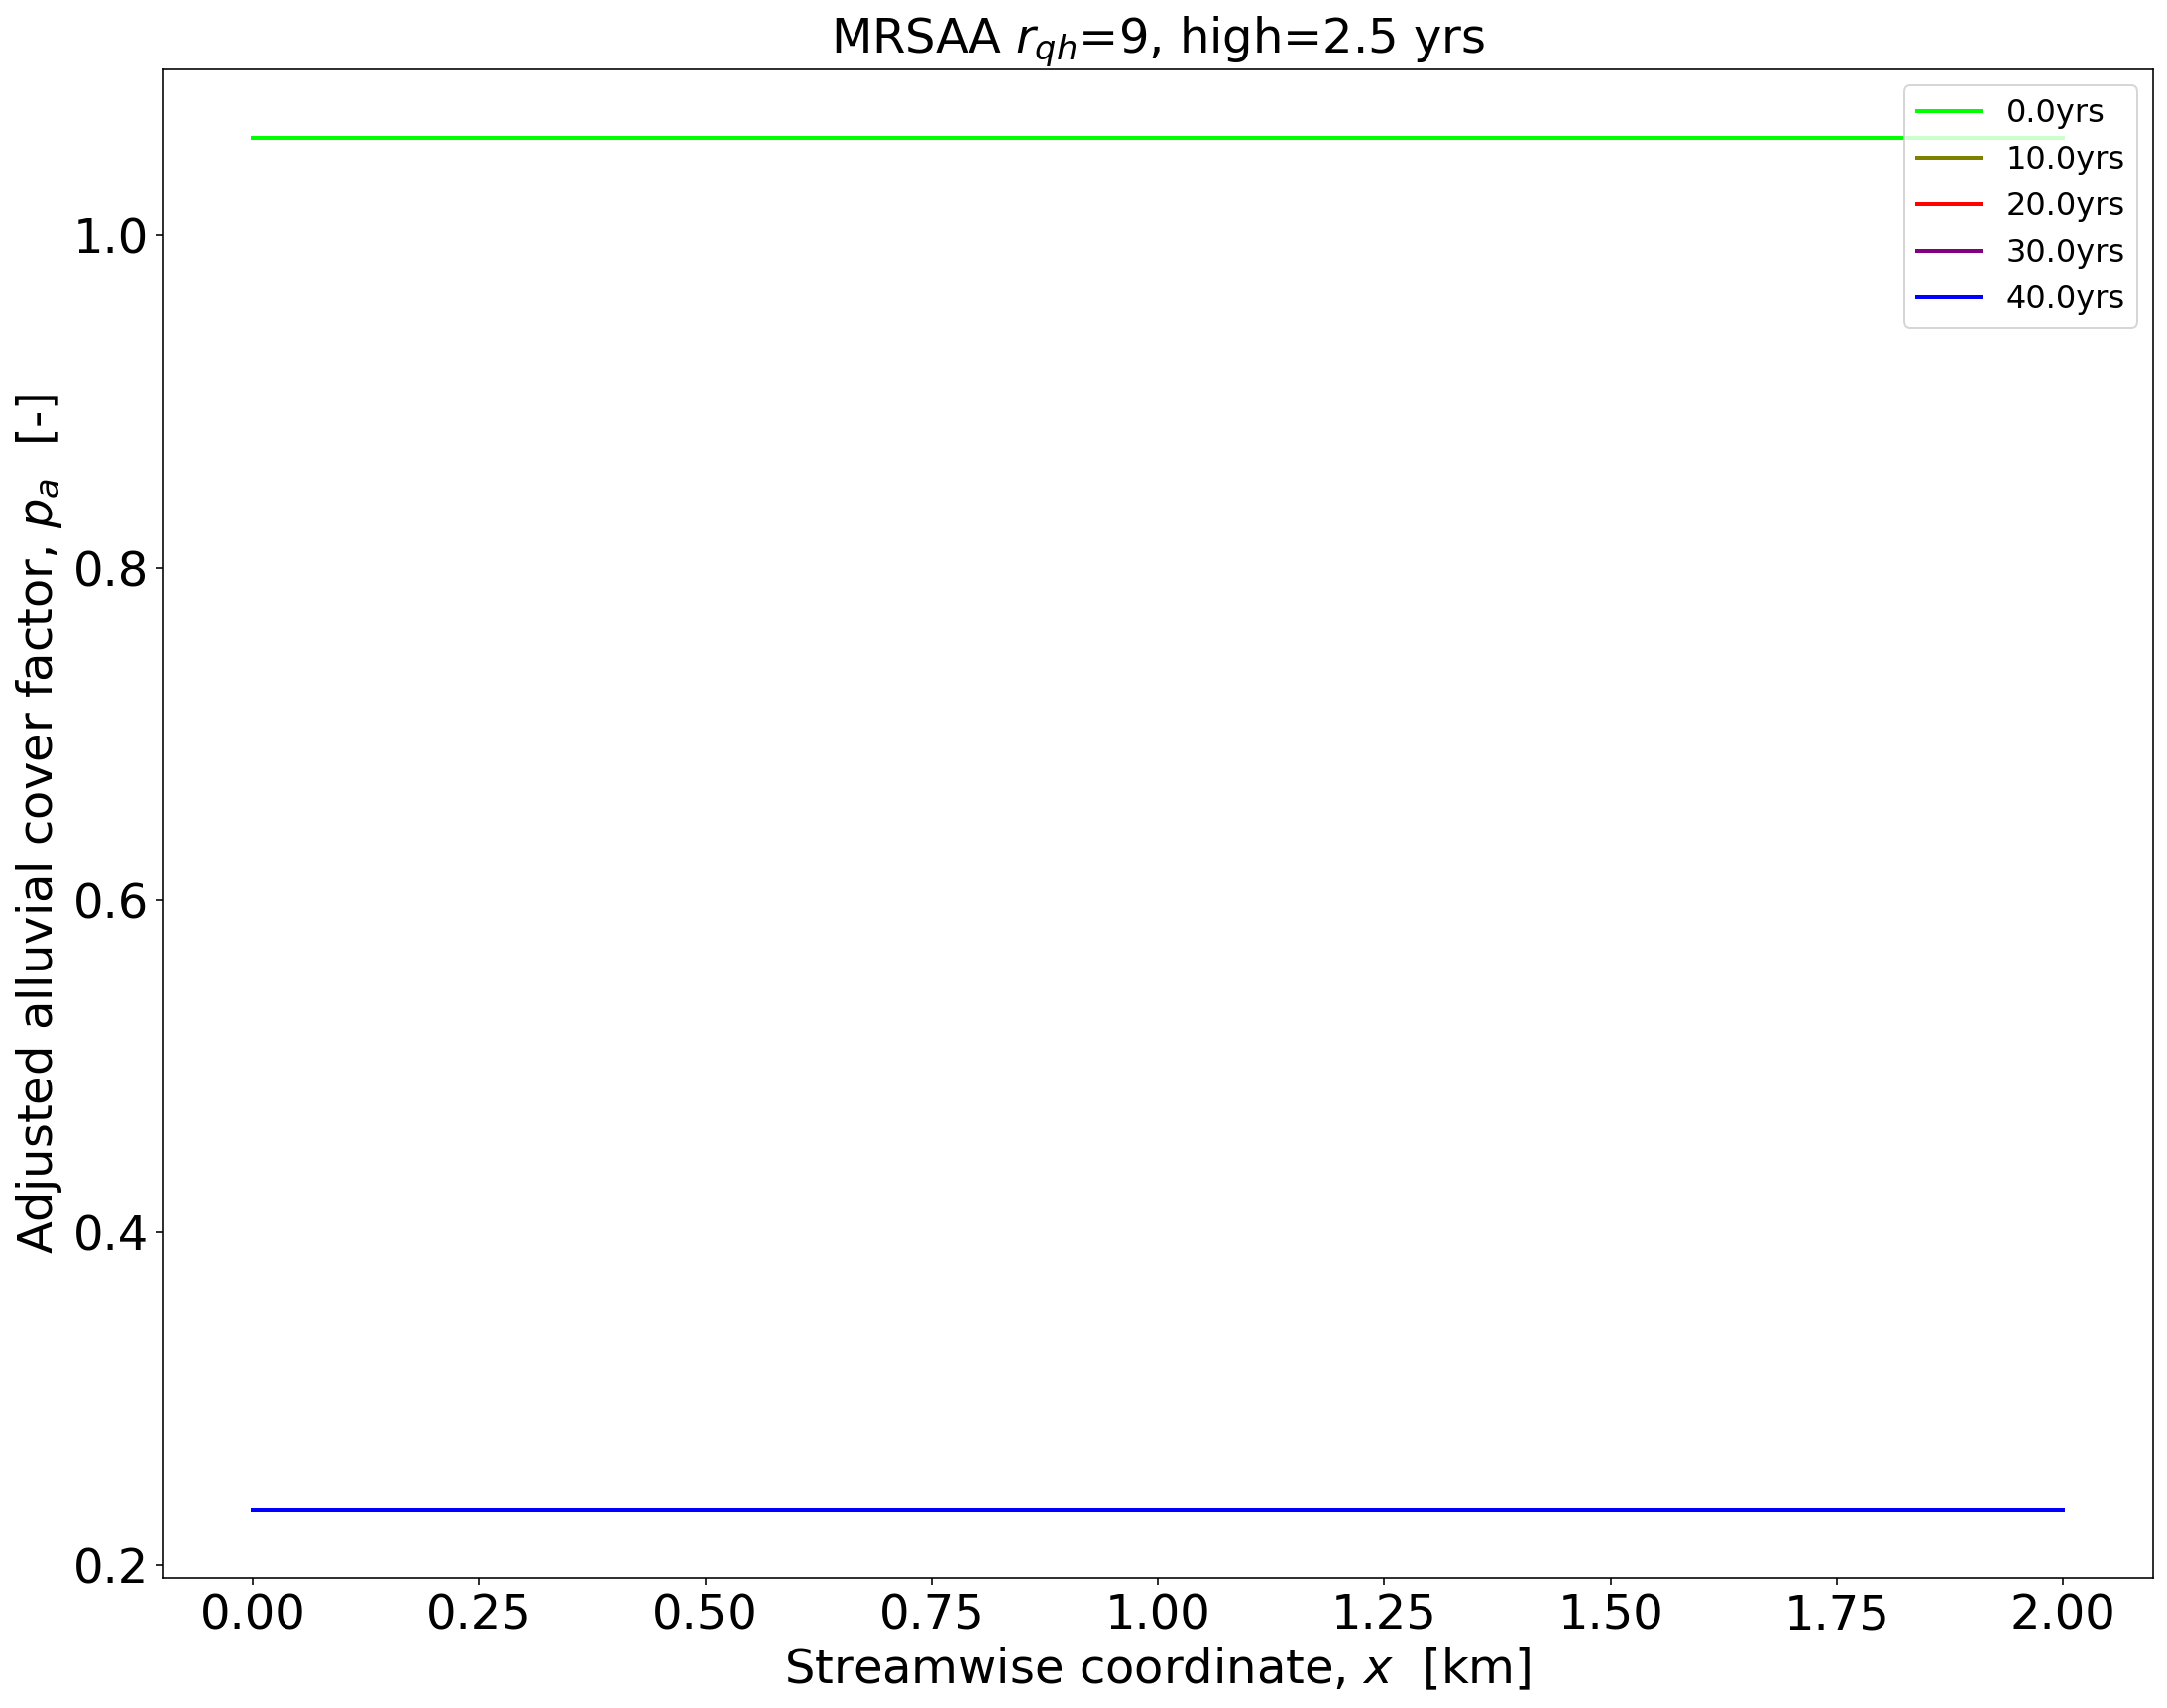

In [125]:
x_label = 'Streamwise coordinate, $x$  [km]'

for i in range(0,N_figures,1):
    # Choose data to plot
    list_data1[i]=np.zeros([M+2,Nprint+2])
    list_data1[i][0,:]=time
    list_data1[i][:,0]=dist
    list_data1[i][1:(M+2),1]=ini_data[i]
    list_data1[i][1:(M+2),2:(Nprint+2)]=list_data[i]

    # Create figure
    fh=plt.figure()
    ax=plt.gca()
    
    # Plot selected time slices
    for j in range (1,Nprint+2,int(Nwant/(Ntoprint*dt))):
        _ = plt.plot(xx/1000,list_data1[i][1:,j],
                     label=str(Ntoprint*dt*(j-1))+'yrs', lw=2)
        
    # Colorize lines in a meaningful, progressive fashion
    colormap = plt.cm.brg   
    # Forward
#     colors = [colormap(idx) for idx in np.linspace(0,1,len(ax.lines))]
    # Reversed
    colors = [colormap(idx) for idx in np.linspace(1,0,len(ax.lines))]
    for idx,line in enumerate(ax.lines):
        line.set_color(colors[idx])
    _ = plt.legend(loc='upper right',fontsize=16)
    
    # Label axes etc
    _ = plt.xlabel(x_label,fontsize=24)
    _ = plt.ylabel(name1[i],fontsize=24)
    if not do_random:
        _ = plt.title('MRSAA $r_{qh}$='+str(rqh)
                      +', high='+str(high_year)+' yrs',fontsize=24)
    else:
        _ = plt.title('MRSAA $r_{qh}$='+str(begin_random)+'-'+str(stop_random)
                 +', high='+str(high_year)+' yrs',fontsize=24)
    _ = ax.tick_params(labelsize=24)


    #_ = plt.savefig(name[i]+'_'+str(int(Nwant))+'_annot'+'.png')
    #_ = plt.savefig(name[i]+'_'+str(int(Nwant))+'_annot'+'.pdf')
    _ = plt.show()

ValueError: x and y must have same first dimension, but have shapes (0,) and (10,)

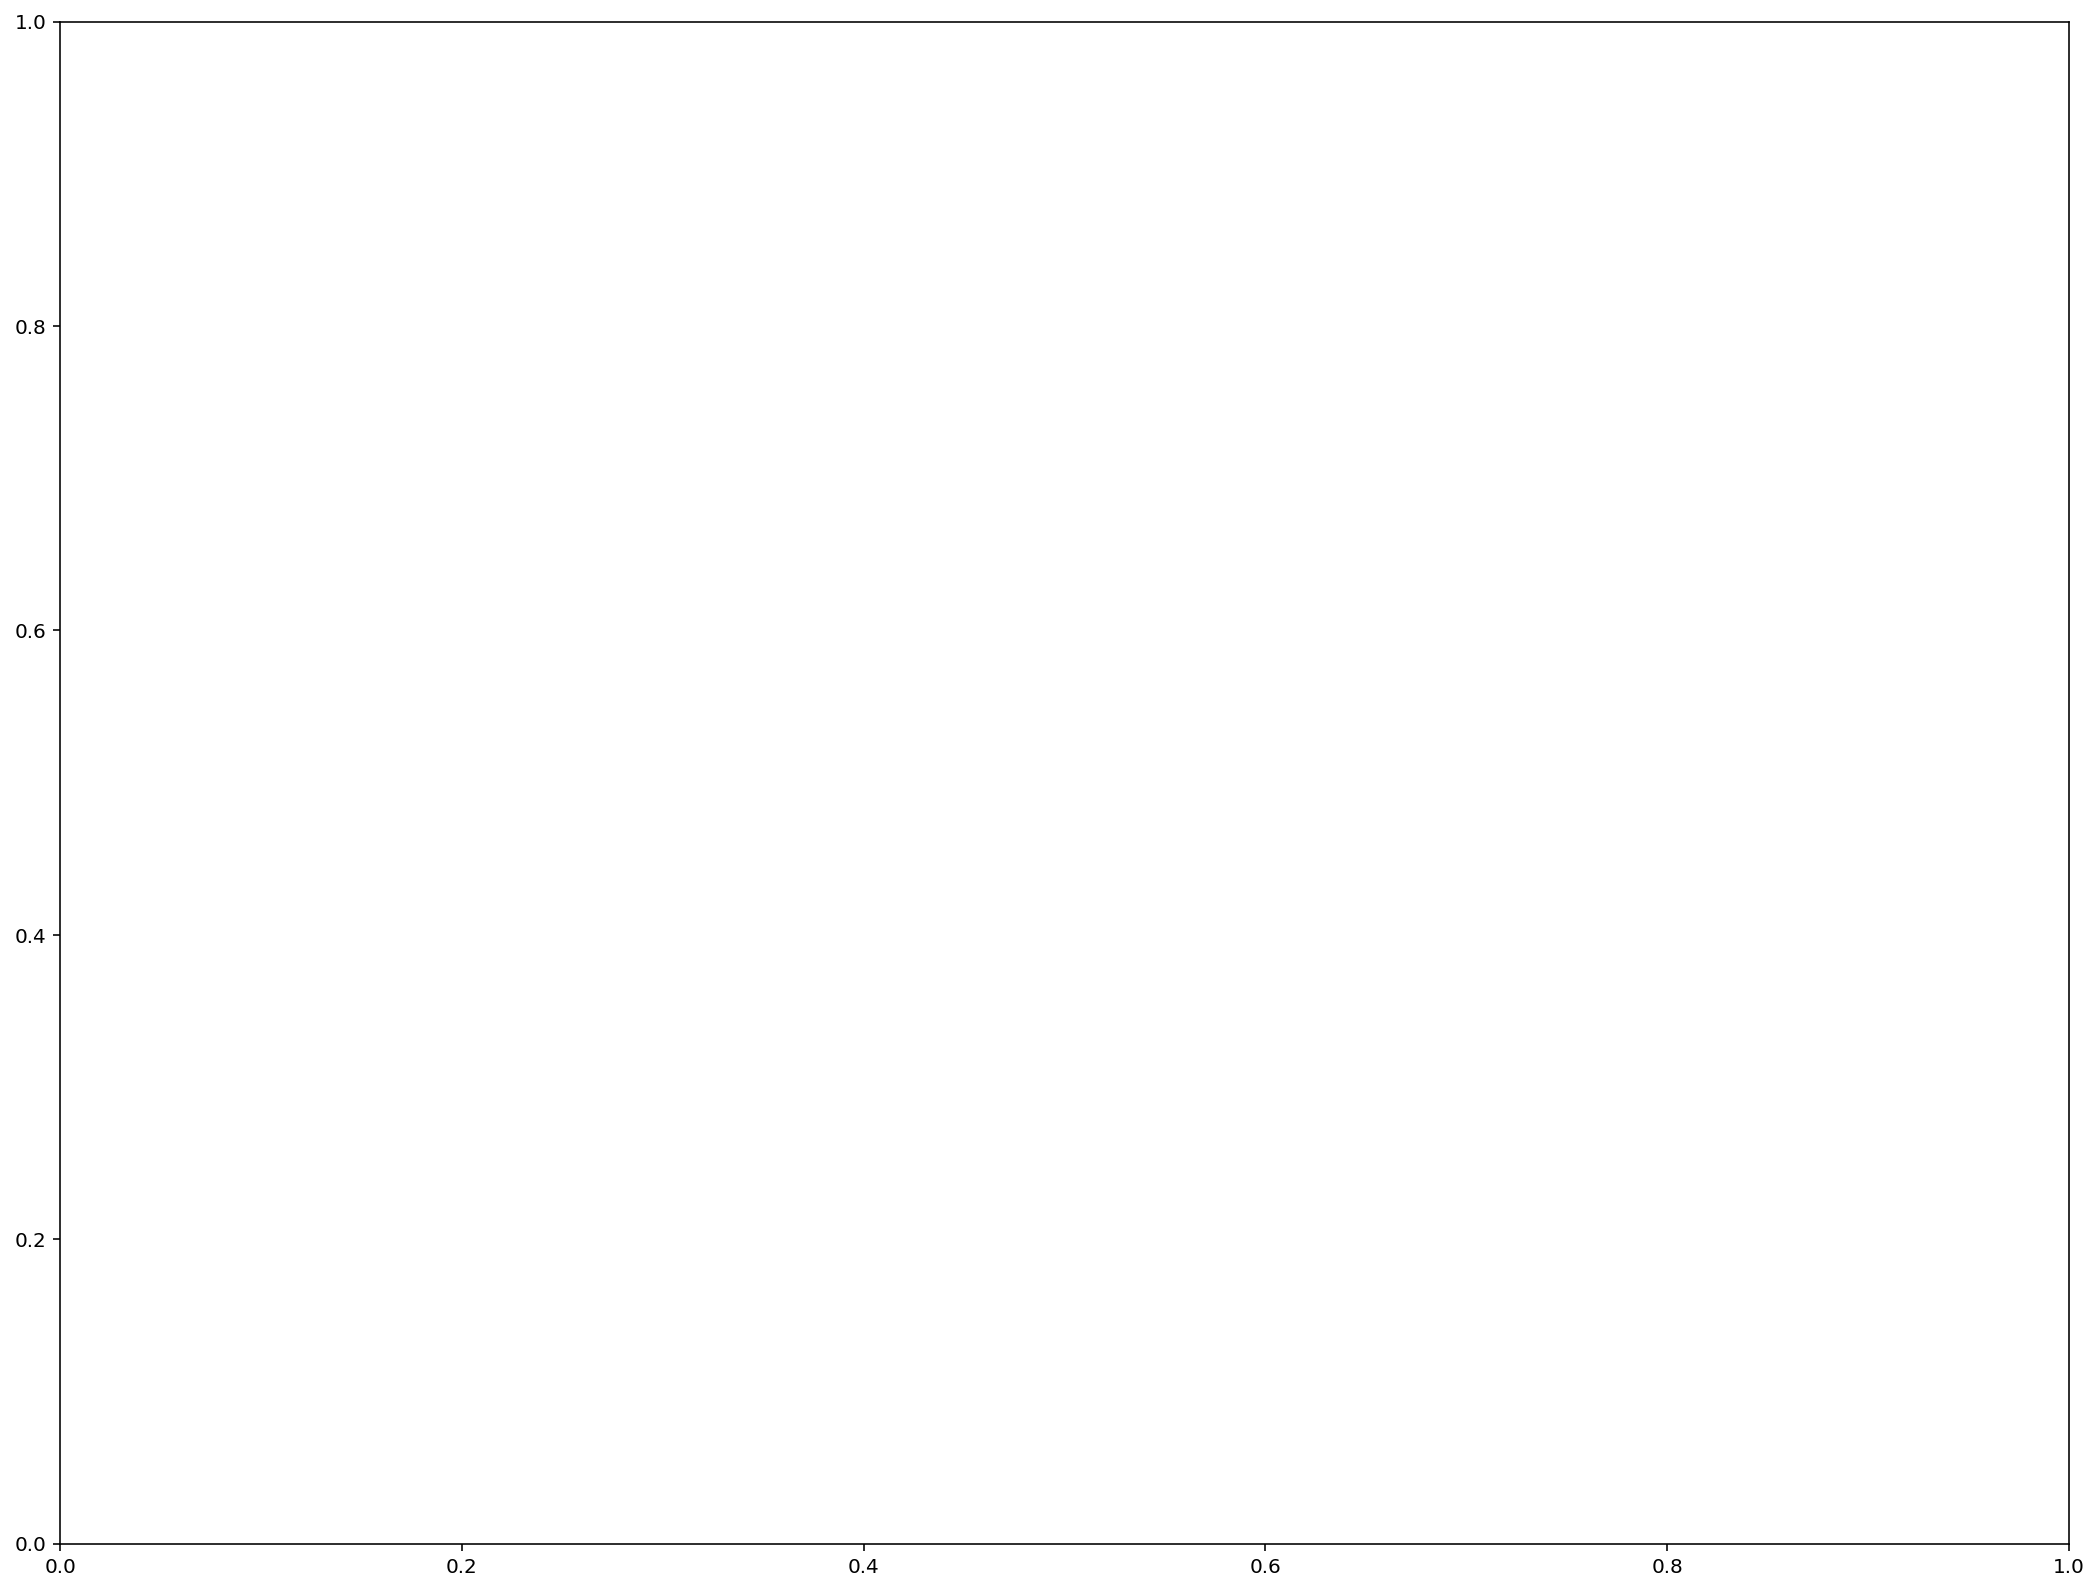

In [78]:
fh=plt.figure()
ax=plt.gca()

yyslope=slope_b_1.mean(axis=0)
time1=time[2:time.size]

plt.plot(time1,yyslope)

ss_year=5000
ss_position=int(ss_year/(dt*Ntoprint)-1)
ss_slope_average=yyslope[ss_position]
print(time1[ss_position], 'years;', 'slope=', ss_slope_average)
plt.plot(time1[ss_position],yyslope[ss_position],'ro',markersize=24)

plt.xlabel('Time (year)',fontsize=24)
plt.ylabel('Average steady-state bedrock slope',fontsize=24)
if not do_random:
    plt.title('$r_{qh}$='+str(rqh)+' for '+str(high_year)+' year high',fontsize=24)
else:
    plt.title('$r_{qh}$='+str(begin_random)+'-'+str(stop_random)
              +' for '+str(high_year)+' year high', fontsize=24)
ax.tick_params(labelsize=24);

#plt.savefig('AverageSlope_'+str(ss_year)+'y'+'.pdf')
#plt.savefig('AverageSlope_'+str(ss_year)+'y'+'.png')
plt.show();